Aglantzia: latitude: 35.1542, longitude: 33.3964

In [1]:
#pip install pytz

In [54]:
import datetime
import pytz
import pandas as pd
import math
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import make_scorer
from sklearn.metrics import root_mean_squared_error

# inverters

In [3]:
inverters = pd.read_csv('inverters_dataset.csv', index_col='datetime', parse_dates=True, infer_datetime_format=True)
inverters = inverters.reset_index()
inverters

C:\Users\tsiop\AppData\Local\Temp\ipykernel_28904\1896710527.py:1: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  inverters = pd.read_csv('inverters_dataset.csv', index_col='datetime', parse_dates=True, infer_datetime_format=True)


,datetime,inverter1,inverter2,inverter3
0,2023-11-03 00:00:00,NaN,0.000000,NaN
1,2023-11-03 01:00:00,NaN,0.000000,0.000000
2,2023-11-03 02:00:00,0.000000,NaN,0.000000
3,2023-11-03 03:00:00,0.000000,0.000000,NaN
4,2023-11-03 04:00:00,53.647059,41.352941,8.545455
...,...,...,...,...
3368,2024-06-30 19:00:00,0.000000,0.000000,0.000000
3369,2024-06-30 20:00:00,NaN,NaN,NaN
3370,2024-06-30 21:00:00,0.000000,0.000000,0.000000
3371,2024-06-30 22:00:00,0.000000,0.000000,0.000000


In [4]:
df1 = inverters[['datetime','inverter1']]
df2 = inverters[['datetime','inverter2']]
df3 = inverters[['datetime','inverter3']]

In [5]:
df1['id'] = 'inverter1'
df1 = df1.rename({'inverter1':'inverter'},axis=1)
df1['panel_size'] = 63*1.7*1
df1['inverter'] = df1['inverter'].fillna(0)

df2['id'] = 'inverter2'
df2 = df2.rename({'inverter2':'inverter'},axis=1)
df2['panel_size'] = 56*1.7*1
df2['inverter'] = df2['inverter'].fillna(0)

df3['id'] = 'inverter3'
df3 = df3.rename({'inverter3':'inverter'},axis=1)
df3['panel_size'] = 34*1.7*1
df3['inverter'] = df3['inverter'].fillna(0)

C:\Users\tsiop\AppData\Local\Temp\ipykernel_28904\3958381918.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['id'] = 'inverter1'
C:\Users\tsiop\AppData\Local\Temp\ipykernel_28904\3958381918.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['id'] = 'inverter2'
C:\Users\tsiop\AppData\Local\Temp\ipykernel_28904\3958381918.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in th

In [6]:
inverters = pd.concat([df1,df2,df3],ignore_index=True)

In [7]:
inverters

,datetime,inverter,id,panel_size
0,2023-11-03 00:00:00,0.000000,inverter1,107.1
1,2023-11-03 01:00:00,0.000000,inverter1,107.1
2,2023-11-03 02:00:00,0.000000,inverter1,107.1
3,2023-11-03 03:00:00,0.000000,inverter1,107.1
4,2023-11-03 04:00:00,53.647059,inverter1,107.1
...,...,...,...,...
10114,2024-06-30 19:00:00,0.000000,inverter3,57.8
10115,2024-06-30 20:00:00,0.000000,inverter3,57.8
10116,2024-06-30 21:00:00,0.000000,inverter3,57.8
10117,2024-06-30 22:00:00,0.000000,inverter3,57.8


# openmeteo

In [8]:
#!pip install openmeteo-requests
#!pip install requests-cache retry-requests numpy pandas

In [9]:
import openmeteo_requests

import requests_cache
import pandas as pd
from retry_requests import retry

# Setup the Open-Meteo API client with cache and retry on error
cache_session = requests_cache.CachedSession('.cache', expire_after = -1)
retry_session = retry(cache_session, retries = 5, backoff_factor = 0.2)
openmeteo = openmeteo_requests.Client(session = retry_session)

# Make sure all required weather variables are listed here
# The order of variables in hourly or daily is important to assign them correctly below
url = "https://archive-api.open-meteo.com/v1/archive"
params = {
	"latitude": 35.1542,
	"longitude": 33.3964,
	"start_date": "2023-11-01",
	"end_date": "2024-07-01",
	"hourly": ["temperature_2m", "relative_humidity_2m", "apparent_temperature", "precipitation", "rain", "pressure_msl", "surface_pressure", "cloud_cover", "cloud_cover_low", "cloud_cover_mid", "cloud_cover_high", "wind_speed_10m", "wind_speed_100m", "wind_direction_10m", "wind_direction_100m", "wind_gusts_10m", "is_day", "sunshine_duration", "shortwave_radiation", "direct_radiation", "diffuse_radiation", "direct_normal_irradiance", "terrestrial_radiation", "shortwave_radiation_instant", "direct_radiation_instant", "diffuse_radiation_instant", "direct_normal_irradiance_instant", "terrestrial_radiation_instant"],
	"timezone": "Europe/Moscow"
}
responses = openmeteo.weather_api(url, params=params)

# Process first location. Add a for-loop for multiple locations or weather models
response = responses[0]
print(f"Coordinates {response.Latitude()}°N {response.Longitude()}°E")
print(f"Elevation {response.Elevation()} m asl")
print(f"Timezone {response.Timezone()} {response.TimezoneAbbreviation()}")
print(f"Timezone difference to GMT+0 {response.UtcOffsetSeconds()} s")

# Process hourly data. The order of variables needs to be the same as requested.
hourly = response.Hourly()
hourly_temperature_2m = hourly.Variables(0).ValuesAsNumpy()
hourly_relative_humidity_2m = hourly.Variables(1).ValuesAsNumpy()
hourly_apparent_temperature = hourly.Variables(2).ValuesAsNumpy()
hourly_precipitation = hourly.Variables(3).ValuesAsNumpy()
hourly_rain = hourly.Variables(4).ValuesAsNumpy()
hourly_pressure_msl = hourly.Variables(5).ValuesAsNumpy()
hourly_surface_pressure = hourly.Variables(6).ValuesAsNumpy()
hourly_cloud_cover = hourly.Variables(7).ValuesAsNumpy()
hourly_cloud_cover_low = hourly.Variables(8).ValuesAsNumpy()
hourly_cloud_cover_mid = hourly.Variables(9).ValuesAsNumpy()
hourly_cloud_cover_high = hourly.Variables(10).ValuesAsNumpy()
hourly_wind_speed_10m = hourly.Variables(11).ValuesAsNumpy()
hourly_wind_speed_100m = hourly.Variables(12).ValuesAsNumpy()
hourly_wind_direction_10m = hourly.Variables(13).ValuesAsNumpy()
hourly_wind_direction_100m = hourly.Variables(14).ValuesAsNumpy()
hourly_wind_gusts_10m = hourly.Variables(15).ValuesAsNumpy()
hourly_is_day = hourly.Variables(16).ValuesAsNumpy()
hourly_sunshine_duration = hourly.Variables(17).ValuesAsNumpy()
hourly_shortwave_radiation = hourly.Variables(18).ValuesAsNumpy()
hourly_direct_radiation = hourly.Variables(19).ValuesAsNumpy()
hourly_diffuse_radiation = hourly.Variables(20).ValuesAsNumpy()
hourly_direct_normal_irradiance = hourly.Variables(21).ValuesAsNumpy()
hourly_terrestrial_radiation = hourly.Variables(22).ValuesAsNumpy()
hourly_shortwave_radiation_instant = hourly.Variables(23).ValuesAsNumpy()
hourly_direct_radiation_instant = hourly.Variables(24).ValuesAsNumpy()
hourly_diffuse_radiation_instant = hourly.Variables(25).ValuesAsNumpy()
hourly_direct_normal_irradiance_instant = hourly.Variables(26).ValuesAsNumpy()
hourly_terrestrial_radiation_instant = hourly.Variables(27).ValuesAsNumpy()

hourly_data = {"date": pd.date_range(
	start = pd.to_datetime(hourly.Time(), unit = "s", utc = True),
	end = pd.to_datetime(hourly.TimeEnd(), unit = "s", utc = True),
	freq = pd.Timedelta(seconds = hourly.Interval()),
	inclusive = "left"
)}
hourly_data["temperature_2m"] = hourly_temperature_2m
hourly_data["relative_humidity_2m"] = hourly_relative_humidity_2m
hourly_data["apparent_temperature"] = hourly_apparent_temperature
hourly_data["precipitation"] = hourly_precipitation
hourly_data["rain"] = hourly_rain
hourly_data["pressure_msl"] = hourly_pressure_msl
hourly_data["surface_pressure"] = hourly_surface_pressure
hourly_data["cloud_cover"] = hourly_cloud_cover
hourly_data["cloud_cover_low"] = hourly_cloud_cover_low
hourly_data["cloud_cover_mid"] = hourly_cloud_cover_mid
hourly_data["cloud_cover_high"] = hourly_cloud_cover_high
hourly_data["wind_speed_10m"] = hourly_wind_speed_10m
hourly_data["wind_speed_100m"] = hourly_wind_speed_100m
hourly_data["wind_direction_10m"] = hourly_wind_direction_10m
hourly_data["wind_direction_100m"] = hourly_wind_direction_100m
hourly_data["wind_gusts_10m"] = hourly_wind_gusts_10m
hourly_data["is_day"] = hourly_is_day
hourly_data["sunshine_duration"] = hourly_sunshine_duration
hourly_data["shortwave_radiation"] = hourly_shortwave_radiation
hourly_data["direct_radiation"] = hourly_direct_radiation
hourly_data["diffuse_radiation"] = hourly_diffuse_radiation
hourly_data["direct_normal_irradiance"] = hourly_direct_normal_irradiance
hourly_data["terrestrial_radiation"] = hourly_terrestrial_radiation
hourly_data["shortwave_radiation_instant"] = hourly_shortwave_radiation_instant
hourly_data["direct_radiation_instant"] = hourly_direct_radiation_instant
hourly_data["diffuse_radiation_instant"] = hourly_diffuse_radiation_instant
hourly_data["direct_normal_irradiance_instant"] = hourly_direct_normal_irradiance_instant
hourly_data["terrestrial_radiation_instant"] = hourly_terrestrial_radiation_instant

hourly_dataframe = pd.DataFrame(data = hourly_data)

Coordinates 35.184532165527344°N 33.40561294555664°E
Elevation 139.0 m asl
Timezone b'Europe/Moscow' b'MSK'
Timezone difference to GMT+0 10800 s


In [10]:
hourly_dataframe

,date,temperature_2m,relative_humidity_2m,apparent_temperature,precipitation,rain,pressure_msl,surface_pressure,cloud_cover,cloud_cover_low,...,shortwave_radiation,direct_radiation,diffuse_radiation,direct_normal_irradiance,terrestrial_radiation,shortwave_radiation_instant,direct_radiation_instant,diffuse_radiation_instant,direct_normal_irradiance_instant,terrestrial_radiation_instant
0,2023-10-31 21:00:00+00:00,20.058001,68.388641,20.906055,0.0,0.0,1015.599976,999.309387,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
1,2023-10-31 22:00:00+00:00,20.757999,59.395908,21.011189,0.0,0.0,1015.700012,999.446106,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
2,2023-10-31 23:00:00+00:00,21.358000,52.720970,21.194202,0.0,0.0,1015.700012,999.479065,0.6,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
3,2023-11-01 00:00:00+00:00,21.058001,53.345676,21.239792,0.0,0.0,1015.700012,999.462769,0.6,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
4,2023-11-01 01:00:00+00:00,19.208000,80.176010,19.185602,0.0,0.0,1015.200012,998.869080,73.5,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5851,2024-07-01 16:00:00+00:00,34.908001,16.781036,33.155514,0.0,0.0,1002.599976,987.286011,0.0,0.0,...,221.0,147.0,74.0,503.360718,386.412720,146.709152,97.584824,49.124332,503.360718,256.51712
5852,2024-07-01 17:00:00+00:00,32.307999,27.135326,31.560497,0.0,0.0,1003.200012,987.747742,0.0,0.0,...,53.0,25.0,28.0,187.889069,127.564667,0.236202,0.111416,0.124786,1.278354,0.56851
5853,2024-07-01 18:00:00+00:00,30.507999,35.892208,30.426815,0.0,0.0,1003.400024,987.853760,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
5854,2024-07-01 19:00:00+00:00,28.708000,47.970535,29.170872,0.0,0.0,1003.599976,987.958679,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000


In [11]:
hourly_dataframe.columns

Index(['date', 'temperature_2m', 'relative_humidity_2m',
       'apparent_temperature', 'precipitation', 'rain', 'pressure_msl',
       'surface_pressure', 'cloud_cover', 'cloud_cover_low', 'cloud_cover_mid',
       'cloud_cover_high', 'wind_speed_10m', 'wind_speed_100m',
       'wind_direction_10m', 'wind_direction_100m', 'wind_gusts_10m', 'is_day',
       'sunshine_duration', 'shortwave_radiation', 'direct_radiation',
       'diffuse_radiation', 'direct_normal_irradiance',
       'terrestrial_radiation', 'shortwave_radiation_instant',
       'direct_radiation_instant', 'diffuse_radiation_instant',
       'direct_normal_irradiance_instant', 'terrestrial_radiation_instant'],
      dtype='object')

# astral

In [12]:
#pip install astral

In [13]:
import astral
from astral import sun

In [14]:
latitude=35.1542
longitude=33.3964
timezone="Europe/Nicosia"

In [15]:
loc = astral.LocationInfo(name='Nicosia',
                          region='Cyprus',
                          timezone=timezone,
                          latitude=latitude,
                          longitude=longitude)
hourly_dataframe['azimuth'] = hourly_dataframe['date'].map(lambda x: sun.azimuth(loc.observer, x))
hourly_dataframe['zenith'] = hourly_dataframe['date'].map(lambda x: sun.zenith(loc.observer, x))
hourly_dataframe['dusk'] = hourly_dataframe['date'].map(lambda x: sun.dusk(loc.observer, x).hour)
hourly_dataframe['dawn'] = hourly_dataframe['date'].map(lambda x: sun.dawn(loc.observer, x).hour)
hourly_dataframe['elevation'] = hourly_dataframe['date'].map(lambda x: sun.elevation(loc.observer, x))
hourly_dataframe['golden_hour_start'] = hourly_dataframe['date'].map(lambda x: sun.golden_hour(loc.observer, x)[0].hour)
hourly_dataframe['golden_hour_end'] = hourly_dataframe['date'].map(lambda x: sun.golden_hour(loc.observer, x)[1].hour)

In [16]:
hourly_dataframe

,date,temperature_2m,relative_humidity_2m,apparent_temperature,precipitation,rain,pressure_msl,surface_pressure,cloud_cover,cloud_cover_low,...,diffuse_radiation_instant,direct_normal_irradiance_instant,terrestrial_radiation_instant,azimuth,zenith,dusk,dawn,elevation,golden_hour_start,golden_hour_end
0,2023-10-31 21:00:00+00:00,20.058001,68.388641,20.906055,0.0,0.0,1015.599976,999.309387,0.0,0.0,...,0.000000,0.000000,0.00000,340.262041,158.015002,15,3,-68.015002,3,4
1,2023-10-31 22:00:00+00:00,20.757999,59.395908,21.011189,0.0,0.0,1015.700012,999.446106,0.0,0.0,...,0.000000,0.000000,0.00000,19.779673,158.024377,15,3,-68.024377,3,4
2,2023-10-31 23:00:00+00:00,21.358000,52.720970,21.194202,0.0,0.0,1015.700012,999.479065,0.6,0.0,...,0.000000,0.000000,0.00000,49.742658,150.909215,15,3,-60.909215,3,4
3,2023-11-01 00:00:00+00:00,21.058001,53.345676,21.239792,0.0,0.0,1015.700012,999.462769,0.6,0.0,...,0.000000,0.000000,0.00000,67.776147,140.395383,15,3,-50.395383,3,4
4,2023-11-01 01:00:00+00:00,19.208000,80.176010,19.185602,0.0,0.0,1015.200012,998.869080,73.5,0.0,...,0.000000,0.000000,0.00000,79.834840,128.625747,15,3,-38.625747,3,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5851,2024-07-01 16:00:00+00:00,34.908001,16.781036,33.155514,0.0,0.0,1002.599976,987.286011,0.0,0.0,...,49.124332,503.360718,256.51712,290.407584,78.737199,17,2,11.262801,2,3
5852,2024-07-01 17:00:00+00:00,32.307999,27.135326,31.560497,0.0,0.0,1003.200012,987.747742,0.0,0.0,...,0.124786,1.278354,0.56851,298.573421,89.495963,17,2,0.504037,2,3
5853,2024-07-01 18:00:00+00:00,30.507999,35.892208,30.426815,0.0,0.0,1003.400024,987.853760,0.0,0.0,...,0.000000,0.000000,0.00000,307.841571,100.206356,17,2,-10.206356,2,3
5854,2024-07-01 19:00:00+00:00,28.708000,47.970535,29.170872,0.0,0.0,1003.599976,987.958679,0.0,0.0,...,0.000000,0.000000,0.00000,318.721303,109.160260,17,2,-19.160260,2,3


# pre-processing

In [17]:
hourly_dataframe['datetime'] = hourly_dataframe['date'].map(lambda x: datetime.datetime.strptime(str(x), "%Y-%m-%d %H:%M:%S"+str(x)[-6:]))
hourly_dataframe

,date,temperature_2m,relative_humidity_2m,apparent_temperature,precipitation,rain,pressure_msl,surface_pressure,cloud_cover,cloud_cover_low,...,direct_normal_irradiance_instant,terrestrial_radiation_instant,azimuth,zenith,dusk,dawn,elevation,golden_hour_start,golden_hour_end,datetime
0,2023-10-31 21:00:00+00:00,20.058001,68.388641,20.906055,0.0,0.0,1015.599976,999.309387,0.0,0.0,...,0.000000,0.00000,340.262041,158.015002,15,3,-68.015002,3,4,2023-10-31 21:00:00
1,2023-10-31 22:00:00+00:00,20.757999,59.395908,21.011189,0.0,0.0,1015.700012,999.446106,0.0,0.0,...,0.000000,0.00000,19.779673,158.024377,15,3,-68.024377,3,4,2023-10-31 22:00:00
2,2023-10-31 23:00:00+00:00,21.358000,52.720970,21.194202,0.0,0.0,1015.700012,999.479065,0.6,0.0,...,0.000000,0.00000,49.742658,150.909215,15,3,-60.909215,3,4,2023-10-31 23:00:00
3,2023-11-01 00:00:00+00:00,21.058001,53.345676,21.239792,0.0,0.0,1015.700012,999.462769,0.6,0.0,...,0.000000,0.00000,67.776147,140.395383,15,3,-50.395383,3,4,2023-11-01 00:00:00
4,2023-11-01 01:00:00+00:00,19.208000,80.176010,19.185602,0.0,0.0,1015.200012,998.869080,73.5,0.0,...,0.000000,0.00000,79.834840,128.625747,15,3,-38.625747,3,4,2023-11-01 01:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5851,2024-07-01 16:00:00+00:00,34.908001,16.781036,33.155514,0.0,0.0,1002.599976,987.286011,0.0,0.0,...,503.360718,256.51712,290.407584,78.737199,17,2,11.262801,2,3,2024-07-01 16:00:00
5852,2024-07-01 17:00:00+00:00,32.307999,27.135326,31.560497,0.0,0.0,1003.200012,987.747742,0.0,0.0,...,1.278354,0.56851,298.573421,89.495963,17,2,0.504037,2,3,2024-07-01 17:00:00
5853,2024-07-01 18:00:00+00:00,30.507999,35.892208,30.426815,0.0,0.0,1003.400024,987.853760,0.0,0.0,...,0.000000,0.00000,307.841571,100.206356,17,2,-10.206356,2,3,2024-07-01 18:00:00
5854,2024-07-01 19:00:00+00:00,28.708000,47.970535,29.170872,0.0,0.0,1003.599976,987.958679,0.0,0.0,...,0.000000,0.00000,318.721303,109.160260,17,2,-19.160260,2,3,2024-07-01 19:00:00


In [18]:
hourly_dataframe = hourly_dataframe[['datetime', 'temperature_2m', 'relative_humidity_2m', 'apparent_temperature',
       'precipitation', 'rain', 'cloud_cover', 'cloud_cover_low', 'cloud_cover_mid', 'cloud_cover_high',
       'wind_speed_10m', 'wind_speed_100m', 'wind_gusts_10m', 'is_day', 'sunshine_duration',
       'shortwave_radiation', 'direct_radiation', 'diffuse_radiation', 'direct_normal_irradiance',
       'terrestrial_radiation', 'shortwave_radiation_instant',
       'direct_radiation_instant', 'diffuse_radiation_instant', 'direct_normal_irradiance_instant',
       'terrestrial_radiation_instant', 'azimuth', 'zenith']]

In [19]:
df = inverters.merge(hourly_dataframe, on='datetime')
df

,datetime,inverter,id,panel_size,temperature_2m,relative_humidity_2m,apparent_temperature,precipitation,rain,cloud_cover,...,diffuse_radiation,direct_normal_irradiance,terrestrial_radiation,shortwave_radiation_instant,direct_radiation_instant,diffuse_radiation_instant,direct_normal_irradiance_instant,terrestrial_radiation_instant,azimuth,zenith
0,2023-11-03 00:00:00,0.0,inverter1,107.1,18.358000,87.850685,19.639536,0.0,0.0,0.9,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,68.572855,140.781921
1,2023-11-03 00:00:00,0.0,inverter2,95.2,18.358000,87.850685,19.639536,0.0,0.0,0.9,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,68.572855,140.781921
2,2023-11-03 00:00:00,0.0,inverter3,57.8,18.358000,87.850685,19.639536,0.0,0.0,0.9,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,68.572855,140.781921
3,2023-11-03 01:00:00,0.0,inverter1,107.1,18.007999,84.240662,18.794279,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,80.521781,128.969584
4,2023-11-03 01:00:00,0.0,inverter2,95.2,18.007999,84.240662,18.794279,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,80.521781,128.969584
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10114,2024-06-30 22:00:00,0.0,inverter2,95.2,27.257999,59.964790,28.525261,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.623530,121.698732
10115,2024-06-30 22:00:00,0.0,inverter3,57.8,27.257999,59.964790,28.525261,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.623530,121.698732
10116,2024-06-30 23:00:00,0.0,inverter1,107.1,27.058001,54.521236,27.628948,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18.442864,119.448533
10117,2024-06-30 23:00:00,0.0,inverter2,95.2,27.058001,54.521236,27.628948,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18.442864,119.448533


In [20]:
df['month'] = df['datetime'].dt.month
df['hour'] = df['datetime'].dt.hour

# optuna for energy

In [21]:
import optuna

In [22]:
def metric(y_true, y_pred):
    mape = (np.abs(y_pred - y_true) / np.abs(y_true)).map(lambda x: 0 if math.isnan(x) else x)
    mape = mape.map(lambda x: 1 if math.isinf(x) else x)
    res = 100 * np.mean(mape)
                        #.map(lambda x: x if x<100 else 0))
    
    print(f"MAPE ML Model: {res}")   
    
    res = 100 * np.mean((np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred))).map(lambda x: 0 if math.isnan(x) else x))
                        #.map(lambda x: x if x<100 else 0))
    
    print(f"SMAPE ML Model: {res}")   

In [23]:
def smape(y_true,y_pred) :
    return 100 * np.mean((np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred))).map(lambda x: 0 if math.isnan(x) else x))

In [24]:
df.columns

Index(['datetime', 'inverter', 'id', 'panel_size', 'temperature_2m',
       'relative_humidity_2m', 'apparent_temperature', 'precipitation', 'rain',
       'cloud_cover', 'cloud_cover_low', 'cloud_cover_mid', 'cloud_cover_high',
       'wind_speed_10m', 'wind_speed_100m', 'wind_gusts_10m', 'is_day',
       'sunshine_duration', 'shortwave_radiation', 'direct_radiation',
       'diffuse_radiation', 'direct_normal_irradiance',
       'terrestrial_radiation', 'shortwave_radiation_instant',
       'direct_radiation_instant', 'diffuse_radiation_instant',
       'direct_normal_irradiance_instant', 'terrestrial_radiation_instant',
       'azimuth', 'zenith', 'month', 'hour'],
      dtype='object')

In [25]:
def calculate_energy(DNI, DHI, GHI, thz, gs, air_temp, panel_size, performance_ratio, system_losses, g, 
                     nameplate, inverter_transformer, mismatch, connections, dc_wiring, ac_wiring, soiling, availability, shading, sun_tracking, age):
    
    derating_factor = nameplate*inverter_transformer*mismatch*connections*dc_wiring*ac_wiring*soiling*availability*shading*sun_tracking*age
        
    b = 17 # surface tilt angle in degrees
    #g = -39 # surface azimuth angle in degrees
    albedo = 0.2 # ground reflectance (default value)
    
    # Convert degrees to radians
    thz_rad = math.radians(thz)
    b_rad = math.radians(b)
    gs_rad = math.radians(gs)
    g_rad = math.radians(g)
    
    # Calculate the angle of incidence th
    cos_th = (math.sin(thz_rad) * math.cos(gs_rad - g_rad) * math.sin(b_rad) + math.cos(thz_rad) * math.cos(b_rad))
    
    # Ensure cos_th is within the valid range
    cos_th = max(0, min(cos_th, 1))
    
    # Direct component
    Gpoa_direct = DNI * cos_th
    
    # Diffuse component (assumed isotropic)
    Gpoa_diffuse = DHI * (1 + math.cos(b_rad)) / 2
    
    # Reflected component
    Gpoa_reflected = GHI * albedo * (1 - math.cos(b_rad)) / 2
    
    # Total Gpoa
    Gpoa = Gpoa_direct + Gpoa_diffuse + Gpoa_reflected
    
    # Global constants
    Eo = 1000  # Reference Irradiance (W/m²)
    To = 25  # Reference Temperature (°C)
    g = -0.0042  # Power Temperature Coefficient (%/°C)
    Pmp0 = 270  # PV module rated power (Wp)
    
    # NOCT (Nominal Operating Cell Temperature)
    NOCT = 48
    
    # Insolation in mW/cm²
    S = 80
    
    # Calculate module temperature
    Tm = air_temp + ((NOCT - 20) / 80) * S
    
    # Calculate predicted power production
    if Gpoa >= 125:
        p = ((Gpoa / Eo) * Pmp0 * (1 + g * (Tm - To))) * derating_factor
    else:
        p = ((0.008 * (Gpoa ** 2) / Eo) * Pmp0 * (1 + g * (Tm - To))) * derating_factor
    
    if p < 1:
        p = 0
    
    # System losses and performance ratio adjustments
    s1 = (100 - system_losses) / 100
    s2 = 1 - ((100 - performance_ratio) / 100)
    
    # Calculate energy output
    energy = panel_size * p * s1 * s2
    
    return energy

In [26]:
def _(doc):
    return doc

def objective(trial):
    
    performance_ratio = trial.suggest_float('performance_ratio', 70, 100) # = 79.26 # (%)
    system_losses = trial.suggest_float('system_losses', 5, 20) # = 12 # (%) around x% (10.7+3.6, 10.7+2.7, 5.9+3.6)
    
    g = trial.suggest_int('g', -180, 180)
    
    nameplate = trial.suggest_float('nameplate', 0.80, 1.05)
    inverter_transformer = trial.suggest_float('inverter_transformer', 0.88, 0.98)
    mismatch = trial.suggest_float('mismatch', 0.97, 0.995)
    connections = trial.suggest_float('connections', 0.99, 0.997)
    dc_wiring = trial.suggest_float('dc_wiring', 0.97, 0.99)
    ac_wiring = trial.suggest_float('ac_wiring', 0.98, 0.993)
    soiling = trial.suggest_float('soiling', 0.30, 0.995)
    availability = trial.suggest_float('availability', 0, 0.995)
    shading = trial.suggest_float('shading', 0, 1)
    sun_tracking = trial.suggest_float('sun_tracking', 0.95, 1)
    age = trial.suggest_float('age', 0.70, 1)
    
    df['energy'] = df.apply(lambda x: calculate_energy(x['direct_normal_irradiance'], 
                                                       x['diffuse_radiation'], x['shortwave_radiation'], 
                                                       x['zenith'], x['azimuth'], x['temperature_2m'],
                                                       x['panel_size'], 
                                                       performance_ratio=performance_ratio, 
                                                       system_losses=system_losses, g=g,
                                                       nameplate=nameplate, inverter_transformer=inverter_transformer,
                                                       mismatch=mismatch, connections=connections, dc_wiring=dc_wiring,
                                                       ac_wiring=ac_wiring, soiling=soiling, availability=availability,
                                                       shading=shading, sun_tracking=sun_tracking, age=age), axis=1)

    score = smape(df['inverter'],df['energy'])

    return score

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=2500, n_jobs = -1, show_progress_bar=True)

print("Best trial:")
best_trial = study.best_trial
print("  Value: ", best_trial.value)
print("  Params: ")
for key, value in best_trial.params.items():
    print("    {}: {}".format(key, value))

[I 2024-07-17 10:09:14,646] A new study created in memory with name: no-name-8f25bb93-8316-4693-a73f-cc405dbaf40a


  0%|          | 0/2500 [00:00<?, ?it/s]

[I 2024-07-17 10:09:15,600] Trial 4 finished with value: 49.351864060689486 and parameters: {'performance_ratio': 81.91237954127818, 'system_losses': 16.906357534725984, 'g': 165, 'nameplate': 0.9635370898198674, 'inverter_transformer': 0.9257873538301871, 'mismatch': 0.9725810958743527, 'connections': 0.9962496481380773, 'dc_wiring': 0.9850762933729426, 'ac_wiring': 0.982187192004335, 'soiling': 0.5327013665694408, 'availability': 0.18024013710620063, 'shading': 0.12885462728872488, 'sun_tracking': 0.9935630814190873, 'age': 0.9701447667103422}. Best is trial 4 with value: 49.351864060689486.
[I 2024-07-17 10:09:15,685] Trial 0 finished with value: 49.85083242399412 and parameters: {'performance_ratio': 90.61487427348746, 'system_losses': 14.325818487302262, 'g': 83, 'nameplate': 1.0245424688829985, 'inverter_transformer': 0.9773133272419751, 'mismatch': 0.9720982490641169, 'connections': 0.9918679326987622, 'dc_wiring': 0.9827396804424084, 'ac_wiring': 0.985190130821033, 'soiling': 0

[I 2024-07-17 10:09:19,405] Trial 13 finished with value: 39.25789547140912 and parameters: {'performance_ratio': 71.14801916824358, 'system_losses': 13.050415516266016, 'g': -106, 'nameplate': 0.9686394569709315, 'inverter_transformer': 0.9726206192392017, 'mismatch': 0.9775777191679939, 'connections': 0.9934287151501822, 'dc_wiring': 0.9743366738641575, 'ac_wiring': 0.981620048017282, 'soiling': 0.8861218457794016, 'availability': 0.47730646243949887, 'shading': 0.2431741257873553, 'sun_tracking': 0.9591011431033646, 'age': 0.9449713315188235}. Best is trial 2 with value: 25.956767504275426.
[I 2024-07-17 10:09:19,741] Trial 16 finished with value: 37.974819939690775 and parameters: {'performance_ratio': 98.82130938251896, 'system_losses': 9.93993370737411, 'g': -64, 'nameplate': 0.8849506384291106, 'inverter_transformer': 0.8869386401544025, 'mismatch': 0.9816447116258268, 'connections': 0.9922928487333712, 'dc_wiring': 0.9879298663571516, 'ac_wiring': 0.9883712517352818, 'soiling':

[I 2024-07-17 10:09:24,061] Trial 30 finished with value: 25.307234552219832 and parameters: {'performance_ratio': 85.82247586661283, 'system_losses': 9.515370329371024, 'g': 41, 'nameplate': 0.9267835317131679, 'inverter_transformer': 0.9092920814165355, 'mismatch': 0.9759385072067631, 'connections': 0.9910480064980244, 'dc_wiring': 0.9701906586536465, 'ac_wiring': 0.9800091514790072, 'soiling': 0.8548356846690435, 'availability': 0.6799535690042176, 'shading': 0.8311403971242343, 'sun_tracking': 0.9845225774219196, 'age': 0.988838872522298}. Best is trial 26 with value: 20.323719394314352.
[I 2024-07-17 10:09:24,195] Trial 33 finished with value: 25.34427595808417 and parameters: {'performance_ratio': 84.72637038477461, 'system_losses': 8.915125368349102, 'g': 48, 'nameplate': 0.9312169145151377, 'inverter_transformer': 0.9094075567881482, 'mismatch': 0.9759197406160989, 'connections': 0.9910430648916119, 'dc_wiring': 0.976974377243773, 'ac_wiring': 0.9801098655960637, 'soiling': 0.8

[I 2024-07-17 10:09:28,201] Trial 42 finished with value: 25.41450487090941 and parameters: {'performance_ratio': 81.98931792373193, 'system_losses': 6.27392230343452, 'g': -153, 'nameplate': 0.8587748497417852, 'inverter_transformer': 0.9187252728479212, 'mismatch': 0.9797287536231223, 'connections': 0.9916658062051601, 'dc_wiring': 0.9784174192770152, 'ac_wiring': 0.9911281741866989, 'soiling': 0.736040617635477, 'availability': 0.7492983733797206, 'shading': 0.7292230558373669, 'sun_tracking': 0.9773380264970963, 'age': 0.9395326757174998}. Best is trial 26 with value: 20.323719394314352.
[I 2024-07-17 10:09:28,462] Trial 45 finished with value: 28.421828205449184 and parameters: {'performance_ratio': 92.46284118658531, 'system_losses': 6.291887690821835, 'g': -154, 'nameplate': 0.8601927263652115, 'inverter_transformer': 0.9185404846693046, 'mismatch': 0.9799631500259159, 'connections': 0.9915396100422902, 'dc_wiring': 0.9787940850906109, 'ac_wiring': 0.991289175026941, 'soiling': 

[I 2024-07-17 10:09:32,570] Trial 56 finished with value: 26.417782830657256 and parameters: {'performance_ratio': 79.88352665859483, 'system_losses': 7.673014023185766, 'g': -127, 'nameplate': 0.8289655523267112, 'inverter_transformer': 0.896567068198327, 'mismatch': 0.9835656720433628, 'connections': 0.9906519271484341, 'dc_wiring': 0.9732868694873511, 'ac_wiring': 0.9894890837030925, 'soiling': 0.7799470227019163, 'availability': 0.935308050750668, 'shading': 0.6020235675340295, 'sun_tracking': 0.9918732148634252, 'age': 0.9651247961169911}. Best is trial 26 with value: 20.323719394314352.
[I 2024-07-17 10:09:32,637] Trial 62 finished with value: 22.285204741303012 and parameters: {'performance_ratio': 94.91492612341281, 'system_losses': 8.084170112351378, 'g': -115, 'nameplate': 0.8053693629136812, 'inverter_transformer': 0.8911473768590958, 'mismatch': 0.9834200000125773, 'connections': 0.9924727095520659, 'dc_wiring': 0.9742290454771223, 'ac_wiring': 0.992136586891571, 'soiling':

[I 2024-07-17 10:09:36,487] Trial 73 finished with value: 21.381361452224855 and parameters: {'performance_ratio': 90.67990511991789, 'system_losses': 10.892510758709644, 'g': -166, 'nameplate': 0.8822984202607468, 'inverter_transformer': 0.9246774855380835, 'mismatch': 0.973403510950819, 'connections': 0.9903119835016383, 'dc_wiring': 0.9745584287353876, 'ac_wiring': 0.987534820043154, 'soiling': 0.6733422793423897, 'availability': 0.978028872228553, 'shading': 0.8757055057535807, 'sun_tracking': 0.9985090098360074, 'age': 0.8656980666912601}. Best is trial 75 with value: 19.929995734409836.
[I 2024-07-17 10:09:36,838] Trial 69 finished with value: 19.466016409395202 and parameters: {'performance_ratio': 89.45573522811954, 'system_losses': 14.91290749057108, 'g': 137, 'nameplate': 0.8867357648761254, 'inverter_transformer': 0.885154809159205, 'mismatch': 0.9733251579337835, 'connections': 0.9919749809444767, 'dc_wiring': 0.9716414295099598, 'ac_wiring': 0.9875768349032576, 'soiling': 

[I 2024-07-17 10:09:41,517] Trial 87 finished with value: 24.06178754478361 and parameters: {'performance_ratio': 87.85030568953825, 'system_losses': 12.172973569531573, 'g': 139, 'nameplate': 0.9516472047733265, 'inverter_transformer': 0.9327603579244236, 'mismatch': 0.9764554882232563, 'connections': 0.993924053740616, 'dc_wiring': 0.9709752325719186, 'ac_wiring': 0.992583885859388, 'soiling': 0.49052692636628903, 'availability': 0.7180427326106174, 'shading': 0.9510950112545072, 'sun_tracking': 0.9878548311873767, 'age': 0.980366060360421}. Best is trial 79 with value: 17.35580540339725.
[I 2024-07-17 10:09:41,873] Trial 83 finished with value: 28.776941390487167 and parameters: {'performance_ratio': 87.74153769663593, 'system_losses': 15.569596779906943, 'g': 142, 'nameplate': 0.9510133172411858, 'inverter_transformer': 0.928901989928945, 'mismatch': 0.976637268782921, 'connections': 0.9939501710675269, 'dc_wiring': 0.9725708593872416, 'ac_wiring': 0.9927678033760693, 'soiling': 0.

[I 2024-07-17 10:09:46,251] Trial 98 finished with value: 20.768772056063074 and parameters: {'performance_ratio': 86.69637110063914, 'system_losses': 5.904693410256431, 'g': 112, 'nameplate': 0.9827719025108667, 'inverter_transformer': 0.9378013430276962, 'mismatch': 0.9734744343571456, 'connections': 0.9951029560055404, 'dc_wiring': 0.9700005147704456, 'ac_wiring': 0.9852844407918459, 'soiling': 0.6355235098000509, 'availability': 0.9475566142007066, 'shading': 0.7621205425453356, 'sun_tracking': 0.9904978351962513, 'age': 0.9238234816423172}. Best is trial 79 with value: 17.35580540339725.
[I 2024-07-17 10:09:46,535] Trial 106 finished with value: 22.873269652787844 and parameters: {'performance_ratio': 84.29872053390297, 'system_losses': 19.259857096736823, 'g': 180, 'nameplate': 0.999395360498434, 'inverter_transformer': 0.9367889596432878, 'mismatch': 0.9708204134762064, 'connections': 0.9934627257920181, 'dc_wiring': 0.9741484510571955, 'ac_wiring': 0.9847757029915303, 'soiling'

[I 2024-07-17 10:09:52,269] Trial 117 finished with value: 18.339604186633096 and parameters: {'performance_ratio': 91.38040437567396, 'system_losses': 6.69108782697781, 'g': 153, 'nameplate': 0.9720686704579539, 'inverter_transformer': 0.9463819426999718, 'mismatch': 0.9751932045062958, 'connections': 0.9946168218590971, 'dc_wiring': 0.9748044348143532, 'ac_wiring': 0.9866529308413483, 'soiling': 0.5304143475002372, 'availability': 0.9929574748360983, 'shading': 0.9090588625269865, 'sun_tracking': 0.9883548991012663, 'age': 0.9983458503291838}. Best is trial 79 with value: 17.35580540339725.
[I 2024-07-17 10:09:52,455] Trial 105 finished with value: 21.609448341930698 and parameters: {'performance_ratio': 86.38630255821289, 'system_losses': 6.04283887322411, 'g': 179, 'nameplate': 0.9179355499683572, 'inverter_transformer': 0.9376930783256955, 'mismatch': 0.9709731280521299, 'connections': 0.993432214283295, 'dc_wiring': 0.9740115959091736, 'ac_wiring': 0.9849434615284918, 'soiling': 

[I 2024-07-17 10:09:57,737] Trial 122 finished with value: 21.14098816552586 and parameters: {'performance_ratio': 84.98834131643841, 'system_losses': 6.788295982209585, 'g': 122, 'nameplate': 0.957159477696018, 'inverter_transformer': 0.9345130471318442, 'mismatch': 0.9721407520155836, 'connections': 0.9946087091385348, 'dc_wiring': 0.9730170142613734, 'ac_wiring': 0.9861407343410511, 'soiling': 0.5433233061870447, 'availability': 0.8611380332297647, 'shading': 0.9726832216814203, 'sun_tracking': 0.9884236998383809, 'age': 0.9293329357766854}. Best is trial 79 with value: 17.35580540339725.
[I 2024-07-17 10:09:57,740] Trial 130 finished with value: 24.901090696488925 and parameters: {'performance_ratio': 87.41756322851171, 'system_losses': 5.368153278802547, 'g': 23, 'nameplate': 0.9717162826234869, 'inverter_transformer': 0.956971164140565, 'mismatch': 0.9746550504250524, 'connections': 0.9946005584110343, 'dc_wiring': 0.9864088662520525, 'ac_wiring': 0.9835139046246619, 'soiling': 0

[I 2024-07-17 10:10:01,911] Trial 142 finished with value: 19.90259956762613 and parameters: {'performance_ratio': 92.54664032461382, 'system_losses': 5.018640373770343, 'g': 150, 'nameplate': 0.9625688465855152, 'inverter_transformer': 0.9545779445314161, 'mismatch': 0.9775080813219963, 'connections': 0.9937193846571126, 'dc_wiring': 0.9871790055624549, 'ac_wiring': 0.9880072699548439, 'soiling': 0.44568595031061947, 'availability': 0.8926433434491312, 'shading': 0.9958861834288559, 'sun_tracking': 0.9839168383479088, 'age': 0.975271661680442}. Best is trial 125 with value: 17.171618751051625.
[I 2024-07-17 10:10:02,634] Trial 143 finished with value: 22.39257000490371 and parameters: {'performance_ratio': 96.2309930077069, 'system_losses': 6.430017117180948, 'g': 169, 'nameplate': 0.9626305118201762, 'inverter_transformer': 0.9648250435396565, 'mismatch': 0.9759332045335274, 'connections': 0.9942452096615351, 'dc_wiring': 0.9878704771874344, 'ac_wiring': 0.9856494041093512, 'soiling'

[I 2024-07-17 10:10:06,015] Trial 158 finished with value: 16.68399363392459 and parameters: {'performance_ratio': 93.84491386214178, 'system_losses': 5.655915177469702, 'g': 102, 'nameplate': 0.9894188278998081, 'inverter_transformer': 0.9273202347605255, 'mismatch': 0.9746216201750895, 'connections': 0.9940463585160213, 'dc_wiring': 0.9748705806921315, 'ac_wiring': 0.9866175843665586, 'soiling': 0.6620503042163497, 'availability': 0.9399592266112313, 'shading': 0.9568664069342678, 'sun_tracking': 0.9549253022794654, 'age': 0.9854882123153723}. Best is trial 158 with value: 16.68399363392459.
[I 2024-07-17 10:10:06,074] Trial 156 finished with value: 17.926209447433955 and parameters: {'performance_ratio': 85.926026329155, 'system_losses': 5.631325724759375, 'g': 102, 'nameplate': 0.9927921508328522, 'inverter_transformer': 0.9454384099525183, 'mismatch': 0.9743720693185874, 'connections': 0.9944604883710003, 'dc_wiring': 0.9755007430304776, 'ac_wiring': 0.9858974439497842, 'soiling':

[I 2024-07-17 10:10:10,320] Trial 176 finished with value: 17.68898437334795 and parameters: {'performance_ratio': 98.9766313500405, 'system_losses': 5.7231987144453464, 'g': 92, 'nameplate': 0.937491903754345, 'inverter_transformer': 0.9322074159461229, 'mismatch': 0.9754416412263531, 'connections': 0.9948604455392334, 'dc_wiring': 0.980600384275531, 'ac_wiring': 0.985991430783778, 'soiling': 0.6187260072284032, 'availability': 0.9475004619740085, 'shading': 0.9506194705626686, 'sun_tracking': 0.9649721645087679, 'age': 0.9835545889654305}. Best is trial 159 with value: 15.778240834891498.
[I 2024-07-17 10:10:10,423] Trial 172 finished with value: 49.81074263438378 and parameters: {'performance_ratio': 86.16299449685835, 'system_losses': 5.735596364119095, 'g': 89, 'nameplate': 0.9857310100705458, 'inverter_transformer': 0.9335410125688337, 'mismatch': 0.9741039503917324, 'connections': 0.9941383570597802, 'dc_wiring': 0.9772871260678173, 'ac_wiring': 0.9865195317632753, 'soiling': 0.

[I 2024-07-17 10:10:14,971] Trial 182 finished with value: 17.496085140073923 and parameters: {'performance_ratio': 98.9612183080598, 'system_losses': 5.6367009515978586, 'g': 97, 'nameplate': 0.9357793725838008, 'inverter_transformer': 0.9312341423837965, 'mismatch': 0.9730529797717123, 'connections': 0.9948244483882346, 'dc_wiring': 0.9752269737841873, 'ac_wiring': 0.9859081847855307, 'soiling': 0.6217187760055957, 'availability': 0.9450988276018861, 'shading': 0.9552323562132311, 'sun_tracking': 0.9604894791576231, 'age': 0.9849639798785588}. Best is trial 178 with value: 15.400395622897753.
[I 2024-07-17 10:10:15,018] Trial 191 finished with value: 17.183016596411598 and parameters: {'performance_ratio': 99.87454140738674, 'system_losses': 5.9780338127587775, 'g': 108, 'nameplate': 0.9296415548201649, 'inverter_transformer': 0.931455406425924, 'mismatch': 0.9726959334498355, 'connections': 0.9950017998633023, 'dc_wiring': 0.981793728059316, 'ac_wiring': 0.9855092975004801, 'soiling

[I 2024-07-17 10:10:19,034] Trial 195 finished with value: 15.927779394687233 and parameters: {'performance_ratio': 99.69415722301915, 'system_losses': 6.103869929995746, 'g': 108, 'nameplate': 1.0496552281196545, 'inverter_transformer': 0.9527595169603632, 'mismatch': 0.9727351039222806, 'connections': 0.9938947244576722, 'dc_wiring': 0.9794184118449223, 'ac_wiring': 0.9855099804246626, 'soiling': 0.6132537974425666, 'availability': 0.948161794246027, 'shading': 0.9619793785355689, 'sun_tracking': 0.9528270055977142, 'age': 0.9684925828001537}. Best is trial 202 with value: 15.003422471420624.
[I 2024-07-17 10:10:19,298] Trial 198 finished with value: 15.859996325460484 and parameters: {'performance_ratio': 99.98065269657033, 'system_losses': 6.188092511006317, 'g': 108, 'nameplate': 0.929140687282478, 'inverter_transformer': 0.9357150177381466, 'mismatch': 0.9727380369563638, 'connections': 0.993304207591592, 'dc_wiring': 0.9791055723892851, 'ac_wiring': 0.9853894838633782, 'soiling'

[I 2024-07-17 10:10:22,706] Trial 215 finished with value: 15.812284844197075 and parameters: {'performance_ratio': 97.8768821415003, 'system_losses': 6.726584163176356, 'g': 114, 'nameplate': 0.9227756877162635, 'inverter_transformer': 0.9364523610373291, 'mismatch': 0.9722195299446346, 'connections': 0.9932406738251505, 'dc_wiring': 0.9790174699612816, 'ac_wiring': 0.9846318768653078, 'soiling': 0.750722817130838, 'availability': 0.9260621678055154, 'shading': 0.9314647794117457, 'sun_tracking': 0.9669821258487236, 'age': 0.9781351876264929}. Best is trial 202 with value: 15.003422471420624.
[I 2024-07-17 10:10:23,445] Trial 213 finished with value: 16.37077583754263 and parameters: {'performance_ratio': 98.03761593032154, 'system_losses': 6.730310685334832, 'g': 112, 'nameplate': 0.9229373003873532, 'inverter_transformer': 0.936250121119152, 'mismatch': 0.9723568329165637, 'connections': 0.993544132636876, 'dc_wiring': 0.9795637075410959, 'ac_wiring': 0.9854068203818325, 'soiling': 

[I 2024-07-17 10:10:28,300] Trial 231 finished with value: 15.780559074465831 and parameters: {'performance_ratio': 97.16476088459272, 'system_losses': 6.629680709199495, 'g': 114, 'nameplate': 0.9165622314270123, 'inverter_transformer': 0.9263869874796994, 'mismatch': 0.9715947949106594, 'connections': 0.9930127851977592, 'dc_wiring': 0.9790041290587373, 'ac_wiring': 0.9808500755753611, 'soiling': 0.7551512544550091, 'availability': 0.991714645218954, 'shading': 0.9201801058356383, 'sun_tracking': 0.9642852385822607, 'age': 0.9522668106966355}. Best is trial 202 with value: 15.003422471420624.
[I 2024-07-17 10:10:28,464] Trial 234 finished with value: 15.551338414970795 and parameters: {'performance_ratio': 96.86067283726068, 'system_losses': 6.517411548189388, 'g': 126, 'nameplate': 0.9133289779637704, 'inverter_transformer': 0.926792704050038, 'mismatch': 0.9712466291158661, 'connections': 0.992869966934474, 'dc_wiring': 0.9782286718494159, 'ac_wiring': 0.9809695241793481, 'soiling'

[I 2024-07-17 10:10:32,613] Trial 247 finished with value: 15.898509242407426 and parameters: {'performance_ratio': 96.61715310101484, 'system_losses': 6.98711468900224, 'g': 124, 'nameplate': 0.9036962315760632, 'inverter_transformer': 0.9254165252155774, 'mismatch': 0.9704884779006198, 'connections': 0.9927648146075022, 'dc_wiring': 0.978104603460002, 'ac_wiring': 0.980398774937541, 'soiling': 0.7648644411489953, 'availability': 0.9918739294222718, 'shading': 0.9059046034487966, 'sun_tracking': 0.9708707439417251, 'age': 0.9438769754513443}. Best is trial 202 with value: 15.003422471420624.
[I 2024-07-17 10:10:32,728] Trial 249 finished with value: 15.885168011134784 and parameters: {'performance_ratio': 96.56451254809782, 'system_losses': 6.942887846929792, 'g': 124, 'nameplate': 0.902121798045098, 'inverter_transformer': 0.925429594141459, 'mismatch': 0.9705233927295999, 'connections': 0.9925716016418051, 'dc_wiring': 0.9784709187728249, 'ac_wiring': 0.9811545785005713, 'soiling': 

[I 2024-07-17 10:10:36,729] Trial 259 finished with value: 16.33874166418438 and parameters: {'performance_ratio': 95.79595748306974, 'system_losses': 7.351958547891295, 'g': 134, 'nameplate': 0.8965968850539371, 'inverter_transformer': 0.9195602125358503, 'mismatch': 0.9710879990362884, 'connections': 0.9926382832150479, 'dc_wiring': 0.9787245802315068, 'ac_wiring': 0.980529622343621, 'soiling': 0.7318929443505459, 'availability': 0.9676492110797178, 'shading': 0.9372511260897615, 'sun_tracking': 0.9736244536585733, 'age': 0.9380869023095438}. Best is trial 202 with value: 15.003422471420624.
[I 2024-07-17 10:10:37,055] Trial 261 finished with value: 15.360296646079608 and parameters: {'performance_ratio': 98.52035160702206, 'system_losses': 7.337440036982573, 'g': 132, 'nameplate': 0.9038609487298831, 'inverter_transformer': 0.9206398690441936, 'mismatch': 0.9709900541272327, 'connections': 0.9926420869946786, 'dc_wiring': 0.9785232195613655, 'ac_wiring': 0.9805958544836215, 'soiling

[I 2024-07-17 10:10:41,231] Trial 274 finished with value: 15.822803341459762 and parameters: {'performance_ratio': 98.67232338123635, 'system_losses': 7.65005499364406, 'g': 140, 'nameplate': 0.8956438033698699, 'inverter_transformer': 0.9293152148006703, 'mismatch': 0.9710701720613962, 'connections': 0.9935386724201489, 'dc_wiring': 0.9773690051107953, 'ac_wiring': 0.9800507358924752, 'soiling': 0.8312840535466614, 'availability': 0.9650259610802657, 'shading': 0.8847522497450191, 'sun_tracking': 0.9728065523914246, 'age': 0.9614597328413023}. Best is trial 202 with value: 15.003422471420624.
[I 2024-07-17 10:10:41,501] Trial 272 finished with value: 15.792621803994361 and parameters: {'performance_ratio': 98.57976936170257, 'system_losses': 8.1476462980934, 'g': 140, 'nameplate': 0.8980195882359313, 'inverter_transformer': 0.9293965090012778, 'mismatch': 0.9700641772182133, 'connections': 0.9934173138907015, 'dc_wiring': 0.9772519634435437, 'ac_wiring': 0.9801840377993617, 'soiling'

[I 2024-07-17 10:10:45,607] Trial 292 finished with value: 14.898246126709774 and parameters: {'performance_ratio': 96.30942061599983, 'system_losses': 7.477691154407475, 'g': 120, 'nameplate': 1.0385483797056052, 'inverter_transformer': 0.9227734592547138, 'mismatch': 0.9716323006293481, 'connections': 0.9931538949692718, 'dc_wiring': 0.9777204543728871, 'ac_wiring': 0.980816844748172, 'soiling': 0.7367298902077342, 'availability': 0.9774651310047222, 'shading': 0.9289142050391542, 'sun_tracking': 0.9699755273880073, 'age': 0.98996928811528}. Best is trial 292 with value: 14.898246126709774.
[I 2024-07-17 10:10:45,958] Trial 297 finished with value: 15.766935697420625 and parameters: {'performance_ratio': 94.7307637022609, 'system_losses': 6.377462642262385, 'g': 121, 'nameplate': 0.9183673040280659, 'inverter_transformer': 0.9235219628226886, 'mismatch': 0.9905010848794185, 'connections': 0.9931800173199903, 'dc_wiring': 0.977746379266977, 'ac_wiring': 0.9826788712919221, 'soiling': 

[I 2024-07-17 10:10:49,440] Trial 299 finished with value: 14.923177614477229 and parameters: {'performance_ratio': 99.39118500794454, 'system_losses': 8.777178532069131, 'g': 120, 'nameplate': 1.0378649018562742, 'inverter_transformer': 0.9221964095139333, 'mismatch': 0.9719787214153126, 'connections': 0.9929392938603058, 'dc_wiring': 0.9777832895938142, 'ac_wiring': 0.9813708737281781, 'soiling': 0.8820820752563451, 'availability': 0.9774322683089294, 'shading': 0.9453718171299758, 'sun_tracking': 0.9657110570536045, 'age': 0.9748487660655811}. Best is trial 302 with value: 14.70603636085867.
[I 2024-07-17 10:10:49,757] Trial 296 finished with value: 15.839689522919528 and parameters: {'performance_ratio': 94.81586597386419, 'system_losses': 6.383326307921877, 'g': 122, 'nameplate': 0.9190835502624866, 'inverter_transformer': 0.9224745075992341, 'mismatch': 0.9714924830316729, 'connections': 0.9931454843113634, 'dc_wiring': 0.9778129078662458, 'ac_wiring': 0.980744963784633, 'soiling

[I 2024-07-17 10:10:54,735] Trial 321 finished with value: 14.914720951463236 and parameters: {'performance_ratio': 99.19474673960731, 'system_losses': 9.144217137458499, 'g': 118, 'nameplate': 1.0349486817435378, 'inverter_transformer': 0.9133709256483139, 'mismatch': 0.9731905581284488, 'connections': 0.9932804698912138, 'dc_wiring': 0.977079319405987, 'ac_wiring': 0.9823745044338563, 'soiling': 0.8898564528008397, 'availability': 0.9125574890095591, 'shading': 0.9987533051135892, 'sun_tracking': 0.9764612047265624, 'age': 0.9929366357440258}. Best is trial 312 with value: 14.681983889812042.
[I 2024-07-17 10:10:54,741] Trial 313 finished with value: 14.821765300978651 and parameters: {'performance_ratio': 99.32520204867924, 'system_losses': 8.816978009057445, 'g': 119, 'nameplate': 1.0350636049209316, 'inverter_transformer': 0.9210814962252236, 'mismatch': 0.9723448201695917, 'connections': 0.993373532484494, 'dc_wiring': 0.9799624299026791, 'ac_wiring': 0.9820137510181605, 'soiling

[I 2024-07-17 10:10:58,506] Trial 322 finished with value: 14.696871860787713 and parameters: {'performance_ratio': 99.35869135683144, 'system_losses': 9.08671907857837, 'g': 100, 'nameplate': 1.0342430680592638, 'inverter_transformer': 0.9102996524371543, 'mismatch': 0.9734053291512824, 'connections': 0.993359123452423, 'dc_wiring': 0.9766815789947372, 'ac_wiring': 0.9823441098646722, 'soiling': 0.8729582659234755, 'availability': 0.9061079005374612, 'shading': 0.9892914218013463, 'sun_tracking': 0.9767226375027247, 'age': 0.9939327214500643}. Best is trial 325 with value: 14.655789133811705.
[I 2024-07-17 10:10:59,007] Trial 333 finished with value: 14.671257474997802 and parameters: {'performance_ratio': 99.47777263934144, 'system_losses': 9.349661461009674, 'g': 100, 'nameplate': 1.0244161397935803, 'inverter_transformer': 0.9106904394775028, 'mismatch': 0.9871834028386286, 'connections': 0.9934035582143615, 'dc_wiring': 0.9767943594637224, 'ac_wiring': 0.9823109145004707, 'soiling

[I 2024-07-17 10:11:04,677] Trial 350 finished with value: 14.723743158427219 and parameters: {'performance_ratio': 99.96509590101667, 'system_losses': 10.063124439299443, 'g': 98, 'nameplate': 1.0197414469528467, 'inverter_transformer': 0.9064497855723201, 'mismatch': 0.987114718911746, 'connections': 0.9936290806301179, 'dc_wiring': 0.9764692222073112, 'ac_wiring': 0.9825970915463363, 'soiling': 0.9156663574283241, 'availability': 0.8747872240645743, 'shading': 0.9992403830786643, 'sun_tracking': 0.9570856347048213, 'age': 0.9985536762683701}. Best is trial 331 with value: 14.601901835858413.
[I 2024-07-17 10:11:05,225] Trial 352 finished with value: 14.742010202200936 and parameters: {'performance_ratio': 98.33066481061361, 'system_losses': 10.010906005526044, 'g': 98, 'nameplate': 1.0201479862896448, 'inverter_transformer': 0.9060769656148987, 'mismatch': 0.9879382884082742, 'connections': 0.9936808376263061, 'dc_wiring': 0.9758739576344565, 'ac_wiring': 0.9825464928631674, 'soilin

[I 2024-07-17 10:11:09,214] Trial 362 finished with value: 15.265753210453248 and parameters: {'performance_ratio': 98.32758448969926, 'system_losses': 10.397247862382303, 'g': 85, 'nameplate': 1.0157209126999889, 'inverter_transformer': 0.9022240975934599, 'mismatch': 0.98627570957124, 'connections': 0.993708844408761, 'dc_wiring': 0.9763165923215715, 'ac_wiring': 0.9823795572244381, 'soiling': 0.9289858512586235, 'availability': 0.8411787641410106, 'shading': 0.9743307994495481, 'sun_tracking': 0.9556387153099504, 'age': 0.9999718343571788}. Best is trial 331 with value: 14.601901835858413.
[I 2024-07-17 10:11:09,416] Trial 359 finished with value: 15.268279573690402 and parameters: {'performance_ratio': 98.2791010917988, 'system_losses': 10.139293048024353, 'g': 88, 'nameplate': 1.0157211794945071, 'inverter_transformer': 0.9028881403332696, 'mismatch': 0.9885963284513746, 'connections': 0.993825791260452, 'dc_wiring': 0.9762636121476637, 'ac_wiring': 0.9831637862723818, 'soiling': 

[I 2024-07-17 10:11:13,560] Trial 375 finished with value: 14.946666707813232 and parameters: {'performance_ratio': 98.91499342968449, 'system_losses': 10.651387521801626, 'g': 91, 'nameplate': 1.0282244205982398, 'inverter_transformer': 0.9091101140279475, 'mismatch': 0.9883328156652013, 'connections': 0.9935402430313147, 'dc_wiring': 0.9759879533096761, 'ac_wiring': 0.9833557912957528, 'soiling': 0.9155518341800897, 'availability': 0.8529014793143876, 'shading': 0.9731905714281051, 'sun_tracking': 0.9584130147312362, 'age': 0.9875532230305937}. Best is trial 331 with value: 14.601901835858413.
[I 2024-07-17 10:11:13,742] Trial 376 finished with value: 14.978980193394042 and parameters: {'performance_ratio': 98.98227504670247, 'system_losses': 9.549930807612819, 'g': 93, 'nameplate': 1.0279999280062313, 'inverter_transformer': 0.9091194269854644, 'mismatch': 0.9891079052295401, 'connections': 0.9935085917304481, 'dc_wiring': 0.9768342063346369, 'ac_wiring': 0.9834672746743641, 'soilin

[I 2024-07-17 10:11:18,810] Trial 396 finished with value: 22.557549260700576 and parameters: {'performance_ratio': 99.57901325671665, 'system_losses': 9.08091384029716, 'g': -42, 'nameplate': 1.0099878791454007, 'inverter_transformer': 0.9049117464914139, 'mismatch': 0.987522591443251, 'connections': 0.9937610500936029, 'dc_wiring': 0.9765841878397254, 'ac_wiring': 0.9818751337957303, 'soiling': 0.8538212396667585, 'availability': 0.8892462329144392, 'shading': 0.9982070319577627, 'sun_tracking': 0.9554292974422162, 'age': 0.9934275232569154}. Best is trial 331 with value: 14.601901835858413.
[I 2024-07-17 10:11:19,017] Trial 389 finished with value: 14.613288732071162 and parameters: {'performance_ratio': 99.61136028846619, 'system_losses': 9.413952595533933, 'g': 104, 'nameplate': 1.023380280933823, 'inverter_transformer': 0.9122217427790692, 'mismatch': 0.9845198651157419, 'connections': 0.9937332655122286, 'dc_wiring': 0.976675889443295, 'ac_wiring': 0.9822397256441594, 'soiling':

[I 2024-07-17 10:11:26,835] Trial 401 finished with value: 14.618734537498968 and parameters: {'performance_ratio': 98.21394616440811, 'system_losses': 9.101079148581446, 'g': 107, 'nameplate': 1.0327942303826356, 'inverter_transformer': 0.9140577461446473, 'mismatch': 0.9838785404892867, 'connections': 0.9939300859049167, 'dc_wiring': 0.9772407369147811, 'ac_wiring': 0.9818450620918933, 'soiling': 0.8579294033162094, 'availability': 0.8945381386216446, 'shading': 0.9568175366319276, 'sun_tracking': 0.954588839697082, 'age': 0.9918404012967952}. Best is trial 397 with value: 14.598587373091807.
[I 2024-07-17 10:11:27,259] Trial 406 finished with value: 14.6019512965196 and parameters: {'performance_ratio': 98.2605718214535, 'system_losses': 9.086711249833384, 'g': 105, 'nameplate': 1.0319800261158845, 'inverter_transformer': 0.9136868790350995, 'mismatch': 0.9851986586805326, 'connections': 0.9938998013612746, 'dc_wiring': 0.9773453012666085, 'ac_wiring': 0.9819554388297871, 'soiling':

[I 2024-07-17 10:11:31,629] Trial 416 finished with value: 14.590462995490075 and parameters: {'performance_ratio': 98.14003123542254, 'system_losses': 8.919427527046441, 'g': 107, 'nameplate': 1.0314787480820629, 'inverter_transformer': 0.9159789708559903, 'mismatch': 0.9850896990968574, 'connections': 0.9939720516201788, 'dc_wiring': 0.9773065414607114, 'ac_wiring': 0.9817915562275807, 'soiling': 0.8523003294873164, 'availability': 0.8977022451389678, 'shading': 0.9581592804822288, 'sun_tracking': 0.9803183340440084, 'age': 0.9818198968724666}. Best is trial 414 with value: 14.59009110422437.
[I 2024-07-17 10:11:31,707] Trial 412 finished with value: 14.594701444482217 and parameters: {'performance_ratio': 98.14127594164157, 'system_losses': 8.993461568008653, 'g': 107, 'nameplate': 1.0310557179402593, 'inverter_transformer': 0.914937284003183, 'mismatch': 0.9846508294263797, 'connections': 0.9940036987114829, 'dc_wiring': 0.9772183701366586, 'ac_wiring': 0.981806695131976, 'soiling'

[I 2024-07-17 10:11:38,358] Trial 429 finished with value: 14.575422391100195 and parameters: {'performance_ratio': 97.5836375589108, 'system_losses': 8.547357419398073, 'g': 110, 'nameplate': 1.0385102651632652, 'inverter_transformer': 0.9158886384615138, 'mismatch': 0.9840329956804199, 'connections': 0.9941761850618485, 'dc_wiring': 0.9774072359929133, 'ac_wiring': 0.9815586433938683, 'soiling': 0.8399242364011149, 'availability': 0.8994235228890847, 'shading': 0.9548196519671112, 'sun_tracking': 0.9817983545152037, 'age': 0.9868207425844278}. Best is trial 429 with value: 14.575422391100195.
[I 2024-07-17 10:11:38,815] Trial 426 finished with value: 14.706731051754081 and parameters: {'performance_ratio': 97.72839738368002, 'system_losses': 8.511884477936674, 'g': 108, 'nameplate': 1.0385386480921335, 'inverter_transformer': 0.915266830588507, 'mismatch': 0.9840122620757396, 'connections': 0.994216136654977, 'dc_wiring': 0.9773980085807888, 'ac_wiring': 0.9816052791106662, 'soiling'

[I 2024-07-17 10:11:43,744] Trial 446 finished with value: 14.620110745882403 and parameters: {'performance_ratio': 96.90365030744145, 'system_losses': 8.849953107886762, 'g': 116, 'nameplate': 1.0458217183744913, 'inverter_transformer': 0.9175777894335752, 'mismatch': 0.9830373042991716, 'connections': 0.9943545711862936, 'dc_wiring': 0.9770776458888079, 'ac_wiring': 0.9812658819025267, 'soiling': 0.8773707587078298, 'availability': 0.9195457975438012, 'shading': 0.9448679605441229, 'sun_tracking': 0.9834914606329904, 'age': 0.9729360969059739}. Best is trial 439 with value: 14.569751764488629.
[I 2024-07-17 10:11:44,264] Trial 444 finished with value: 20.892695771590926 and parameters: {'performance_ratio': 97.3173755227347, 'system_losses': 8.777173330815314, 'g': -10, 'nameplate': 1.0459281049244096, 'inverter_transformer': 0.9170300775921947, 'mismatch': 0.9834366256138974, 'connections': 0.9941267717126708, 'dc_wiring': 0.9776291786848161, 'ac_wiring': 0.9812547339708165, 'soilin

[I 2024-07-17 10:11:49,388] Trial 457 finished with value: 16.97400809068379 and parameters: {'performance_ratio': 96.98339678556874, 'system_losses': 8.195518531349592, 'g': 57, 'nameplate': 1.0497352217778746, 'inverter_transformer': 0.9191397904565748, 'mismatch': 0.983537757294573, 'connections': 0.9940892196589072, 'dc_wiring': 0.9778182426650063, 'ac_wiring': 0.9812340612029684, 'soiling': 0.822392893302843, 'availability': 0.9148085344703666, 'shading': 0.9381703858390675, 'sun_tracking': 0.978583940055921, 'age': 0.9696958131774349}. Best is trial 439 with value: 14.569751764488629.
[I 2024-07-17 10:11:49,768] Trial 459 finished with value: 18.95764528616037 and parameters: {'performance_ratio': 96.89828998374482, 'system_losses': 8.260393104458593, 'g': 115, 'nameplate': 1.049310367455748, 'inverter_transformer': 0.9183597939861091, 'mismatch': 0.9834892898862311, 'connections': 0.9940928361112815, 'dc_wiring': 0.9778679607782828, 'ac_wiring': 0.9812976258194099, 'soiling': 0.

[I 2024-07-17 10:11:54,554] Trial 468 finished with value: 14.648006917533586 and parameters: {'performance_ratio': 96.43532673257216, 'system_losses': 8.054377895636497, 'g': 115, 'nameplate': 1.0498459772457123, 'inverter_transformer': 0.9182733197050817, 'mismatch': 0.9825164753062637, 'connections': 0.9944291850211755, 'dc_wiring': 0.9779462743644665, 'ac_wiring': 0.9892525500129922, 'soiling': 0.8167637769647417, 'availability': 0.9310435938703998, 'shading': 0.9188348527314458, 'sun_tracking': 0.9840941631591766, 'age': 0.9699022108794921}. Best is trial 439 with value: 14.569751764488629.
[I 2024-07-17 10:11:54,973] Trial 474 finished with value: 14.780246645616616 and parameters: {'performance_ratio': 96.34623861694502, 'system_losses': 7.977093149130802, 'g': 123, 'nameplate': 1.0432333829212799, 'inverter_transformer': 0.9166982625042395, 'mismatch': 0.9823003730876305, 'connections': 0.9944972105212629, 'dc_wiring': 0.9779575958348014, 'ac_wiring': 0.9809317773962761, 'soili

[I 2024-07-17 10:12:00,881] Trial 481 finished with value: 23.37871983303474 and parameters: {'performance_ratio': 95.9278099838473, 'system_losses': 8.691821289591669, 'g': 124, 'nameplate': 1.0426059842321678, 'inverter_transformer': 0.9165203372001859, 'mismatch': 0.9812535971111797, 'connections': 0.9942867042136174, 'dc_wiring': 0.9774557818105897, 'ac_wiring': 0.990099784994697, 'soiling': 0.840979458912489, 'availability': 0.40653009883248903, 'shading': 0.896889964674703, 'sun_tracking': 0.9825418486921437, 'age': 0.9768279967962462}. Best is trial 439 with value: 14.569751764488629.
[I 2024-07-17 10:12:00,991] Trial 488 finished with value: 14.594766425886336 and parameters: {'performance_ratio': 97.43542992556932, 'system_losses': 8.459614319264004, 'g': 112, 'nameplate': 1.0400047740229958, 'inverter_transformer': 0.9157095312166759, 'mismatch': 0.9844838953013239, 'connections': 0.994267352150865, 'dc_wiring': 0.9775223553925573, 'ac_wiring': 0.981543096737622, 'soiling': 0

[I 2024-07-17 10:12:06,323] Trial 501 finished with value: 40.959153367647595 and parameters: {'performance_ratio': 97.37224487000465, 'system_losses': 8.375992944574673, 'g': 112, 'nameplate': 1.0376498453998717, 'inverter_transformer': 0.9127917848263075, 'mismatch': 0.9845163581032171, 'connections': 0.9941066812826839, 'dc_wiring': 0.9784889538719913, 'ac_wiring': 0.9908906164111122, 'soiling': 0.8461044772002916, 'availability': 0.6657186303619715, 'shading': 0.14508588762656982, 'sun_tracking': 0.9858242891886261, 'age': 0.9831333069510457}. Best is trial 439 with value: 14.569751764488629.
[I 2024-07-17 10:12:07,123] Trial 502 finished with value: 14.571007036990007 and parameters: {'performance_ratio': 97.3122528161347, 'system_losses': 8.37323900727843, 'g': 112, 'nameplate': 1.0374497930424735, 'inverter_transformer': 0.9130176683119278, 'mismatch': 0.9845646284023992, 'connections': 0.9941123878927863, 'dc_wiring': 0.9775395888745205, 'ac_wiring': 0.990585234495972, 'soiling

[I 2024-07-17 10:12:12,486] Trial 517 finished with value: 14.933729336482795 and parameters: {'performance_ratio': 96.59977644798059, 'system_losses': 7.874878588951456, 'g': 130, 'nameplate': 1.0448321282528945, 'inverter_transformer': 0.9113388441387774, 'mismatch': 0.983864381908653, 'connections': 0.9941519825776246, 'dc_wiring': 0.9786286609722197, 'ac_wiring': 0.9913293740695402, 'soiling': 0.8281490836025057, 'availability': 0.9475210756305704, 'shading': 0.9250416352007627, 'sun_tracking': 0.9868774493019161, 'age': 0.9860709085704413}. Best is trial 505 with value: 14.569433975479026.
[I 2024-07-17 10:12:13,308] Trial 522 finished with value: 14.89616629585859 and parameters: {'performance_ratio': 95.6053747626869, 'system_losses': 7.7005700028792825, 'g': 128, 'nameplate': 1.0453347001617723, 'inverter_transformer': 0.9108290992062335, 'mismatch': 0.9840346818298996, 'connections': 0.9942401720381145, 'dc_wiring': 0.9787598039696664, 'ac_wiring': 0.9913359957098047, 'soiling

[I 2024-07-17 10:12:18,015] Trial 531 finished with value: 17.077211065809355 and parameters: {'performance_ratio': 95.92730775807364, 'system_losses': 7.591800316766259, 'g': 119, 'nameplate': 1.0376481201816121, 'inverter_transformer': 0.9139268815146188, 'mismatch': 0.9848305918683808, 'connections': 0.994655119089954, 'dc_wiring': 0.9780664266548456, 'ac_wiring': 0.990498222957895, 'soiling': 0.8484294986846674, 'availability': 0.9151229363730462, 'shading': 0.9011054602103068, 'sun_tracking': 0.9845071855190581, 'age': 0.7056425546488377}. Best is trial 505 with value: 14.569433975479026.
[I 2024-07-17 10:12:18,608] Trial 530 finished with value: 22.986388861396364 and parameters: {'performance_ratio': 95.88304574557533, 'system_losses': 7.606331663212985, 'g': 119, 'nameplate': 1.0376680373006055, 'inverter_transformer': 0.9140596649054548, 'mismatch': 0.9848268856516493, 'connections': 0.9913518228534981, 'dc_wiring': 0.9780443558869841, 'ac_wiring': 0.9908722369913165, 'soiling

[I 2024-07-17 10:12:23,345] Trial 543 finished with value: 15.125364088464002 and parameters: {'performance_ratio': 97.84360132828442, 'system_losses': 8.281871006530428, 'g': 100, 'nameplate': 1.0354370279546914, 'inverter_transformer': 0.9196761077672461, 'mismatch': 0.9830607504621475, 'connections': 0.9940065328783675, 'dc_wiring': 0.9770543997095643, 'ac_wiring': 0.9903729271192284, 'soiling': 0.8148305912448649, 'availability': 0.8672845002482542, 'shading': 0.9461580023636784, 'sun_tracking': 0.983671384735128, 'age': 0.965595072190821}. Best is trial 505 with value: 14.569433975479026.
[I 2024-07-17 10:12:23,666] Trial 539 finished with value: 14.926913103275044 and parameters: {'performance_ratio': 97.87722263023377, 'system_losses': 8.32643273323171, 'g': 96, 'nameplate': 1.0363273808256461, 'inverter_transformer': 0.9143967620318991, 'mismatch': 0.9830008565445841, 'connections': 0.9944364423926956, 'dc_wiring': 0.9770248075887215, 'ac_wiring': 0.991045428038977, 'soiling': 

[I 2024-07-17 10:12:27,486] Trial 556 finished with value: 14.688170887833941 and parameters: {'performance_ratio': 97.11514444286092, 'system_losses': 8.866032667166602, 'g': 109, 'nameplate': 1.0495190997002868, 'inverter_transformer': 0.9179181743240251, 'mismatch': 0.984310192551009, 'connections': 0.9942513861727622, 'dc_wiring': 0.9775389333324349, 'ac_wiring': 0.9809934786636575, 'soiling': 0.8804266242278631, 'availability': 0.929399619692253, 'shading': 0.9730744357090498, 'sun_tracking': 0.9854253842055742, 'age': 0.9717349053110942}. Best is trial 505 with value: 14.569433975479026.
[I 2024-07-17 10:12:28,214] Trial 557 finished with value: 16.830182264692162 and parameters: {'performance_ratio': 96.93677313996031, 'system_losses': 8.723974922472504, 'g': 108, 'nameplate': 0.8503353685079689, 'inverter_transformer': 0.9200388819523064, 'mismatch': 0.9855150554138086, 'connections': 0.9942578341485044, 'dc_wiring': 0.9825555080686158, 'ac_wiring': 0.9922421609817159, 'soiling

[I 2024-07-17 10:12:32,732] Trial 563 finished with value: 14.637285131180256 and parameters: {'performance_ratio': 96.62434170485118, 'system_losses': 8.79812096783535, 'g': 103, 'nameplate': 1.0495819251328462, 'inverter_transformer': 0.9195583873785435, 'mismatch': 0.9856158705318233, 'connections': 0.9938560397834337, 'dc_wiring': 0.9776179030050957, 'ac_wiring': 0.990241356298527, 'soiling': 0.8840085733654773, 'availability': 0.8498799835504983, 'shading': 0.9729309776339435, 'sun_tracking': 0.9856665310481136, 'age': 0.9639424073517436}. Best is trial 505 with value: 14.569433975479026.
[I 2024-07-17 10:12:34,568] Trial 568 finished with value: 14.65235429978129 and parameters: {'performance_ratio': 96.58288512841187, 'system_losses': 8.773861439691792, 'g': 102, 'nameplate': 1.0494542686970922, 'inverter_transformer': 0.9195234273252807, 'mismatch': 0.9859496725515505, 'connections': 0.9938661735989202, 'dc_wiring': 0.9865734261293848, 'ac_wiring': 0.9901848375839812, 'soiling'

[I 2024-07-17 10:12:41,013] Trial 588 finished with value: 14.576057924671524 and parameters: {'performance_ratio': 97.34342268722864, 'system_losses': 8.547483762668335, 'g': 114, 'nameplate': 1.040108366652946, 'inverter_transformer': 0.9170877520089052, 'mismatch': 0.9853343932578092, 'connections': 0.9940523999882533, 'dc_wiring': 0.9868495643982046, 'ac_wiring': 0.991309810288444, 'soiling': 0.8594771871499596, 'availability': 0.8733432554238765, 'shading': 0.9480170673136901, 'sun_tracking': 0.9832109087401006, 'age': 0.9795650780762637}. Best is trial 505 with value: 14.569433975479026.
[I 2024-07-17 10:12:41,126] Trial 586 finished with value: 15.530799499489694 and parameters: {'performance_ratio': 97.32969735588912, 'system_losses': 8.130126561960513, 'g': 83, 'nameplate': 1.0413775634201285, 'inverter_transformer': 0.9165649984530467, 'mismatch': 0.984325617880294, 'connections': 0.9940716371706481, 'dc_wiring': 0.9832736516183671, 'ac_wiring': 0.9910944353823571, 'soiling':

[I 2024-07-17 10:12:46,465] Trial 599 finished with value: 14.790587538124397 and parameters: {'performance_ratio': 98.41881730334894, 'system_losses': 8.476933288207466, 'g': 125, 'nameplate': 1.0447224702389777, 'inverter_transformer': 0.9232927570633894, 'mismatch': 0.9852522826318798, 'connections': 0.9943866081008252, 'dc_wiring': 0.9863510657726603, 'ac_wiring': 0.9919125520002716, 'soiling': 0.855879251956564, 'availability': 0.8816034836876566, 'shading': 0.9500976953747372, 'sun_tracking': 0.9819563097683313, 'age': 0.9805910555491308}. Best is trial 505 with value: 14.569433975479026.
[I 2024-07-17 10:12:46,805] Trial 597 finished with value: 14.774841266771787 and parameters: {'performance_ratio': 98.35732698028262, 'system_losses': 8.515192332628931, 'g': 123, 'nameplate': 1.0450566430189412, 'inverter_transformer': 0.9227652137996768, 'mismatch': 0.9835045900004302, 'connections': 0.994365385529836, 'dc_wiring': 0.9862964417279042, 'ac_wiring': 0.9911954080327924, 'soiling

[I 2024-07-17 10:12:53,861] Trial 615 finished with value: 29.64757570784545 and parameters: {'performance_ratio': 79.45443854998501, 'system_losses': 8.968924860943291, 'g': 110, 'nameplate': 1.0295331677043706, 'inverter_transformer': 0.9188232736387637, 'mismatch': 0.9822881848395298, 'connections': 0.9942814670289298, 'dc_wiring': 0.9859386455565091, 'ac_wiring': 0.9809916523626472, 'soiling': 0.8769805110517809, 'availability': 0.2931745901130911, 'shading': 0.9771952530748621, 'sun_tracking': 0.9834182934438773, 'age': 0.989040685028166}. Best is trial 505 with value: 14.569433975479026.
[I 2024-07-17 10:12:54,139] Trial 614 finished with value: 14.664932022522253 and parameters: {'performance_ratio': 95.59036930815692, 'system_losses': 8.944565962628497, 'g': 110, 'nameplate': 1.0296287186756374, 'inverter_transformer': 0.9185477061868845, 'mismatch': 0.9820368737963313, 'connections': 0.9942608078554614, 'dc_wiring': 0.9881371412659813, 'ac_wiring': 0.9809335508516712, 'soiling

[I 2024-07-17 10:13:00,326] Trial 630 finished with value: 14.707228842099413 and parameters: {'performance_ratio': 94.55902569534771, 'system_losses': 9.268989019476098, 'g': 98, 'nameplate': 1.049682909643287, 'inverter_transformer': 0.909427446515981, 'mismatch': 0.9814883321504971, 'connections': 0.9945112932078038, 'dc_wiring': 0.9891800424510688, 'ac_wiring': 0.9805304354026901, 'soiling': 0.8958371912699931, 'availability': 0.8560083184370706, 'shading': 0.9756376166724359, 'sun_tracking': 0.9838234846537492, 'age': 0.989700981858823}. Best is trial 617 with value: 14.568367179389668.
[I 2024-07-17 10:13:00,443] Trial 632 finished with value: 15.750028556376849 and parameters: {'performance_ratio': 94.88703669184399, 'system_losses': 9.321751505404645, 'g': 96, 'nameplate': 1.0380955859782666, 'inverter_transformer': 0.9094915677830105, 'mismatch': 0.9809513299314909, 'connections': 0.9908011400226537, 'dc_wiring': 0.9890652200389786, 'ac_wiring': 0.9919271352448861, 'soiling': 

[I 2024-07-17 10:13:06,644] Trial 643 finished with value: 15.091360828220399 and parameters: {'performance_ratio': 93.37359377108834, 'system_losses': 8.887954181006666, 'g': 114, 'nameplate': 1.0451084220278972, 'inverter_transformer': 0.9149010917271103, 'mismatch': 0.9827428792678273, 'connections': 0.9944298368369182, 'dc_wiring': 0.9897906826652101, 'ac_wiring': 0.980722126988693, 'soiling': 0.7903618308161001, 'availability': 0.8818580122665581, 'shading': 0.9551196053605716, 'sun_tracking': 0.9834633945336141, 'age': 0.9767321047845074}. Best is trial 617 with value: 14.568367179389668.
[I 2024-07-17 10:13:08,282] Trial 646 finished with value: 15.05427840673831 and parameters: {'performance_ratio': 96.19380805575337, 'system_losses': 7.4107509091459915, 'g': 107, 'nameplate': 1.0448045999221676, 'inverter_transformer': 0.9152252594051793, 'mismatch': 0.9865339441896924, 'connections': 0.994339572494611, 'dc_wiring': 0.9888449143045673, 'ac_wiring': 0.9812107749074467, 'soiling

[I 2024-07-17 10:13:14,962] Trial 665 finished with value: 15.346661385129575 and parameters: {'performance_ratio': 96.65804541173728, 'system_losses': 7.3636813207292136, 'g': 127, 'nameplate': 1.0380805943685123, 'inverter_transformer': 0.9127471703049419, 'mismatch': 0.985904461417843, 'connections': 0.9940252735174185, 'dc_wiring': 0.9867277751583999, 'ac_wiring': 0.9812447784097339, 'soiling': 0.8731473099502435, 'availability': 0.7775267141031754, 'shading': 0.9084183479815087, 'sun_tracking': 0.9898558703690683, 'age': 0.9604942283654003}. Best is trial 617 with value: 14.568367179389668.
[I 2024-07-17 10:13:15,217] Trial 659 finished with value: 14.86413801832273 and parameters: {'performance_ratio': 96.68011694828624, 'system_losses': 8.268929910399898, 'g': 128, 'nameplate': 1.0402516284436087, 'inverter_transformer': 0.9123863776743346, 'mismatch': 0.9863940970781597, 'connections': 0.9938525305271684, 'dc_wiring': 0.9865788316226418, 'ac_wiring': 0.9915145150374136, 'soilin

[I 2024-07-17 10:13:19,647] Trial 670 finished with value: 14.841638653633908 and parameters: {'performance_ratio': 97.78380233746711, 'system_losses': 7.488917531931089, 'g': 120, 'nameplate': 1.0357978448148641, 'inverter_transformer': 0.9177151716805917, 'mismatch': 0.9855017005596279, 'connections': 0.9940939857343856, 'dc_wiring': 0.9875981115439789, 'ac_wiring': 0.9876261868062579, 'soiling': 0.8868502792035691, 'availability': 0.9546843521817224, 'shading': 0.917676266718983, 'sun_tracking': 0.9809302074189288, 'age': 0.968221063166832}. Best is trial 617 with value: 14.568367179389668.
[I 2024-07-17 10:13:19,691] Trial 673 finished with value: 14.730341221294951 and parameters: {'performance_ratio': 97.77367982164341, 'system_losses': 7.589194608951883, 'g': 120, 'nameplate': 1.0350565631901154, 'inverter_transformer': 0.9176127579557375, 'mismatch': 0.9854123926736102, 'connections': 0.993778994506441, 'dc_wiring': 0.9871576241001946, 'ac_wiring': 0.983727046543605, 'soiling':

[I 2024-07-17 10:13:24,726] Trial 691 finished with value: 15.835495323595609 and parameters: {'performance_ratio': 80.42300360884427, 'system_losses': 8.57433095375104, 'g': 101, 'nameplate': 1.0448183202778472, 'inverter_transformer': 0.9207695130194431, 'mismatch': 0.9834262539564599, 'connections': 0.9942593486110763, 'dc_wiring': 0.9879182092166017, 'ac_wiring': 0.9873222917588285, 'soiling': 0.8405566921360447, 'availability': 0.8837289401229612, 'shading': 0.9521825135281404, 'sun_tracking': 0.9843405002387859, 'age': 0.9848671076928722}. Best is trial 617 with value: 14.568367179389668.
[I 2024-07-17 10:13:25,215] Trial 684 finished with value: 14.940164493283786 and parameters: {'performance_ratio': 98.42298940855834, 'system_losses': 16.467651276793912, 'g': 101, 'nameplate': 1.045265055399124, 'inverter_transformer': 0.9157831686271202, 'mismatch': 0.9849239526266929, 'connections': 0.9942413008736448, 'dc_wiring': 0.9883325451462379, 'ac_wiring': 0.9806858282492856, 'soilin

[I 2024-07-17 10:13:30,303] Trial 699 finished with value: 16.562013266794267 and parameters: {'performance_ratio': 95.6029734736938, 'system_losses': 11.232764267663349, 'g': 112, 'nameplate': 1.049985463648847, 'inverter_transformer': 0.9141710629817384, 'mismatch': 0.9838681680191076, 'connections': 0.9937834573919792, 'dc_wiring': 0.9781590693335681, 'ac_wiring': 0.9802431544850484, 'soiling': 0.8626238079584142, 'availability': 0.8145958185616328, 'shading': 0.9816034274609061, 'sun_tracking': 0.9853609156083155, 'age': 0.7993932788541979}. Best is trial 617 with value: 14.568367179389668.
[I 2024-07-17 10:13:30,715] Trial 697 finished with value: 14.572054856624023 and parameters: {'performance_ratio': 95.45041243565257, 'system_losses': 8.508432711218234, 'g': 112, 'nameplate': 1.0408996995858324, 'inverter_transformer': 0.9144998028048505, 'mismatch': 0.9841502258471122, 'connections': 0.993763195105904, 'dc_wiring': 0.9884579590546774, 'ac_wiring': 0.9813336224481943, 'soiling

[I 2024-07-17 10:13:34,465] Trial 713 finished with value: 15.247459124660931 and parameters: {'performance_ratio': 94.8580173376427, 'system_losses': 9.084239323156837, 'g': 85, 'nameplate': 1.0400165363849798, 'inverter_transformer': 0.9122845938740809, 'mismatch': 0.9847315995951489, 'connections': 0.9940114081207768, 'dc_wiring': 0.9816521651123784, 'ac_wiring': 0.989454856043692, 'soiling': 0.8524184439804351, 'availability': 0.8629711751082598, 'shading': 0.9868917710117843, 'sun_tracking': 0.9866989804682557, 'age': 0.9954123933862556}. Best is trial 704 with value: 14.563153206560708.
[I 2024-07-17 10:13:35,426] Trial 720 finished with value: 23.741354404490874 and parameters: {'performance_ratio': 94.33988902944371, 'system_losses': 9.696872740592413, 'g': 135, 'nameplate': 1.0287546848587499, 'inverter_transformer': 0.9119123074799288, 'mismatch': 0.9904073440226621, 'connections': 0.9937706516336949, 'dc_wiring': 0.9788813292024103, 'ac_wiring': 0.9814041496537376, 'soiling'

[I 2024-07-17 10:13:40,172] Trial 733 finished with value: 14.867817596323901 and parameters: {'performance_ratio': 97.63077155523432, 'system_losses': 9.429345119429737, 'g': 106, 'nameplate': 1.0454590779173925, 'inverter_transformer': 0.9158381326047055, 'mismatch': 0.99141848350078, 'connections': 0.993923549727127, 'dc_wiring': 0.9778335752093554, 'ac_wiring': 0.9922550197367395, 'soiling': 0.8243778245294462, 'availability': 0.9011886864357551, 'shading': 0.9996333045073272, 'sun_tracking': 0.98469154950918, 'age': 0.8818021861443475}. Best is trial 704 with value: 14.563153206560708.
[I 2024-07-17 10:13:40,630] Trial 736 finished with value: 16.58477874736524 and parameters: {'performance_ratio': 97.6379275036301, 'system_losses': 9.218835452100576, 'g': 119, 'nameplate': 1.0493573766842503, 'inverter_transformer': 0.9190181660396722, 'mismatch': 0.9917322786129408, 'connections': 0.9939176396997025, 'dc_wiring': 0.9779308856358047, 'ac_wiring': 0.9811038190353731, 'soiling': 0.

[I 2024-07-17 10:13:45,287] Trial 743 finished with value: 18.823369076072847 and parameters: {'performance_ratio': 98.1421877383572, 'system_losses': 8.143132854843714, 'g': 28, 'nameplate': 1.0496946258520405, 'inverter_transformer': 0.9156399939644626, 'mismatch': 0.9815661427618322, 'connections': 0.9941112331002823, 'dc_wiring': 0.9777675256734766, 'ac_wiring': 0.98114965129188, 'soiling': 0.8676986138585168, 'availability': 0.8411015623803548, 'shading': 0.9618134141404818, 'sun_tracking': 0.9841550404371437, 'age': 0.9779456435329312}. Best is trial 704 with value: 14.563153206560708.
[I 2024-07-17 10:13:45,615] Trial 746 finished with value: 33.37392874605642 and parameters: {'performance_ratio': 98.04662509191007, 'system_losses': 8.228768391408774, 'g': 22, 'nameplate': 1.0412686123797066, 'inverter_transformer': 0.9156267040517584, 'mismatch': 0.9818672569956236, 'connections': 0.9941078259180589, 'dc_wiring': 0.9799901698757413, 'ac_wiring': 0.9810917545673062, 'soiling': 0

[I 2024-07-17 10:13:51,445] Trial 762 finished with value: 14.83931422731023 and parameters: {'performance_ratio': 97.08055845925007, 'system_losses': 8.642424943973998, 'g': 128, 'nameplate': 1.0353284565697713, 'inverter_transformer': 0.9134940865492119, 'mismatch': 0.9800656592962554, 'connections': 0.9942261145525024, 'dc_wiring': 0.9773274704954118, 'ac_wiring': 0.9918721396746204, 'soiling': 0.8390727224711245, 'availability': 0.8828456566439922, 'shading': 0.9354625455275705, 'sun_tracking': 0.9828240721936968, 'age': 0.9836587431335022}. Best is trial 704 with value: 14.563153206560708.
[I 2024-07-17 10:13:51,470] Trial 758 finished with value: 16.953734331699767 and parameters: {'performance_ratio': 96.98714559205149, 'system_losses': 8.583787323234027, 'g': 48, 'nameplate': 1.035563857400307, 'inverter_transformer': 0.9191487585779093, 'mismatch': 0.9830893317541956, 'connections': 0.9943251171006895, 'dc_wiring': 0.9773217717013007, 'ac_wiring': 0.9912841797671071, 'soiling'

[I 2024-07-17 10:13:55,497] Trial 769 finished with value: 15.12358574956701 and parameters: {'performance_ratio': 90.48737982304779, 'system_losses': 8.762812021316314, 'g': 130, 'nameplate': 1.03476355114345, 'inverter_transformer': 0.9122775853689181, 'mismatch': 0.9841875959715083, 'connections': 0.9942087025321391, 'dc_wiring': 0.9767302310460443, 'ac_wiring': 0.9816640507131259, 'soiling': 0.838603149445358, 'availability': 0.9166258466718102, 'shading': 0.9004205423885215, 'sun_tracking': 0.9829876417581768, 'age': 0.9911964724930619}. Best is trial 704 with value: 14.563153206560708.
[I 2024-07-17 10:13:56,117] Trial 771 finished with value: 14.979295545784947 and parameters: {'performance_ratio': 97.33119415424477, 'system_losses': 9.018546405411493, 'g': 128, 'nameplate': 1.0340696395081852, 'inverter_transformer': 0.9119062202918253, 'mismatch': 0.9839849786283903, 'connections': 0.9941801064876122, 'dc_wiring': 0.9767558499890532, 'ac_wiring': 0.9885599154183583, 'soiling':

[I 2024-07-17 10:14:01,294] Trial 787 finished with value: 15.008974245440609 and parameters: {'performance_ratio': 96.22723921252386, 'system_losses': 8.382760738641409, 'g': 102, 'nameplate': 1.045066160706424, 'inverter_transformer': 0.9222581277718764, 'mismatch': 0.9793044091770791, 'connections': 0.9939675982514848, 'dc_wiring': 0.9783258415950669, 'ac_wiring': 0.9813593695703995, 'soiling': 0.779934708472282, 'availability': 0.895854803042661, 'shading': 0.9618571863069544, 'sun_tracking': 0.983888680675044, 'age': 0.984546540000851}. Best is trial 704 with value: 14.563153206560708.
[I 2024-07-17 10:14:01,310] Trial 786 finished with value: 14.966637706177563 and parameters: {'performance_ratio': 98.77688787038338, 'system_losses': 11.10616961728968, 'g': 99, 'nameplate': 1.0458941809615805, 'inverter_transformer': 0.9178129508279933, 'mismatch': 0.9825542488137345, 'connections': 0.9938934671058445, 'dc_wiring': 0.9782661536154712, 'ac_wiring': 0.9907404990264386, 'soiling': 0

[I 2024-07-17 10:14:06,416] Trial 796 finished with value: 22.926173941986672 and parameters: {'performance_ratio': 96.52676786837787, 'system_losses': 7.897698457773282, 'g': 109, 'nameplate': 1.0387695334324307, 'inverter_transformer': 0.909965313238062, 'mismatch': 0.9853563092498279, 'connections': 0.9945174097559659, 'dc_wiring': 0.9875915084636069, 'ac_wiring': 0.9813215550546477, 'soiling': 0.8064406864280995, 'availability': 0.9557685874465677, 'shading': 0.4282041702550632, 'sun_tracking': 0.987654589375591, 'age': 0.9694323487072398}. Best is trial 704 with value: 14.563153206560708.
[I 2024-07-17 10:14:06,705] Trial 809 finished with value: 14.648240544592234 and parameters: {'performance_ratio': 97.6922381138, 'system_losses': 7.233032973359625, 'g': 120, 'nameplate': 1.03753179388772, 'inverter_transformer': 0.9076892088330956, 'mismatch': 0.9834519087101089, 'connections': 0.9940783860711551, 'dc_wiring': 0.9876984577082086, 'ac_wiring': 0.981923936986516, 'soiling': 0.82

[I 2024-07-17 10:14:12,906] Trial 813 finished with value: 22.48875853979018 and parameters: {'performance_ratio': 97.74773157465499, 'system_losses': 9.498008755085323, 'g': -97, 'nameplate': 1.033158757701264, 'inverter_transformer': 0.9148647244214929, 'mismatch': 0.9847374250131831, 'connections': 0.9940709783669488, 'dc_wiring': 0.9763249086372101, 'ac_wiring': 0.9896961441326984, 'soiling': 0.8467712498432899, 'availability': 0.8864220902373563, 'shading': 0.9114010820957, 'sun_tracking': 0.9825760798330601, 'age': 0.9944393662324921}. Best is trial 704 with value: 14.563153206560708.
[I 2024-07-17 10:14:13,863] Trial 815 finished with value: 23.22340365336366 and parameters: {'performance_ratio': 98.72322766913585, 'system_losses': 8.86862647253401, 'g': -69, 'nameplate': 1.031930720906687, 'inverter_transformer': 0.9148805197832484, 'mismatch': 0.98457010285346, 'connections': 0.9940571005997693, 'dc_wiring': 0.9763459621411559, 'ac_wiring': 0.9913701124519616, 'soiling': 0.850

[I 2024-07-17 10:14:20,167] Trial 829 finished with value: 15.652214104919313 and parameters: {'performance_ratio': 95.60997328895077, 'system_losses': 8.593338115732807, 'g': 83, 'nameplate': 1.0246495490294503, 'inverter_transformer': 0.9108428776755132, 'mismatch': 0.9840196731187593, 'connections': 0.9942717585974578, 'dc_wiring': 0.9777844991719349, 'ac_wiring': 0.9810812938804465, 'soiling': 0.8776211074520116, 'availability': 0.8521327462589623, 'shading': 0.9450718911867237, 'sun_tracking': 0.9793167915973202, 'age': 0.9999106904449684}. Best is trial 704 with value: 14.563153206560708.
[I 2024-07-17 10:14:20,730] Trial 828 finished with value: 15.490629230379668 and parameters: {'performance_ratio': 95.53784641790664, 'system_losses': 8.572377945631576, 'g': 81, 'nameplate': 1.0178552148994977, 'inverter_transformer': 0.9185601624065166, 'mismatch': 0.9840753730190637, 'connections': 0.9938075722586058, 'dc_wiring': 0.9771173975512586, 'ac_wiring': 0.981127866651159, 'soiling'

[I 2024-07-17 10:14:26,984] Trial 847 finished with value: 16.262335666815922 and parameters: {'performance_ratio': 96.84873133578517, 'system_losses': 9.127653755398374, 'g': 96, 'nameplate': 1.0410988251591868, 'inverter_transformer': 0.9074479006107046, 'mismatch': 0.9806592210905766, 'connections': 0.9935882194073475, 'dc_wiring': 0.9769715896150989, 'ac_wiring': 0.9923772466840162, 'soiling': 0.920416315156821, 'availability': 0.6713495493538979, 'shading': 0.9675849931229957, 'sun_tracking': 0.9815621664097911, 'age': 0.9875341433802013}. Best is trial 704 with value: 14.563153206560708.
[I 2024-07-17 10:14:27,134] Trial 850 finished with value: 14.615149795100518 and parameters: {'performance_ratio': 98.10743076793258, 'system_losses': 9.176424299617178, 'g': 107, 'nameplate': 1.0413231460773087, 'inverter_transformer': 0.9073525516153671, 'mismatch': 0.9809558517855109, 'connections': 0.9939261015941941, 'dc_wiring': 0.9769817401846933, 'ac_wiring': 0.9917040935548923, 'soiling

[I 2024-07-17 10:14:31,731] Trial 865 finished with value: 14.74349642684875 and parameters: {'performance_ratio': 95.0589101857616, 'system_losses': 8.091340939905422, 'g': 122, 'nameplate': 1.0379761894650974, 'inverter_transformer': 0.91288130701515, 'mismatch': 0.9851446500872513, 'connections': 0.9938578808944606, 'dc_wiring': 0.9851980066456616, 'ac_wiring': 0.9912981619144904, 'soiling': 0.8572490197327164, 'availability': 0.9119260466063458, 'shading': 0.9839753483804522, 'sun_tracking': 0.9849842946996762, 'age': 0.975159205191495}. Best is trial 704 with value: 14.563153206560708.
[I 2024-07-17 10:14:31,999] Trial 864 finished with value: 15.161728760587431 and parameters: {'performance_ratio': 96.02648205909729, 'system_losses': 8.15150497812719, 'g': 126, 'nameplate': 1.0369563214142292, 'inverter_transformer': 0.9130194099797492, 'mismatch': 0.9851169383754931, 'connections': 0.9938755121295713, 'dc_wiring': 0.9821776821119987, 'ac_wiring': 0.9927171965173036, 'soiling': 0

[I 2024-07-17 10:14:36,660] Trial 875 finished with value: 15.160167125848501 and parameters: {'performance_ratio': 98.74047525386456, 'system_losses': 7.771906266665554, 'g': 135, 'nameplate': 1.0462089815961022, 'inverter_transformer': 0.9162064898642601, 'mismatch': 0.9831231547882548, 'connections': 0.9941640764980152, 'dc_wiring': 0.97655435370361, 'ac_wiring': 0.9806790522900727, 'soiling': 0.8328303624491092, 'availability': 0.8276067677857248, 'shading': 0.9393733311658007, 'sun_tracking': 0.9868111125024052, 'age': 0.9996703042930021}. Best is trial 704 with value: 14.563153206560708.
[I 2024-07-17 10:14:36,828] Trial 877 finished with value: 14.69310280738394 and parameters: {'performance_ratio': 97.37783182362107, 'system_losses': 7.687297666602718, 'g': 115, 'nameplate': 0.9437400396315443, 'inverter_transformer': 0.9166607986244767, 'mismatch': 0.9868005052674329, 'connections': 0.9941980797995862, 'dc_wiring': 0.987114477952076, 'ac_wiring': 0.9806568337576397, 'soiling':

[I 2024-07-17 10:14:43,074] Trial 889 finished with value: 14.70710807280547 and parameters: {'performance_ratio': 96.43921432289258, 'system_losses': 8.495664795865002, 'g': 98, 'nameplate': 1.0261503784776604, 'inverter_transformer': 0.9106258520997984, 'mismatch': 0.9841409303311386, 'connections': 0.9944378398560235, 'dc_wiring': 0.9785753124228278, 'ac_wiring': 0.981583535494853, 'soiling': 0.8471384312094411, 'availability': 0.931307142886328, 'shading': 0.9999272878738751, 'sun_tracking': 0.9827183504460788, 'age': 0.9822786666250239}. Best is trial 888 with value: 14.562989057768473.
[I 2024-07-17 10:14:43,681] Trial 892 finished with value: 15.590830184570981 and parameters: {'performance_ratio': 96.40065036798592, 'system_losses': 10.97848015267057, 'g': 97, 'nameplate': 1.0267785634129742, 'inverter_transformer': 0.9100400809262724, 'mismatch': 0.9839041558297466, 'connections': 0.9939943171036902, 'dc_wiring': 0.9785196461968578, 'ac_wiring': 0.9815791763928113, 'soiling': 

[I 2024-07-17 10:14:49,723] Trial 905 finished with value: 14.570885532831568 and parameters: {'performance_ratio': 92.92846208378774, 'system_losses': 8.845849518755749, 'g': 105, 'nameplate': 1.0382704025234053, 'inverter_transformer': 0.9138817621549733, 'mismatch': 0.9829166407662382, 'connections': 0.9946521494776505, 'dc_wiring': 0.976858432397371, 'ac_wiring': 0.9811488976183091, 'soiling': 0.9069624073629103, 'availability': 0.9511434644688901, 'shading': 0.9650732796472541, 'sun_tracking': 0.9806803138126429, 'age': 0.9727136896214393}. Best is trial 888 with value: 14.562989057768473.
[I 2024-07-17 10:14:50,308] Trial 904 finished with value: 14.625870839628377 and parameters: {'performance_ratio': 94.4224972746817, 'system_losses': 8.866561083339846, 'g': 104, 'nameplate': 1.0393714552383782, 'inverter_transformer': 0.9143524533331143, 'mismatch': 0.9833871726697907, 'connections': 0.9910986067738156, 'dc_wiring': 0.9759619988955712, 'ac_wiring': 0.9820646090723195, 'soiling

[I 2024-07-17 10:14:55,668] Trial 919 finished with value: 14.618255138850635 and parameters: {'performance_ratio': 93.28463758634645, 'system_losses': 9.399270212231414, 'g': 119, 'nameplate': 1.0456640321445851, 'inverter_transformer': 0.9142439663384109, 'mismatch': 0.9830866253312877, 'connections': 0.9950291302404966, 'dc_wiring': 0.9753998391551748, 'ac_wiring': 0.9812827596035456, 'soiling': 0.8890897965304885, 'availability': 0.9690347203163253, 'shading': 0.9226023512978544, 'sun_tracking': 0.9800469752949305, 'age': 0.9726555360221693}. Best is trial 915 with value: 14.537303909339231.
[I 2024-07-17 10:14:56,431] Trial 920 finished with value: 14.539986479143362 and parameters: {'performance_ratio': 90.73296762498262, 'system_losses': 9.681329591386849, 'g': 117, 'nameplate': 1.044979771158732, 'inverter_transformer': 0.914798081471437, 'mismatch': 0.9828956853661404, 'connections': 0.9948458010998242, 'dc_wiring': 0.9764228734581617, 'ac_wiring': 0.9812897046860664, 'soiling

[I 2024-07-17 10:15:01,310] Trial 933 finished with value: 15.815730739260358 and parameters: {'performance_ratio': 92.1260869717665, 'system_losses': 9.955399969333355, 'g': 145, 'nameplate': 1.0456779859792478, 'inverter_transformer': 0.9117141488027416, 'mismatch': 0.9825939178383708, 'connections': 0.995477385376586, 'dc_wiring': 0.9753400836162477, 'ac_wiring': 0.9813978015672894, 'soiling': 0.949774931285159, 'availability': 0.9730478909860325, 'shading': 0.8741032483862012, 'sun_tracking': 0.9783278193417221, 'age': 0.9575832896799066}. Best is trial 921 with value: 14.508785745320749.
[I 2024-07-17 10:15:01,396] Trial 937 finished with value: 15.13966332642333 and parameters: {'performance_ratio': 90.38234328355745, 'system_losses': 10.280928137137396, 'g': 134, 'nameplate': 1.0441333727922748, 'inverter_transformer': 0.9127131891466074, 'mismatch': 0.9814814314485777, 'connections': 0.9953315878942698, 'dc_wiring': 0.9754386924031018, 'ac_wiring': 0.9818410640150814, 'soiling'

[I 2024-07-17 10:15:07,330] Trial 946 finished with value: 14.79654490181567 and parameters: {'performance_ratio': 89.96453228410245, 'system_losses': 9.873107275878885, 'g': 129, 'nameplate': 1.0364649286011067, 'inverter_transformer': 0.9121403932022921, 'mismatch': 0.9818150648086317, 'connections': 0.99511524871936, 'dc_wiring': 0.9758029066726628, 'ac_wiring': 0.9817575588236709, 'soiling': 0.9682720665026946, 'availability': 0.9770109951317751, 'shading': 0.9017623517216682, 'sun_tracking': 0.9787604436980416, 'age': 0.9697715489105235}. Best is trial 921 with value: 14.508785745320749.
[I 2024-07-17 10:15:07,471] Trial 949 finished with value: 14.680283379324383 and parameters: {'performance_ratio': 89.7032544765845, 'system_losses': 9.720167965318195, 'g': 124, 'nameplate': 1.0359519972618159, 'inverter_transformer': 0.9130815275791399, 'mismatch': 0.9817942959705113, 'connections': 0.9949267197134534, 'dc_wiring': 0.9761778466702256, 'ac_wiring': 0.9812211153941072, 'soiling':

[I 2024-07-17 10:15:12,774] Trial 966 finished with value: 14.526041852820592 and parameters: {'performance_ratio': 90.65504820865154, 'system_losses': 9.51613166130804, 'g': 118, 'nameplate': 1.0305523810233017, 'inverter_transformer': 0.9172154585149115, 'mismatch': 0.9832363529725595, 'connections': 0.9948323655704805, 'dc_wiring': 0.975045587610774, 'ac_wiring': 0.981397451624589, 'soiling': 0.9330677751596739, 'availability': 0.9527221610239145, 'shading': 0.9517354808137602, 'sun_tracking': 0.9805082345260755, 'age': 0.9774771083714291}. Best is trial 921 with value: 14.508785745320749.
[I 2024-07-17 10:15:13,150] Trial 964 finished with value: 14.579770312181587 and parameters: {'performance_ratio': 88.53757907122545, 'system_losses': 9.371425237638778, 'g': 118, 'nameplate': 1.0285888591314674, 'inverter_transformer': 0.9159839301362823, 'mismatch': 0.983319817929645, 'connections': 0.994880572742995, 'dc_wiring': 0.9763747519431034, 'ac_wiring': 0.9811266943726223, 'soiling': 

[I 2024-07-17 10:15:18,799] Trial 977 finished with value: 14.657726799476414 and parameters: {'performance_ratio': 90.56943661867082, 'system_losses': 9.40893730560368, 'g': 116, 'nameplate': 1.0411555775830557, 'inverter_transformer': 0.9156048863205564, 'mismatch': 0.9834227824717108, 'connections': 0.9956071963741546, 'dc_wiring': 0.9754105102136255, 'ac_wiring': 0.9814852226014422, 'soiling': 0.9554155456084316, 'availability': 0.9661527821396961, 'shading': 0.9466045715648719, 'sun_tracking': 0.9803728355138124, 'age': 0.9785950831113251}. Best is trial 976 with value: 14.475868201884563.
[I 2024-07-17 10:15:19,428] Trial 984 finished with value: 39.465567055697704 and parameters: {'performance_ratio': 90.70775787860362, 'system_losses': 19.981622344023297, 'g': 111, 'nameplate': 1.0412969535239502, 'inverter_transformer': 0.9097284214524686, 'mismatch': 0.9829140940078697, 'connections': 0.9951114591192306, 'dc_wiring': 0.9758589178113356, 'ac_wiring': 0.9820333744935096, 'soili

[I 2024-07-17 10:15:25,175] Trial 1000 finished with value: 14.71813052197474 and parameters: {'performance_ratio': 89.05673155859876, 'system_losses': 12.151329999273596, 'g': 126, 'nameplate': 1.0270619630762488, 'inverter_transformer': 0.9029427748270719, 'mismatch': 0.9823793314028075, 'connections': 0.9954975770287092, 'dc_wiring': 0.9742350271933199, 'ac_wiring': 0.9818446356677536, 'soiling': 0.9692576303120374, 'availability': 0.9911437879843485, 'shading': 0.8907128653447937, 'sun_tracking': 0.9767076504610371, 'age': 0.9645153057329369}. Best is trial 976 with value: 14.475868201884563.
[I 2024-07-17 10:15:25,393] Trial 993 finished with value: 14.577038768384776 and parameters: {'performance_ratio': 87.41976409872419, 'system_losses': 10.91441787765663, 'g': 125, 'nameplate': 1.024614967334833, 'inverter_transformer': 0.9174717038313518, 'mismatch': 0.9823372586519424, 'connections': 0.995084053964075, 'dc_wiring': 0.9746773538982626, 'ac_wiring': 0.9818836133490566, 'soilin

[I 2024-07-17 10:15:29,702] Trial 1005 finished with value: 16.432897576132294 and parameters: {'performance_ratio': 91.50361459587985, 'system_losses': 11.072966135039518, 'g': 151, 'nameplate': 1.0286202149633044, 'inverter_transformer': 0.9437512926475191, 'mismatch': 0.9823263144508011, 'connections': 0.9948221992652333, 'dc_wiring': 0.9737459469800862, 'ac_wiring': 0.9816143774520004, 'soiling': 0.9868316806281593, 'availability': 0.9904978769727325, 'shading': 0.8768795487415872, 'sun_tracking': 0.9783009380076584, 'age': 0.9650228771071242}. Best is trial 976 with value: 14.475868201884563.
[I 2024-07-17 10:15:30,687] Trial 1012 finished with value: 14.534427699251495 and parameters: {'performance_ratio': 89.94015543317383, 'system_losses': 11.615746615380614, 'g': 106, 'nameplate': 1.0355941634035597, 'inverter_transformer': 0.9135032361289434, 'mismatch': 0.9835547554928338, 'connections': 0.9952742585231323, 'dc_wiring': 0.9735413910711012, 'ac_wiring': 0.9815229636898228, 's

[I 2024-07-17 10:15:37,085] Trial 1029 finished with value: 23.33836797126771 and parameters: {'performance_ratio': 90.19692119912995, 'system_losses': 13.194209838789392, 'g': 91, 'nameplate': 1.0190977990932493, 'inverter_transformer': 0.9000879505239743, 'mismatch': 0.9832656657162653, 'connections': 0.9957992510908094, 'dc_wiring': 0.9731768541044045, 'ac_wiring': 0.9821880628444456, 'soiling': 0.9663191298121713, 'availability': 0.9673495250793169, 'shading': 0.44561178155209274, 'sun_tracking': 0.9786867873562919, 'age': 0.953629599179937}. Best is trial 976 with value: 14.475868201884563.
[I 2024-07-17 10:15:37,226] Trial 1026 finished with value: 15.377314807805956 and parameters: {'performance_ratio': 90.3046376955786, 'system_losses': 12.786937912879603, 'g': 90, 'nameplate': 1.0165801375596073, 'inverter_transformer': 0.8983058104708431, 'mismatch': 0.9830919053133176, 'connections': 0.9958791027428925, 'dc_wiring': 0.9721367499569934, 'ac_wiring': 0.9821251776237899, 'soili

[I 2024-07-17 10:15:42,151] Trial 1044 finished with value: 14.610647759251922 and parameters: {'performance_ratio': 89.36290952326665, 'system_losses': 11.21476836856003, 'g': 116, 'nameplate': 1.0413347279250318, 'inverter_transformer': 0.8946556430296285, 'mismatch': 0.9820280271286981, 'connections': 0.9952325778678193, 'dc_wiring': 0.974577803318425, 'ac_wiring': 0.9809219265579171, 'soiling': 0.918279444121243, 'availability': 0.9409569256745579, 'shading': 0.9516115354331005, 'sun_tracking': 0.9773935797807176, 'age': 0.9683528537617828}. Best is trial 976 with value: 14.475868201884563.
[I 2024-07-17 10:15:42,191] Trial 1045 finished with value: 14.613267997954324 and parameters: {'performance_ratio': 88.24469759904821, 'system_losses': 11.386372729672317, 'g': 116, 'nameplate': 1.0414816181839044, 'inverter_transformer': 0.9037876035332454, 'mismatch': 0.9820400818542121, 'connections': 0.9954243677445754, 'dc_wiring': 0.9745240634310722, 'ac_wiring': 0.9809711364812065, 'soil

[I 2024-07-17 10:15:47,653] Trial 1042 finished with value: 14.562354883249174 and parameters: {'performance_ratio': 92.15816666989278, 'system_losses': 11.268295187041435, 'g': 116, 'nameplate': 1.0429965446229565, 'inverter_transformer': 0.8967409268088196, 'mismatch': 0.984039899516128, 'connections': 0.9952461962194071, 'dc_wiring': 0.9757171964955295, 'ac_wiring': 0.9809787092150303, 'soiling': 0.9171334899107576, 'availability': 0.9427467394263942, 'shading': 0.9503744577484928, 'sun_tracking': 0.9735021450056627, 'age': 0.9671818085749535}. Best is trial 1043 with value: 14.415737260331849.
[I 2024-07-17 10:15:47,848] Trial 1055 finished with value: 14.85109970352943 and parameters: {'performance_ratio': 88.01583555996231, 'system_losses': 11.893000029727613, 'g': 130, 'nameplate': 1.0455909563679886, 'inverter_transformer': 0.8943236318353188, 'mismatch': 0.983913737814649, 'connections': 0.9955624523932382, 'dc_wiring': 0.9733414354133417, 'ac_wiring': 0.9806968392360139, 'soi

[I 2024-07-17 10:15:53,438] Trial 1065 finished with value: 14.839577611258434 and parameters: {'performance_ratio': 88.73940269845166, 'system_losses': 12.180953793176938, 'g': 130, 'nameplate': 1.0454588831237768, 'inverter_transformer': 0.8969001150295565, 'mismatch': 0.9841985628220609, 'connections': 0.9954802876547719, 'dc_wiring': 0.975501966403277, 'ac_wiring': 0.9806470705758134, 'soiling': 0.9300099788190078, 'availability': 0.9925085149253925, 'shading': 0.9126369494373328, 'sun_tracking': 0.972327242545299, 'age': 0.9575219474362422}. Best is trial 1043 with value: 14.415737260331849.
[I 2024-07-17 10:15:53,544] Trial 1068 finished with value: 14.673185463359403 and parameters: {'performance_ratio': 88.94174803189908, 'system_losses': 11.521958866559126, 'g': 124, 'nameplate': 1.0294696075769356, 'inverter_transformer': 0.898167123876579, 'mismatch': 0.9842915951767439, 'connections': 0.9954017728704705, 'dc_wiring': 0.9754214783023777, 'ac_wiring': 0.9806321864437035, 'soi

[I 2024-07-17 10:15:59,226] Trial 1085 finished with value: 14.570013063472217 and parameters: {'performance_ratio': 92.0317281094864, 'system_losses': 11.283103792318977, 'g': 117, 'nameplate': 1.0293340210293702, 'inverter_transformer': 0.9007395558355479, 'mismatch': 0.9835681159043597, 'connections': 0.9956614709592461, 'dc_wiring': 0.9748314360047063, 'ac_wiring': 0.9810104520610297, 'soiling': 0.9086668396402436, 'availability': 0.9755110291112546, 'shading': 0.945325953863987, 'sun_tracking': 0.9775996597041219, 'age': 0.9633847443141706}. Best is trial 1043 with value: 14.415737260331849.
[I 2024-07-17 10:15:59,430] Trial 1087 finished with value: 15.393570688136226 and parameters: {'performance_ratio': 92.2473638695119, 'system_losses': 11.006628607702195, 'g': 139, 'nameplate': 1.0139813133829008, 'inverter_transformer': 0.9003061349568421, 'mismatch': 0.9836455758646893, 'connections': 0.9950508586585161, 'dc_wiring': 0.9758768577503739, 'ac_wiring': 0.9810441103671906, 'soi

[I 2024-07-17 10:16:04,371] Trial 1093 finished with value: 15.218481627104557 and parameters: {'performance_ratio': 88.66122894609629, 'system_losses': 11.172661088523475, 'g': 137, 'nameplate': 1.0307287219732042, 'inverter_transformer': 0.9035051428373007, 'mismatch': 0.9835397325797154, 'connections': 0.995222491009279, 'dc_wiring': 0.9739828956842275, 'ac_wiring': 0.9820472505346688, 'soiling': 0.9538978840815833, 'availability': 0.9710075602512145, 'shading': 0.8969678615728679, 'sun_tracking': 0.9770856005675992, 'age': 0.9683250576028606}. Best is trial 1043 with value: 14.415737260331849.
[I 2024-07-17 10:16:05,298] Trial 1098 finished with value: 14.671257750314332 and parameters: {'performance_ratio': 87.60837509365501, 'system_losses': 11.219511390547696, 'g': 113, 'nameplate': 1.0331656956115565, 'inverter_transformer': 0.9015591593976806, 'mismatch': 0.9800411589335873, 'connections': 0.9952727688768714, 'dc_wiring': 0.9735932494866992, 'ac_wiring': 0.9822711872433202, 's

[I 2024-07-17 10:16:10,936] Trial 1108 finished with value: 14.47863912631738 and parameters: {'performance_ratio': 87.7749349781998, 'system_losses': 12.516882684131172, 'g': 108, 'nameplate': 1.010661886356759, 'inverter_transformer': 0.9039432925824352, 'mismatch': 0.9812307515077983, 'connections': 0.9949264244917814, 'dc_wiring': 0.9730318984000417, 'ac_wiring': 0.9817920915472119, 'soiling': 0.9502726500659171, 'availability': 0.9611823994118598, 'shading': 0.9623052691536896, 'sun_tracking': 0.9786442214084369, 'age': 0.9728246668929691}. Best is trial 1106 with value: 14.395281853821142.
[I 2024-07-17 10:16:10,939] Trial 1110 finished with value: 17.05729359495155 and parameters: {'performance_ratio': 87.85602943858048, 'system_losses': 12.58349327177646, 'g': 111, 'nameplate': 1.0387616558490014, 'inverter_transformer': 0.9052122559833001, 'mismatch': 0.980907747987486, 'connections': 0.9949636994648797, 'dc_wiring': 0.9730806740671087, 'ac_wiring': 0.982422659315807, 'soiling

[I 2024-07-17 10:16:17,690] Trial 1126 finished with value: 17.187694846365893 and parameters: {'performance_ratio': 86.21832606016706, 'system_losses': 12.888329797686495, 'g': 102, 'nameplate': 1.0064357708260125, 'inverter_transformer': 0.9024729109556541, 'mismatch': 0.9811723033941486, 'connections': 0.9950678048395469, 'dc_wiring': 0.972955765961024, 'ac_wiring': 0.982326111922805, 'soiling': 0.9799337498977431, 'availability': 0.9937305628193281, 'shading': 0.7093078436596854, 'sun_tracking': 0.9791316801016137, 'age': 0.9352645773787337}. Best is trial 1106 with value: 14.395281853821142.
[I 2024-07-17 10:16:17,848] Trial 1124 finished with value: 14.585269664056266 and parameters: {'performance_ratio': 85.05733827649362, 'system_losses': 12.40317807472821, 'g': 127, 'nameplate': 1.0066773404230427, 'inverter_transformer': 0.9049384390132992, 'mismatch': 0.9809383038323979, 'connections': 0.9950242139921887, 'dc_wiring': 0.9731082193722574, 'ac_wiring': 0.9824331863692524, 'soi

[I 2024-07-17 10:16:23,984] Trial 1139 finished with value: 15.896503151724954 and parameters: {'performance_ratio': 85.17940072545068, 'system_losses': 13.06304855623995, 'g': 150, 'nameplate': 1.000829701886504, 'inverter_transformer': 0.9058199434784074, 'mismatch': 0.9805027889380314, 'connections': 0.9953152071922852, 'dc_wiring': 0.9713285042223683, 'ac_wiring': 0.9829742261066199, 'soiling': 0.9785344734930143, 'availability': 0.9921780178294127, 'shading': 0.9710715254738002, 'sun_tracking': 0.9799194624518041, 'age': 0.9402031827737002}. Best is trial 1106 with value: 14.395281853821142.
[I 2024-07-17 10:16:23,994] Trial 1141 finished with value: 15.601346521193715 and parameters: {'performance_ratio': 84.30527706613564, 'system_losses': 12.957685812552523, 'g': 79, 'nameplate': 1.0016254802757392, 'inverter_transformer': 0.9051982118581775, 'mismatch': 0.9799436051965553, 'connections': 0.9953243501435641, 'dc_wiring': 0.9716628764360856, 'ac_wiring': 0.9832895957676655, 'soi

[I 2024-07-17 10:16:30,453] Trial 1153 finished with value: 14.68983630415725 and parameters: {'performance_ratio': 86.19948607050779, 'system_losses': 13.482311925850832, 'g': 92, 'nameplate': 1.0108482874878093, 'inverter_transformer': 0.9044151624230217, 'mismatch': 0.9797568710573673, 'connections': 0.9951501769458685, 'dc_wiring': 0.9702716861792339, 'ac_wiring': 0.9831004955009891, 'soiling': 0.9820693506980812, 'availability': 0.9947463070753941, 'shading': 0.9996902903045147, 'sun_tracking': 0.9782570575593724, 'age': 0.9380027050059795}. Best is trial 1106 with value: 14.395281853821142.
[I 2024-07-17 10:16:30,507] Trial 1160 finished with value: 14.622924266856804 and parameters: {'performance_ratio': 86.52998837650446, 'system_losses': 12.71717678608442, 'g': 95, 'nameplate': 1.011462986440146, 'inverter_transformer': 0.9044512594732402, 'mismatch': 0.9783811222979735, 'connections': 0.9951467691728446, 'dc_wiring': 0.9725142465041146, 'ac_wiring': 0.9834902557301539, 'soili

[I 2024-07-17 10:16:35,585] Trial 1167 finished with value: 14.75728884673107 and parameters: {'performance_ratio': 87.10123907447363, 'system_losses': 12.7110020067729, 'g': 99, 'nameplate': 1.0036949385491598, 'inverter_transformer': 0.9017630482590268, 'mismatch': 0.9804762804103155, 'connections': 0.9949322405062263, 'dc_wiring': 0.9727402732821104, 'ac_wiring': 0.9826762519948209, 'soiling': 0.9644503461298122, 'availability': 0.9751189521158203, 'shading': 0.9661062858698383, 'sun_tracking': 0.9769904816723194, 'age': 0.9426971008080312}. Best is trial 1106 with value: 14.395281853821142.
[I 2024-07-17 10:16:35,606] Trial 1165 finished with value: 14.726794431189274 and parameters: {'performance_ratio': 87.1266311298044, 'system_losses': 12.682286571813963, 'g': 99, 'nameplate': 1.0074045872741844, 'inverter_transformer': 0.9028451440034146, 'mismatch': 0.980507546256383, 'connections': 0.9948803239898467, 'dc_wiring': 0.9724419967832026, 'ac_wiring': 0.9828280196379707, 'soiling

[I 2024-07-17 10:16:41,272] Trial 1188 finished with value: 14.667333926697593 and parameters: {'performance_ratio': 85.43606357099874, 'system_losses': 13.122115191296214, 'g': 107, 'nameplate': 1.0137615786836156, 'inverter_transformer': 0.9063252113423746, 'mismatch': 0.9811037659624664, 'connections': 0.9954407723321685, 'dc_wiring': 0.9732410690202897, 'ac_wiring': 0.9824311374140338, 'soiling': 0.9795003768676191, 'availability': 0.9724508450816446, 'shading': 0.948858284895805, 'sun_tracking': 0.9788728986882032, 'age': 0.9365413642800353}. Best is trial 1106 with value: 14.395281853821142.
[I 2024-07-17 10:16:41,963] Trial 1183 finished with value: 14.487801048615486 and parameters: {'performance_ratio': 87.42459699109344, 'system_losses': 12.246505383772144, 'g': 106, 'nameplate': 0.9944321691359982, 'inverter_transformer': 0.9001156138182492, 'mismatch': 0.98112105340679, 'connections': 0.9954397424494278, 'dc_wiring': 0.9718946327559134, 'ac_wiring': 0.9825799781772228, 'soi

[I 2024-07-17 10:16:47,656] Trial 1199 finished with value: 30.017165891840254 and parameters: {'performance_ratio': 86.3007567549159, 'system_losses': 12.412558673768237, 'g': 86, 'nameplate': 1.01634983285385, 'inverter_transformer': 0.9065842823984539, 'mismatch': 0.9799127374865159, 'connections': 0.995030018834797, 'dc_wiring': 0.9713137374257705, 'ac_wiring': 0.9832453502559452, 'soiling': 0.9808764474594308, 'availability': 0.9555506170298044, 'shading': 0.3021771165168724, 'sun_tracking': 0.9798730304800035, 'age': 0.9275224173662063}. Best is trial 1192 with value: 14.392494293760668.
[I 2024-07-17 10:16:48,277] Trial 1203 finished with value: 16.239237112870946 and parameters: {'performance_ratio': 84.82460936730564, 'system_losses': 14.253128951755324, 'g': 68, 'nameplate': 1.003712378953077, 'inverter_transformer': 0.9073744106498378, 'mismatch': 0.9799046132896796, 'connections': 0.9950747207728455, 'dc_wiring': 0.9702620450971091, 'ac_wiring': 0.9830898375436842, 'soiling

[I 2024-07-17 10:16:54,252] Trial 1217 finished with value: 14.387878522117367 and parameters: {'performance_ratio': 87.70629663012025, 'system_losses': 13.318426198862124, 'g': 112, 'nameplate': 1.0144387386472349, 'inverter_transformer': 0.9046820964761636, 'mismatch': 0.9790904644909504, 'connections': 0.9953234339970146, 'dc_wiring': 0.9709569455396636, 'ac_wiring': 0.9838396174517681, 'soiling': 0.9512172142852385, 'availability': 0.9949757471519968, 'shading': 0.9983900045871779, 'sun_tracking': 0.9805285181438497, 'age': 0.9383677430490319}. Best is trial 1217 with value: 14.387878522117367.
[I 2024-07-17 10:16:54,636] Trial 1214 finished with value: 14.399939174961132 and parameters: {'performance_ratio': 84.89463483354078, 'system_losses': 13.211396067345094, 'g': 110, 'nameplate': 1.0161719625041807, 'inverter_transformer': 0.9069850069103876, 'mismatch': 0.978614682923152, 'connections': 0.9953271962113742, 'dc_wiring': 0.9709553707160037, 'ac_wiring': 0.9839587802758938, 's

[I 2024-07-17 10:17:00,296] Trial 1229 finished with value: 14.750567823247057 and parameters: {'performance_ratio': 84.52661507553256, 'system_losses': 13.828739336902487, 'g': 117, 'nameplate': 1.0179650744635786, 'inverter_transformer': 0.9046472919306827, 'mismatch': 0.9780538568469199, 'connections': 0.9955525556944742, 'dc_wiring': 0.9709089976261234, 'ac_wiring': 0.9839467386898085, 'soiling': 0.9540229263295394, 'availability': 0.971912772979868, 'shading': 0.9944134737989225, 'sun_tracking': 0.980916616182538, 'age': 0.9090356795859442}. Best is trial 1217 with value: 14.387878522117367.
[I 2024-07-17 10:17:00,499] Trial 1233 finished with value: 14.46230956194321 and parameters: {'performance_ratio': 83.27197176399541, 'system_losses': 13.79101778679589, 'g': 118, 'nameplate': 1.0197446440217723, 'inverter_transformer': 0.9048890487616527, 'mismatch': 0.9780814756439002, 'connections': 0.99567318132323, 'dc_wiring': 0.970982075888682, 'ac_wiring': 0.9844791241065152, 'soiling

[I 2024-07-17 10:17:06,403] Trial 1245 finished with value: 14.501019005341135 and parameters: {'performance_ratio': 83.25625604167766, 'system_losses': 13.22401484409612, 'g': 123, 'nameplate': 1.0155267827236083, 'inverter_transformer': 0.9077821286769779, 'mismatch': 0.9769109314103732, 'connections': 0.9958347657568937, 'dc_wiring': 0.9710413917148085, 'ac_wiring': 0.9834293029784056, 'soiling': 0.9684117486722016, 'availability': 0.9942757192895638, 'shading': 0.9999965780442127, 'sun_tracking': 0.9797995604902296, 'age': 0.9293460167157556}. Best is trial 1217 with value: 14.387878522117367.
[I 2024-07-17 10:17:06,423] Trial 1239 finished with value: 14.458334833268047 and parameters: {'performance_ratio': 85.03511157578778, 'system_losses': 13.202874026024212, 'g': 119, 'nameplate': 1.0188185861226622, 'inverter_transformer': 0.9080055634019494, 'mismatch': 0.9792106597702255, 'connections': 0.9958126740090572, 'dc_wiring': 0.9708959427844547, 'ac_wiring': 0.9841712218146498, 's

[I 2024-07-17 10:17:12,670] Trial 1259 finished with value: 14.655256286768712 and parameters: {'performance_ratio': 85.16381860370872, 'system_losses': 13.598158162858354, 'g': 127, 'nameplate': 1.0118848037173533, 'inverter_transformer': 0.9071657162637978, 'mismatch': 0.979313067132743, 'connections': 0.9957152874588967, 'dc_wiring': 0.9704120787778414, 'ac_wiring': 0.9838942103588134, 'soiling': 0.9790526647630059, 'availability': 0.9439631193643295, 'shading': 0.9776281162633781, 'sun_tracking': 0.9809648863565817, 'age': 0.9425175843824515}. Best is trial 1217 with value: 14.387878522117367.
[I 2024-07-17 10:17:12,748] Trial 1254 finished with value: 18.705424664020175 and parameters: {'performance_ratio': 83.35705445000258, 'system_losses': 13.614122955022689, 'g': 36, 'nameplate': 1.0137953550959584, 'inverter_transformer': 0.9026489487908143, 'mismatch': 0.9786573182786764, 'connections': 0.9959146034662585, 'dc_wiring': 0.9704080247769858, 'ac_wiring': 0.9848955585510285, 'so

[I 2024-07-17 10:17:18,246] Trial 1276 finished with value: 41.89736921342476 and parameters: {'performance_ratio': 86.16511543825172, 'system_losses': 13.007782422631736, 'g': 112, 'nameplate': 1.0079347919603678, 'inverter_transformer': 0.9062068831599661, 'mismatch': 0.9798710907695471, 'connections': 0.9954002038470604, 'dc_wiring': 0.9711249460668624, 'ac_wiring': 0.9834533356431994, 'soiling': 0.9481174033313043, 'availability': 0.09933660586159992, 'shading': 0.979240069739599, 'sun_tracking': 0.9998574965022032, 'age': 0.9473994705364722}. Best is trial 1217 with value: 14.387878522117367.
[I 2024-07-17 10:17:18,505] Trial 1275 finished with value: 14.378341162640343 and parameters: {'performance_ratio': 86.41413103458295, 'system_losses': 12.958623937495618, 'g': 114, 'nameplate': 1.0224541392092656, 'inverter_transformer': 0.9058025937285731, 'mismatch': 0.9797536843766984, 'connections': 0.9954318391230875, 'dc_wiring': 0.971478639078329, 'ac_wiring': 0.9835414931552453, 'so

[I 2024-07-17 10:17:25,570] Trial 1288 finished with value: 21.604612378884223 and parameters: {'performance_ratio': 86.62488048889706, 'system_losses': 12.585553488549644, 'g': 108, 'nameplate': 1.023598057164199, 'inverter_transformer': 0.9026028394772779, 'mismatch': 0.979884737649406, 'connections': 0.9953913952570775, 'dc_wiring': 0.970722706647479, 'ac_wiring': 0.9834454094327426, 'soiling': 0.992165707354573, 'availability': 0.4647333971368564, 'shading': 0.996856389918549, 'sun_tracking': 0.9785123512027881, 'age': 0.9503995367990975}. Best is trial 1281 with value: 14.374745146187307.
[I 2024-07-17 10:17:25,831] Trial 1287 finished with value: 20.200818564037444 and parameters: {'performance_ratio': 86.6749735858723, 'system_losses': 12.585623367343734, 'g': 108, 'nameplate': 1.023189885208933, 'inverter_transformer': 0.902891610030947, 'mismatch': 0.9800794316019726, 'connections': 0.9953585895389255, 'dc_wiring': 0.9706730372311696, 'ac_wiring': 0.9833636060087385, 'soiling'

[I 2024-07-17 10:17:30,524] Trial 1301 finished with value: 14.50927165303514 and parameters: {'performance_ratio': 87.5666765925154, 'system_losses': 13.565403014301719, 'g': 99, 'nameplate': 1.0224078257699647, 'inverter_transformer': 0.9006633067000903, 'mismatch': 0.9776852685713452, 'connections': 0.9964145097241529, 'dc_wiring': 0.9716551395791879, 'ac_wiring': 0.9833558412901082, 'soiling': 0.9932527912439538, 'availability': 0.9634182955639823, 'shading': 0.9962794796088289, 'sun_tracking': 0.9780155644903373, 'age': 0.9475701452898261}. Best is trial 1286 with value: 14.354525132667769.
[I 2024-07-17 10:17:30,612] Trial 1299 finished with value: 14.41152638808115 and parameters: {'performance_ratio': 87.6355221658642, 'system_losses': 13.486078217146497, 'g': 105, 'nameplate': 1.0222893768872185, 'inverter_transformer': 0.9015595366401964, 'mismatch': 0.9777592786784466, 'connections': 0.9965426275641351, 'dc_wiring': 0.9715756738761185, 'ac_wiring': 0.9835437065630087, 'soili

[I 2024-07-17 10:17:38,301] Trial 1314 finished with value: 14.679984516150776 and parameters: {'performance_ratio': 88.01310475758392, 'system_losses': 14.09628816419139, 'g': 94, 'nameplate': 1.023519766506904, 'inverter_transformer': 0.9011055451978889, 'mismatch': 0.9766187980323429, 'connections': 0.9956918665679294, 'dc_wiring': 0.971301124131671, 'ac_wiring': 0.9835851116355743, 'soiling': 0.9940334178710605, 'availability': 0.9354840677957297, 'shading': 0.9962206374245522, 'sun_tracking': 0.977986004065772, 'age': 0.9527927225641853}. Best is trial 1286 with value: 14.354525132667769.
[I 2024-07-17 10:17:39,089] Trial 1317 finished with value: 14.661915337455 and parameters: {'performance_ratio': 87.88553451038266, 'system_losses': 13.949235254085972, 'g': 96, 'nameplate': 1.0162103907242026, 'inverter_transformer': 0.8988515061463278, 'mismatch': 0.9762201548926333, 'connections': 0.9965887395890093, 'dc_wiring': 0.9712326512740366, 'ac_wiring': 0.9836371593059082, 'soiling':

[I 2024-07-17 10:17:47,238] Trial 1333 finished with value: 14.432873261546844 and parameters: {'performance_ratio': 88.15591795911386, 'system_losses': 12.950515907352743, 'g': 106, 'nameplate': 1.0162290174745363, 'inverter_transformer': 0.9026399090126973, 'mismatch': 0.9775652740995278, 'connections': 0.9967083207286953, 'dc_wiring': 0.972217061796642, 'ac_wiring': 0.9830732607568956, 'soiling': 0.9728109239039832, 'availability': 0.9737125670496901, 'shading': 0.9754968334565653, 'sun_tracking': 0.9793337066899881, 'age': 0.9398645569002689}. Best is trial 1286 with value: 14.354525132667769.
[I 2024-07-17 10:17:47,424] Trial 1329 finished with value: 22.69684846732593 and parameters: {'performance_ratio': 86.80106672137296, 'system_losses': 12.984120755475548, 'g': -47, 'nameplate': 1.0158878368218436, 'inverter_transformer': 0.902475785234598, 'mismatch': 0.9773181048854168, 'connections': 0.9969298700092551, 'dc_wiring': 0.9720974356279394, 'ac_wiring': 0.9831003727586148, 'soi

[I 2024-07-17 10:17:54,839] Trial 1345 finished with value: 14.391186823454568 and parameters: {'performance_ratio': 88.12350290988184, 'system_losses': 13.343328428579882, 'g': 109, 'nameplate': 1.0109932033017623, 'inverter_transformer': 0.903187979827106, 'mismatch': 0.977931241085897, 'connections': 0.9968639232363496, 'dc_wiring': 0.9720687212024224, 'ac_wiring': 0.9833009288118194, 'soiling': 0.973152657198655, 'availability': 0.9772906463595169, 'shading': 0.9995599821131025, 'sun_tracking': 0.9802648962738905, 'age': 0.9375064613083909}. Best is trial 1286 with value: 14.354525132667769.
[I 2024-07-17 10:17:55,633] Trial 1341 finished with value: 14.444219665840194 and parameters: {'performance_ratio': 86.09048063823224, 'system_losses': 13.372966041751669, 'g': 107, 'nameplate': 1.024987662615931, 'inverter_transformer': 0.9032875179960119, 'mismatch': 0.9781435819948822, 'connections': 0.9969771503815479, 'dc_wiring': 0.9704301683691531, 'ac_wiring': 0.9832602013891573, 'soil

[I 2024-07-17 10:18:01,014] Trial 1358 finished with value: 14.951251110575873 and parameters: {'performance_ratio': 88.65607137894439, 'system_losses': 13.719705607944311, 'g': 95, 'nameplate': 1.0258426121021342, 'inverter_transformer': 0.8996629805491348, 'mismatch': 0.978517812201208, 'connections': 0.99677838706485, 'dc_wiring': 0.9722430836273744, 'ac_wiring': 0.9840672354602661, 'soiling': 0.966250308249962, 'availability': 0.9488984671240196, 'shading': 0.9696297594859201, 'sun_tracking': 0.981760828939164, 'age': 0.9331890487544885}. Best is trial 1286 with value: 14.354525132667769.
[I 2024-07-17 10:18:01,589] Trial 1364 finished with value: 14.757976462446262 and parameters: {'performance_ratio': 88.67800401781561, 'system_losses': 13.724843789007705, 'g': 97, 'nameplate': 1.0260243410992111, 'inverter_transformer': 0.9043797808156978, 'mismatch': 0.9787564199617284, 'connections': 0.9968570428025698, 'dc_wiring': 0.9723898794835397, 'ac_wiring': 0.9840614622438383, 'soiling

[I 2024-07-17 10:18:07,171] Trial 1373 finished with value: 44.76471360444038 and parameters: {'performance_ratio': 87.75743980430113, 'system_losses': 13.301623297394741, 'g': 101, 'nameplate': 1.0111669844921884, 'inverter_transformer': 0.9044021762016548, 'mismatch': 0.977088369216511, 'connections': 0.9969845544230036, 'dc_wiring': 0.9718101620083474, 'ac_wiring': 0.9837885622916788, 'soiling': 0.9949752923805575, 'availability': 0.9703029250332946, 'shading': 0.06422749997370569, 'sun_tracking': 0.9808985812853874, 'age': 0.9302987879457911}. Best is trial 1286 with value: 14.354525132667769.
[I 2024-07-17 10:18:07,247] Trial 1372 finished with value: 14.493150931170032 and parameters: {'performance_ratio': 87.71269118638767, 'system_losses': 13.285350987563588, 'g': 101, 'nameplate': 1.010585981066603, 'inverter_transformer': 0.9044263005947879, 'mismatch': 0.9771196455369465, 'connections': 0.9969990810056155, 'dc_wiring': 0.9716315727851593, 'ac_wiring': 0.9837528256912135, 'so

[I 2024-07-17 10:18:13,285] Trial 1386 finished with value: 19.734123682025796 and parameters: {'performance_ratio': 87.15838258764883, 'system_losses': 12.763295114690878, 'g': 110, 'nameplate': 1.0187550584166718, 'inverter_transformer': 0.9014418238917409, 'mismatch': 0.977805320571757, 'connections': 0.9967884878224593, 'dc_wiring': 0.972769917385203, 'ac_wiring': 0.9833871190649668, 'soiling': 0.55277242654009, 'availability': 0.9769284713135372, 'shading': 0.976560667287213, 'sun_tracking': 0.9791127903335952, 'age': 0.9407532692891702}. Best is trial 1286 with value: 14.354525132667769.
[I 2024-07-17 10:18:13,719] Trial 1385 finished with value: 16.173373915072254 and parameters: {'performance_ratio': 87.10284560401952, 'system_losses': 12.852780812654181, 'g': 110, 'nameplate': 1.0184508471849878, 'inverter_transformer': 0.9009301017796567, 'mismatch': 0.9777726239526306, 'connections': 0.9966383536088341, 'dc_wiring': 0.9727750492940539, 'ac_wiring': 0.9834210715447893, 'soili

[I 2024-07-17 10:18:19,359] Trial 1400 finished with value: 24.903773696508473 and parameters: {'performance_ratio': 85.98125145907706, 'system_losses': 12.603887168515291, 'g': 112, 'nameplate': 1.0197840897367196, 'inverter_transformer': 0.8974255354902971, 'mismatch': 0.9788710883877347, 'connections': 0.9966183916807183, 'dc_wiring': 0.972507033244012, 'ac_wiring': 0.9829082500644799, 'soiling': 0.9665552005668989, 'availability': 0.6449782308570581, 'shading': 0.5858201180742365, 'sun_tracking': 0.9787178716954102, 'age': 0.9477024082446787}. Best is trial 1286 with value: 14.354525132667769.
[I 2024-07-17 10:18:19,865] Trial 1405 finished with value: 14.385641795918099 and parameters: {'performance_ratio': 86.09530332621908, 'system_losses': 12.6051919661334, 'g': 113, 'nameplate': 1.0010316494068283, 'inverter_transformer': 0.8972364243091252, 'mismatch': 0.9789529499974462, 'connections': 0.9965882041248134, 'dc_wiring': 0.9726309825604053, 'ac_wiring': 0.9836627965800562, 'soi

[I 2024-07-17 10:18:26,013] Trial 1420 finished with value: 14.51920218201302 and parameters: {'performance_ratio': 85.75456589514873, 'system_losses': 12.400010210477852, 'g': 123, 'nameplate': 1.0069941621829173, 'inverter_transformer': 0.8905696569304193, 'mismatch': 0.9789965804528166, 'connections': 0.9963611163293099, 'dc_wiring': 0.9720980801232996, 'ac_wiring': 0.9843193025814478, 'soiling': 0.9610642799799017, 'availability': 0.9943643557706974, 'shading': 0.9630911814264007, 'sun_tracking': 0.977371953956748, 'age': 0.9528544728186977}. Best is trial 1286 with value: 14.354525132667769.
[I 2024-07-17 10:18:26,590] Trial 1419 finished with value: 21.61405554988117 and parameters: {'performance_ratio': 85.77759445029163, 'system_losses': 12.444130095765248, 'g': 122, 'nameplate': 1.003140845862799, 'inverter_transformer': 0.8934565371211404, 'mismatch': 0.9789981458887473, 'connections': 0.996432650120801, 'dc_wiring': 0.9727070007551677, 'ac_wiring': 0.9842198489150714, 'soili

[I 2024-07-17 10:18:32,612] Trial 1432 finished with value: 14.551881029341136 and parameters: {'performance_ratio': 86.62467175812212, 'system_losses': 12.979062996273734, 'g': 125, 'nameplate': 1.0056168748272571, 'inverter_transformer': 0.8921488454583649, 'mismatch': 0.9768874691151929, 'connections': 0.9966219690381702, 'dc_wiring': 0.9720788399609473, 'ac_wiring': 0.9832344690325362, 'soiling': 0.9648666756382456, 'availability': 0.9940441004784151, 'shading': 0.9615428670778354, 'sun_tracking': 0.9759146415928596, 'age': 0.9549121488691629}. Best is trial 1286 with value: 14.354525132667769.
[I 2024-07-17 10:18:32,776] Trial 1430 finished with value: 14.547964436400795 and parameters: {'performance_ratio': 86.4785673024584, 'system_losses': 12.898634985249762, 'g': 125, 'nameplate': 1.0064093768209186, 'inverter_transformer': 0.8960206137339177, 'mismatch': 0.976925592883222, 'connections': 0.996821580701467, 'dc_wiring': 0.9731324848066768, 'ac_wiring': 0.983190631490656, 'soil

[I 2024-07-17 10:18:39,672] Trial 1444 finished with value: 22.81985087526709 and parameters: {'performance_ratio': 86.71259508790439, 'system_losses': 13.059685593930405, 'g': 113, 'nameplate': 1.0145008383380627, 'inverter_transformer': 0.898623453552497, 'mismatch': 0.9782554430925379, 'connections': 0.996610406997492, 'dc_wiring': 0.9707805403577325, 'ac_wiring': 0.9838708130887132, 'soiling': 0.4425382621949024, 'availability': 0.9611911558566123, 'shading': 0.9992607510319518, 'sun_tracking': 0.9783902961104713, 'age': 0.9406176640126499}. Best is trial 1286 with value: 14.354525132667769.
[I 2024-07-17 10:18:39,777] Trial 1448 finished with value: 19.13870375526132 and parameters: {'performance_ratio': 85.66113889519046, 'system_losses': 13.18646852719377, 'g': 116, 'nameplate': 1.0125342681741567, 'inverter_transformer': 0.8991087503753707, 'mismatch': 0.9782717962293478, 'connections': 0.9966093813048275, 'dc_wiring': 0.97083073200634, 'ac_wiring': 0.9838655992135213, 'soiling

[I 2024-07-17 10:18:44,974] Trial 1462 finished with value: 14.439653447887327 and parameters: {'performance_ratio': 87.16662259032285, 'system_losses': 12.698234574575668, 'g': 103, 'nameplate': 1.0251476751949593, 'inverter_transformer': 0.894880827035711, 'mismatch': 0.9794659758665948, 'connections': 0.9969911903198547, 'dc_wiring': 0.9713544473755364, 'ac_wiring': 0.9828646195307202, 'soiling': 0.9831961752836427, 'availability': 0.9760325624412451, 'shading': 0.9994879952535546, 'sun_tracking': 0.9797028595004426, 'age': 0.947616015346835}. Best is trial 1286 with value: 14.354525132667769.
[I 2024-07-17 10:18:45,448] Trial 1458 finished with value: 19.75476860646571 and parameters: {'performance_ratio': 85.46591736311385, 'system_losses': 12.706732540039079, 'g': 104, 'nameplate': 1.0206360673128887, 'inverter_transformer': 0.8995097984418807, 'mismatch': 0.9794943015621462, 'connections': 0.9964850736653375, 'dc_wiring': 0.9715726486416495, 'ac_wiring': 0.983550555932118, 'soil

[I 2024-07-17 10:18:50,810] Trial 1476 finished with value: 31.934962573839027 and parameters: {'performance_ratio': 86.15154640370265, 'system_losses': 12.336661970896083, 'g': 120, 'nameplate': 0.9650493319129152, 'inverter_transformer': 0.888344632825537, 'mismatch': 0.9776247704072637, 'connections': 0.9967448156368028, 'dc_wiring': 0.9722623889789718, 'ac_wiring': 0.982897877846093, 'soiling': 0.95679299307609, 'availability': 0.2608271194465335, 'shading': 0.9612748119738841, 'sun_tracking': 0.9796429552327109, 'age': 0.9282650628036474}. Best is trial 1286 with value: 14.354525132667769.
[I 2024-07-17 10:18:51,814] Trial 1478 finished with value: 14.886594514927614 and parameters: {'performance_ratio': 85.87442330114358, 'system_losses': 12.220161991293553, 'g': 119, 'nameplate': 0.9981959370729085, 'inverter_transformer': 0.9007203402028812, 'mismatch': 0.9787882762512231, 'connections': 0.996144848679998, 'dc_wiring': 0.9723199895914069, 'ac_wiring': 0.9829995616328872, 'soili

[I 2024-07-17 10:18:58,337] Trial 1490 finished with value: 14.65286870364712 and parameters: {'performance_ratio': 87.81725854050455, 'system_losses': 13.899359213664287, 'g': 129, 'nameplate': 1.009197372564689, 'inverter_transformer': 0.8971916019466809, 'mismatch': 0.9787265845231891, 'connections': 0.9968692834345062, 'dc_wiring': 0.9734361995037994, 'ac_wiring': 0.9833451026078556, 'soiling': 0.9947519454288654, 'availability': 0.9546705559540029, 'shading': 0.9822818267940483, 'sun_tracking': 0.978487825454207, 'age': 0.9357698136186426}. Best is trial 1286 with value: 14.354525132667769.
[I 2024-07-17 10:18:58,386] Trial 1494 finished with value: 16.501973622456827 and parameters: {'performance_ratio': 87.94337840617554, 'system_losses': 13.195408913364302, 'g': 158, 'nameplate': 1.0195848150037847, 'inverter_transformer': 0.8974295514872155, 'mismatch': 0.9788657004566688, 'connections': 0.996844328224674, 'dc_wiring': 0.9733802687577384, 'ac_wiring': 0.9833872595392554, 'soil

[I 2024-07-17 10:19:06,054] Trial 1505 finished with value: 14.948324055239215 and parameters: {'performance_ratio': 86.91845753612172, 'system_losses': 13.631118544331036, 'g': 85, 'nameplate': 1.0175504769447439, 'inverter_transformer': 0.9054552828262011, 'mismatch': 0.9801502022818664, 'connections': 0.9965666124168021, 'dc_wiring': 0.9728459788477014, 'ac_wiring': 0.9837412939702982, 'soiling': 0.9809896567478539, 'availability': 0.9744846636408674, 'shading': 0.9990662210231631, 'sun_tracking': 0.9807074548363316, 'age': 0.9543654387414076}. Best is trial 1286 with value: 14.354525132667769.
[I 2024-07-17 10:19:06,535] Trial 1504 finished with value: 14.368750042624637 and parameters: {'performance_ratio': 86.72923506772446, 'system_losses': 13.543263999234345, 'g': 110, 'nameplate': 1.0163489704427817, 'inverter_transformer': 0.9057550129379881, 'mismatch': 0.9781706876684709, 'connections': 0.9966018827106958, 'dc_wiring': 0.9727857020675782, 'ac_wiring': 0.9836689762427628, 's

[I 2024-07-17 10:19:13,545] Trial 1517 finished with value: 23.639046512409394 and parameters: {'performance_ratio': 87.25721598584475, 'system_losses': 13.64862041310303, 'g': -13, 'nameplate': 1.0143599064753785, 'inverter_transformer': 0.9057825985770871, 'mismatch': 0.9798773809500282, 'connections': 0.9965899220503744, 'dc_wiring': 0.9727699179912381, 'ac_wiring': 0.983920052206948, 'soiling': 0.9929590776296938, 'availability': 0.9380287261546786, 'shading': 0.7043259387118554, 'sun_tracking': 0.980685435683461, 'age': 0.9581483346144346}. Best is trial 1286 with value: 14.354525132667769.
[I 2024-07-17 10:19:14,464] Trial 1523 finished with value: 14.956432131246538 and parameters: {'performance_ratio': 86.28863838016085, 'system_losses': 14.188335909867083, 'g': 96, 'nameplate': 1.0155249189579376, 'inverter_transformer': 0.9078799445060297, 'mismatch': 0.9800039718744187, 'connections': 0.9968873665913682, 'dc_wiring': 0.9729904878860259, 'ac_wiring': 0.9831444913875419, 'soil

[I 2024-07-17 10:19:19,408] Trial 1532 finished with value: 14.41496819185399 and parameters: {'performance_ratio': 87.35048790712236, 'system_losses': 14.195808120613194, 'g': 106, 'nameplate': 1.0033086916194642, 'inverter_transformer': 0.9080505760016265, 'mismatch': 0.9781653672061204, 'connections': 0.9967616987242228, 'dc_wiring': 0.9734335378751166, 'ac_wiring': 0.9830885207514085, 'soiling': 0.9820200916251272, 'availability': 0.9943724196955802, 'shading': 0.9690740412658619, 'sun_tracking': 0.9818703657520751, 'age': 0.9499028397104393}. Best is trial 1286 with value: 14.354525132667769.
[I 2024-07-17 10:19:19,425] Trial 1531 finished with value: 14.402417424387862 and parameters: {'performance_ratio': 86.28419999181895, 'system_losses': 14.040182643086142, 'g': 106, 'nameplate': 1.003195299581581, 'inverter_transformer': 0.9076279492818627, 'mismatch': 0.9779944419688315, 'connections': 0.9968214956856267, 'dc_wiring': 0.9732140036703474, 'ac_wiring': 0.9831167108324679, 'so

[I 2024-07-17 10:19:29,514] Trial 1551 finished with value: 15.275552854108504 and parameters: {'performance_ratio': 88.37671194061772, 'system_losses': 13.77764752272941, 'g': 92, 'nameplate': 1.0267549520507464, 'inverter_transformer': 0.8832637939243121, 'mismatch': 0.9772834777986144, 'connections': 0.9902293222341665, 'dc_wiring': 0.9724880398985486, 'ac_wiring': 0.9827301790996112, 'soiling': 0.9722922416195577, 'availability': 0.955213141255975, 'shading': 0.9462712364916602, 'sun_tracking': 0.9807584296062961, 'age': 0.9444217436098712}. Best is trial 1286 with value: 14.354525132667769.
[I 2024-07-17 10:19:29,676] Trial 1548 finished with value: 14.476288366571927 and parameters: {'performance_ratio': 85.86614388443029, 'system_losses': 13.377309783978239, 'g': 122, 'nameplate': 1.0213860266127324, 'inverter_transformer': 0.9036906600734907, 'mismatch': 0.9785829427782884, 'connections': 0.9964548766583127, 'dc_wiring': 0.9722717617078642, 'ac_wiring': 0.9835840211340506, 'soi

[I 2024-07-17 10:19:37,018] Trial 1564 finished with value: 14.578127344927028 and parameters: {'performance_ratio': 87.6711431978105, 'system_losses': 13.713154605805164, 'g': 108, 'nameplate': 0.9876689351835408, 'inverter_transformer': 0.9013406916126909, 'mismatch': 0.9766275302956668, 'connections': 0.990802259371527, 'dc_wiring': 0.9726892270383334, 'ac_wiring': 0.983338214883989, 'soiling': 0.9814533994690516, 'availability': 0.9813483179272369, 'shading': 0.9497291286952433, 'sun_tracking': 0.9812476914485435, 'age': 0.9598031075557979}. Best is trial 1286 with value: 14.354525132667769.
[I 2024-07-17 10:19:37,223] Trial 1561 finished with value: 14.39664506859122 and parameters: {'performance_ratio': 88.12086720372025, 'system_losses': 13.763225663628548, 'g': 108, 'nameplate': 1.0105779100961545, 'inverter_transformer': 0.948398540143072, 'mismatch': 0.9767638475156928, 'connections': 0.9900666711489065, 'dc_wiring': 0.972498014487739, 'ac_wiring': 0.9827902468818789, 'soilin

[I 2024-07-17 10:19:45,890] Trial 1569 finished with value: 14.432866731976906 and parameters: {'performance_ratio': 87.11853781990075, 'system_losses': 12.95927508669365, 'g': 107, 'nameplate': 1.0163447171814959, 'inverter_transformer': 0.9757881295440796, 'mismatch': 0.9781052511350231, 'connections': 0.9966855475250669, 'dc_wiring': 0.9717067195923845, 'ac_wiring': 0.9832869856089917, 'soiling': 0.9798076508779013, 'availability': 0.9794693711244279, 'shading': 0.9644643383144755, 'sun_tracking': 0.9791467216011401, 'age': 0.9514215925438537}. Best is trial 1286 with value: 14.354525132667769.
[I 2024-07-17 10:19:45,903] Trial 1573 finished with value: 14.678678969143888 and parameters: {'performance_ratio': 87.06004799968322, 'system_losses': 12.891204660016351, 'g': 129, 'nameplate': 1.0159914557079301, 'inverter_transformer': 0.9389976011634126, 'mismatch': 0.9785001945395242, 'connections': 0.9966678195396964, 'dc_wiring': 0.9717124888657274, 'ac_wiring': 0.9829478511946722, 's

[I 2024-07-17 10:19:54,870] Trial 1587 finished with value: 26.52363976713489 and parameters: {'performance_ratio': 86.70049518778656, 'system_losses': 13.480687206208822, 'g': 114, 'nameplate': 0.9957621169000919, 'inverter_transformer': 0.971744164539081, 'mismatch': 0.9775881071605728, 'connections': 0.9963863206945569, 'dc_wiring': 0.9732631305974375, 'ac_wiring': 0.9830691413428532, 'soiling': 0.9572816211533113, 'availability': 0.3195151381481799, 'shading': 0.9998151859568971, 'sun_tracking': 0.9780670605527305, 'age': 0.9567429448408055}. Best is trial 1286 with value: 14.354525132667769.
[I 2024-07-17 10:19:55,551] Trial 1591 finished with value: 41.53047900999593 and parameters: {'performance_ratio': 84.93474150390456, 'system_losses': 12.589916526574196, 'g': 114, 'nameplate': 0.9956280685684232, 'inverter_transformer': 0.9773605517695227, 'mismatch': 0.9776529826241016, 'connections': 0.996474358504608, 'dc_wiring': 0.9712490564901457, 'ac_wiring': 0.9829724330697781, 'soil

[I 2024-07-17 10:20:02,689] Trial 1605 finished with value: 14.948066996519682 and parameters: {'performance_ratio': 85.87805448005152, 'system_losses': 13.663772530931064, 'g': 135, 'nameplate': 0.996357822937591, 'inverter_transformer': 0.9736425318280473, 'mismatch': 0.9768230596869247, 'connections': 0.996109910789366, 'dc_wiring': 0.9706408544279649, 'ac_wiring': 0.9827281075713249, 'soiling': 0.9664565518174668, 'availability': 0.9264792684918015, 'shading': 0.9452969895371315, 'sun_tracking': 0.9777245591410201, 'age': 0.9604816765857831}. Best is trial 1286 with value: 14.354525132667769.
[I 2024-07-17 10:20:03,450] Trial 1608 finished with value: 14.91185964708102 and parameters: {'performance_ratio': 85.73534078593103, 'system_losses': 14.024510453408105, 'g': 134, 'nameplate': 0.9977702091072972, 'inverter_transformer': 0.97431574199417, 'mismatch': 0.9757363187831415, 'connections': 0.9963479093660103, 'dc_wiring': 0.9708248012893281, 'ac_wiring': 0.9842047483240824, 'soili

[I 2024-07-17 10:20:12,224] Trial 1620 finished with value: 14.436449687772246 and parameters: {'performance_ratio': 86.33034139359367, 'system_losses': 12.700625724341617, 'g': 119, 'nameplate': 0.9887517724050381, 'inverter_transformer': 0.9759371465438577, 'mismatch': 0.9789508276290083, 'connections': 0.9965005529500011, 'dc_wiring': 0.971508230875358, 'ac_wiring': 0.9836116123584071, 'soiling': 0.9699752348033112, 'availability': 0.9521071191040877, 'shading': 0.9661653429669289, 'sun_tracking': 0.9787118449797069, 'age': 0.9474508921436505}. Best is trial 1286 with value: 14.354525132667769.
[I 2024-07-17 10:20:12,672] Trial 1623 finished with value: 14.396423938808626 and parameters: {'performance_ratio': 86.42332604923322, 'system_losses': 14.48647724874492, 'g': 117, 'nameplate': 1.0029714058452985, 'inverter_transformer': 0.9714446235301348, 'mismatch': 0.9781315340076955, 'connections': 0.996553936120495, 'dc_wiring': 0.9716392268726077, 'ac_wiring': 0.9831692291355295, 'soi

[I 2024-07-17 10:20:19,522] Trial 1642 finished with value: 14.452366141561711 and parameters: {'performance_ratio': 87.43064672359895, 'system_losses': 13.094282233447501, 'g': 101, 'nameplate': 1.0068843799553493, 'inverter_transformer': 0.9777967292287013, 'mismatch': 0.9771165742298906, 'connections': 0.9966446112844093, 'dc_wiring': 0.9721305327557155, 'ac_wiring': 0.9839733170836051, 'soiling': 0.9808253833041379, 'availability': 0.9698699896035047, 'shading': 0.9835409639097686, 'sun_tracking': 0.9756979403112996, 'age': 0.9416840391888271}. Best is trial 1286 with value: 14.354525132667769.
[I 2024-07-17 10:20:19,746] Trial 1632 finished with value: 14.457299852361114 and parameters: {'performance_ratio': 87.3316540618825, 'system_losses': 13.138546621784702, 'g': 101, 'nameplate': 1.0046387100421088, 'inverter_transformer': 0.9780624478750155, 'mismatch': 0.9781357184526052, 'connections': 0.991262905098587, 'dc_wiring': 0.9730214335981773, 'ac_wiring': 0.9832328694006768, 'so

[I 2024-07-17 10:20:25,702] Trial 1650 finished with value: 15.424613178537042 and parameters: {'performance_ratio': 85.37597711340892, 'system_losses': 13.788934665654732, 'g': 78, 'nameplate': 0.9981036924121748, 'inverter_transformer': 0.9744830448150202, 'mismatch': 0.9796146750260196, 'connections': 0.9968569938982128, 'dc_wiring': 0.9709879188104499, 'ac_wiring': 0.983464711170512, 'soiling': 0.962101250575589, 'availability': 0.9774071525551176, 'shading': 0.9567997990759658, 'sun_tracking': 0.9823890415575464, 'age': 0.9402863224089166}. Best is trial 1286 with value: 14.354525132667769.
[I 2024-07-17 10:20:25,716] Trial 1647 finished with value: 16.096728854229262 and parameters: {'performance_ratio': 87.41770248934299, 'system_losses': 13.7462777150415, 'g': 111, 'nameplate': 0.9998570578692739, 'inverter_transformer': 0.9759912369926568, 'mismatch': 0.9771961993630437, 'connections': 0.9966547818693409, 'dc_wiring': 0.9720662840984047, 'ac_wiring': 0.984050539616139, 'soilin

[I 2024-07-17 10:20:31,676] Trial 1663 finished with value: 14.578296913907376 and parameters: {'performance_ratio': 86.79341067032377, 'system_losses': 14.153940807045814, 'g': 126, 'nameplate': 0.9933173355136283, 'inverter_transformer': 0.9792900446004493, 'mismatch': 0.9804583412235495, 'connections': 0.9962278864958987, 'dc_wiring': 0.9726603678637915, 'ac_wiring': 0.9838815770673934, 'soiling': 0.9438385312488412, 'availability': 0.941424835917223, 'shading': 0.9636057366877147, 'sun_tracking': 0.9772018585331058, 'age': 0.9487715734215687}. Best is trial 1286 with value: 14.354525132667769.
[I 2024-07-17 10:20:32,520] Trial 1668 finished with value: 14.53235066046869 and parameters: {'performance_ratio': 86.45690762617654, 'system_losses': 12.812609806468737, 'g': 122, 'nameplate': 0.9958382165811597, 'inverter_transformer': 0.9782031456825137, 'mismatch': 0.9803312133662722, 'connections': 0.9918383588019528, 'dc_wiring': 0.9714701536546528, 'ac_wiring': 0.9845236658011607, 'so

[I 2024-07-17 10:20:38,583] Trial 1682 finished with value: 14.38038241221689 and parameters: {'performance_ratio': 86.1304936611641, 'system_losses': 13.483580079092619, 'g': 114, 'nameplate': 0.9783136504782083, 'inverter_transformer': 0.9746708121074764, 'mismatch': 0.9792928372882356, 'connections': 0.9915361509756885, 'dc_wiring': 0.9739174069524685, 'ac_wiring': 0.9838157268621643, 'soiling': 0.994525143770646, 'availability': 0.9600449879459851, 'shading': 0.9812853133878565, 'sun_tracking': 0.9787637543864486, 'age': 0.9607057698108266}. Best is trial 1286 with value: 14.354525132667769.
[I 2024-07-17 10:20:38,679] Trial 1683 finished with value: 23.626964028052114 and parameters: {'performance_ratio': 86.0736588654814, 'system_losses': 13.447725072567529, 'g': 114, 'nameplate': 1.0119931562895164, 'inverter_transformer': 0.9751421371246722, 'mismatch': 0.9791833328838448, 'connections': 0.9913117571732852, 'dc_wiring': 0.9722641327622867, 'ac_wiring': 0.984107229680487, 'soili

[I 2024-07-17 10:20:44,851] Trial 1692 finished with value: 14.51166470137664 and parameters: {'performance_ratio': 84.87650492686923, 'system_losses': 13.47587873668266, 'g': 116, 'nameplate': 0.9791851169422061, 'inverter_transformer': 0.9705170115851993, 'mismatch': 0.9792350479413116, 'connections': 0.9916378091868749, 'dc_wiring': 0.9732673327658373, 'ac_wiring': 0.9838557080485484, 'soiling': 0.9673011827548014, 'availability': 0.9602741293242686, 'shading': 0.9382485089788172, 'sun_tracking': 0.9761006498263999, 'age': 0.9584620288818092}. Best is trial 1286 with value: 14.354525132667769.
[I 2024-07-17 10:20:44,867] Trial 1695 finished with value: 14.344788907936348 and parameters: {'performance_ratio': 84.80147022255765, 'system_losses': 13.577181270280551, 'g': 107, 'nameplate': 0.9761731959334694, 'inverter_transformer': 0.9754382181982708, 'mismatch': 0.9796771020820276, 'connections': 0.991558716087748, 'dc_wiring': 0.9733610380379953, 'ac_wiring': 0.983808912993638, 'soil

[I 2024-07-17 10:20:51,928] Trial 1712 finished with value: 14.591009031131422 and parameters: {'performance_ratio': 83.7953096610259, 'system_losses': 11.875303701386041, 'g': 94, 'nameplate': 0.9573023432999563, 'inverter_transformer': 0.9759376841316177, 'mismatch': 0.9800300667613695, 'connections': 0.9911516357381353, 'dc_wiring': 0.9732786287072303, 'ac_wiring': 0.984014258010467, 'soiling': 0.9575549846243316, 'availability': 0.9943909875599803, 'shading': 0.9982475463986823, 'sun_tracking': 0.9755359978906412, 'age': 0.9624863563912198}. Best is trial 1695 with value: 14.344788907936348.
[I 2024-07-17 10:20:51,936] Trial 1711 finished with value: 16.220002224484446 and parameters: {'performance_ratio': 83.93517287400337, 'system_losses': 11.943437839871992, 'g': 90, 'nameplate': 0.966663104255707, 'inverter_transformer': 0.9761594530286392, 'mismatch': 0.9799537465120225, 'connections': 0.9911921881171907, 'dc_wiring': 0.9737734569143704, 'ac_wiring': 0.9840624027623955, 'soili

[I 2024-07-17 10:20:57,511] Trial 1725 finished with value: 15.055260629577791 and parameters: {'performance_ratio': 84.21506545862779, 'system_losses': 12.292341462439827, 'g': 88, 'nameplate': 0.9748570499347755, 'inverter_transformer': 0.9684869031958444, 'mismatch': 0.9788183083055243, 'connections': 0.9917322406916479, 'dc_wiring': 0.9741439928545712, 'ac_wiring': 0.9847166035898983, 'soiling': 0.9574978863743709, 'availability': 0.9583904303353135, 'shading': 0.96363227146565, 'sun_tracking': 0.9764089497583582, 'age': 0.964551991984676}. Best is trial 1695 with value: 14.344788907936348.
[I 2024-07-17 10:20:59,097] Trial 1727 finished with value: 14.867497172976218 and parameters: {'performance_ratio': 84.21253751140837, 'system_losses': 12.303233303774359, 'g': 88, 'nameplate': 0.9728227991969777, 'inverter_transformer': 0.9744023504302652, 'mismatch': 0.9787573162009185, 'connections': 0.9918740426320825, 'dc_wiring': 0.9739798852558033, 'ac_wiring': 0.9839328033332704, 'soili

[I 2024-07-17 10:21:04,845] Trial 1741 finished with value: 14.429906460796579 and parameters: {'performance_ratio': 85.31247494386605, 'system_losses': 14.563192822702643, 'g': 103, 'nameplate': 0.9840914452975118, 'inverter_transformer': 0.9777055255198831, 'mismatch': 0.9792554175149658, 'connections': 0.9916690261702983, 'dc_wiring': 0.9728581500769043, 'ac_wiring': 0.9835946396434112, 'soiling': 0.9811198532086586, 'availability': 0.9566312802624531, 'shading': 0.9814189091778732, 'sun_tracking': 0.9744967990732846, 'age': 0.9550399606586001}. Best is trial 1695 with value: 14.344788907936348.
[I 2024-07-17 10:21:06,405] Trial 1740 finished with value: 14.408521480276843 and parameters: {'performance_ratio': 84.88997790172688, 'system_losses': 14.678446741468564, 'g': 101, 'nameplate': 0.9873812560137144, 'inverter_transformer': 0.9770082473741002, 'mismatch': 0.9791461147766574, 'connections': 0.9917198493694581, 'dc_wiring': 0.9729950560397634, 'ac_wiring': 0.9834889433376035, '

[I 2024-07-17 10:21:13,249] Trial 1755 finished with value: 18.738898489784837 and parameters: {'performance_ratio': 85.31488957204743, 'system_losses': 14.189660518112266, 'g': 109, 'nameplate': 0.9765166397243911, 'inverter_transformer': 0.9742402147537973, 'mismatch': 0.9794936084520997, 'connections': 0.991433683254169, 'dc_wiring': 0.9729049107631309, 'ac_wiring': 0.983734689907242, 'soiling': 0.9432463694858826, 'availability': 0.6039983491322676, 'shading': 0.9984309101344456, 'sun_tracking': 0.9792869042098397, 'age': 0.950407080904326}. Best is trial 1695 with value: 14.344788907936348.
[I 2024-07-17 10:21:13,269] Trial 1754 finished with value: 14.376255922793987 and parameters: {'performance_ratio': 85.53040902425907, 'system_losses': 12.837994591913837, 'g': 110, 'nameplate': 0.9968288990677119, 'inverter_transformer': 0.9729470561955446, 'mismatch': 0.9795064149076766, 'connections': 0.9907263211775323, 'dc_wiring': 0.9729423907952047, 'ac_wiring': 0.9837757666945749, 'soi

[I 2024-07-17 10:21:19,505] Trial 1771 finished with value: 14.709312190055861 and parameters: {'performance_ratio': 84.55492611834784, 'system_losses': 13.792258196607692, 'g': 94, 'nameplate': 0.9906398015101873, 'inverter_transformer': 0.9799634833943377, 'mismatch': 0.9803848230661661, 'connections': 0.9906370011153146, 'dc_wiring': 0.9731029751655691, 'ac_wiring': 0.9845949744081546, 'soiling': 0.9701267880943132, 'availability': 0.9227853897842136, 'shading': 0.9991724235742856, 'sun_tracking': 0.9754899992311552, 'age': 0.9588561884262634}. Best is trial 1695 with value: 14.344788907936348.
[I 2024-07-17 10:21:19,967] Trial 1767 finished with value: 14.639699153260963 and parameters: {'performance_ratio': 84.63304293517609, 'system_losses': 11.857306011137972, 'g': 95, 'nameplate': 0.981966823052396, 'inverter_transformer': 0.9799009624636343, 'mismatch': 0.9802977585137033, 'connections': 0.9907011440132605, 'dc_wiring': 0.9733529690857797, 'ac_wiring': 0.9845432842456994, 'soi

[I 2024-07-17 10:21:27,590] Trial 1785 finished with value: 14.392204137671316 and parameters: {'performance_ratio': 85.11449431363972, 'system_losses': 13.300049382566458, 'g': 118, 'nameplate': 0.9764057250263779, 'inverter_transformer': 0.9748849918988169, 'mismatch': 0.9792899549135408, 'connections': 0.9912884273951916, 'dc_wiring': 0.9742320297419269, 'ac_wiring': 0.9833058934082604, 'soiling': 0.9942667457961686, 'availability': 0.9451392185318415, 'shading': 0.9994828201346825, 'sun_tracking': 0.9768975463808068, 'age': 0.9566421398025325}. Best is trial 1695 with value: 14.344788907936348.
[I 2024-07-17 10:21:27,834] Trial 1782 finished with value: 15.234497740293119 and parameters: {'performance_ratio': 84.7442545079796, 'system_losses': 13.272642468248675, 'g': 80, 'nameplate': 0.9904619690673362, 'inverter_transformer': 0.9722613179383477, 'mismatch': 0.9792981277309019, 'connections': 0.9910458213575732, 'dc_wiring': 0.9724352463387952, 'ac_wiring': 0.9833422495509877, 'so

[I 2024-07-17 10:21:34,065] Trial 1795 finished with value: 14.42160704961811 and parameters: {'performance_ratio': 85.82421958378399, 'system_losses': 12.88221105773512, 'g': 104, 'nameplate': 0.9940837106504776, 'inverter_transformer': 0.9746305432774868, 'mismatch': 0.9796752753006458, 'connections': 0.9916275713004671, 'dc_wiring': 0.9727576246143481, 'ac_wiring': 0.9835707701856728, 'soiling': 0.9828783886178455, 'availability': 0.9647097705040286, 'shading': 0.9571302077118331, 'sun_tracking': 0.9793436379917477, 'age': 0.9498300924117427}. Best is trial 1695 with value: 14.344788907936348.
[I 2024-07-17 10:21:34,163] Trial 1797 finished with value: 16.66182489536133 and parameters: {'performance_ratio': 85.9566117472449, 'system_losses': 12.58805432570935, 'g': 104, 'nameplate': 0.9927719097998102, 'inverter_transformer': 0.9754544476286517, 'mismatch': 0.9795553896318739, 'connections': 0.9916093781915571, 'dc_wiring': 0.9728496485224819, 'ac_wiring': 0.9837635033005269, 'soili

[I 2024-07-17 10:21:41,052] Trial 1808 finished with value: 14.687948507389448 and parameters: {'performance_ratio': 85.50624926586532, 'system_losses': 13.605139081065715, 'g': 130, 'nameplate': 0.9981886604605764, 'inverter_transformer': 0.9697306981341297, 'mismatch': 0.979716233226433, 'connections': 0.9915432040868505, 'dc_wiring': 0.9743411564849799, 'ac_wiring': 0.9866710709614724, 'soiling': 0.9580911674483087, 'availability': 0.9234381916277838, 'shading': 0.9737181605397321, 'sun_tracking': 0.97490175011235, 'age': 0.9658653831275485}. Best is trial 1695 with value: 14.344788907936348.
[I 2024-07-17 10:21:41,855] Trial 1811 finished with value: 14.501649337591738 and parameters: {'performance_ratio': 83.93639701408763, 'system_losses': 12.979327972540606, 'g': 122, 'nameplate': 0.9971058313236133, 'inverter_transformer': 0.9774402599332189, 'mismatch': 0.9789127984233209, 'connections': 0.9914818281225966, 'dc_wiring': 0.9737849615062062, 'ac_wiring': 0.9851818527731182, 'soi

[I 2024-07-17 10:21:47,290] Trial 1825 finished with value: 14.377876100096845 and parameters: {'performance_ratio': 84.92572009991572, 'system_losses': 13.060691942186835, 'g': 113, 'nameplate': 0.9894935636399962, 'inverter_transformer': 0.9654649632758527, 'mismatch': 0.9785609234109024, 'connections': 0.9911709140382847, 'dc_wiring': 0.9719374247437165, 'ac_wiring': 0.9839801606026497, 'soiling': 0.9694322205169403, 'availability': 0.946800890133145, 'shading': 0.9999327610818121, 'sun_tracking': 0.9775713284964821, 'age': 0.9561734040135886}. Best is trial 1695 with value: 14.344788907936348.
[I 2024-07-17 10:21:47,497] Trial 1822 finished with value: 14.375724184431313 and parameters: {'performance_ratio': 85.05923004490404, 'system_losses': 13.062202121774748, 'g': 112, 'nameplate': 0.9887491359635869, 'inverter_transformer': 0.9669096132728918, 'mismatch': 0.9786941919022673, 'connections': 0.991665245838657, 'dc_wiring': 0.9720729315542317, 'ac_wiring': 0.9856820252323412, 'so

[I 2024-07-17 10:21:54,277] Trial 1839 finished with value: 14.451506809178696 and parameters: {'performance_ratio': 84.29667665455271, 'system_losses': 12.498046476979344, 'g': 120, 'nameplate': 0.9809716336213148, 'inverter_transformer': 0.9656603560526569, 'mismatch': 0.9785446727627495, 'connections': 0.9910037752276768, 'dc_wiring': 0.9733364367399521, 'ac_wiring': 0.9857978308231801, 'soiling': 0.9943757862065917, 'availability': 0.9159810255422709, 'shading': 0.9823737888647969, 'sun_tracking': 0.9759222753476792, 'age': 0.960545903449917}. Best is trial 1695 with value: 14.344788907936348.
[I 2024-07-17 10:21:54,285] Trial 1838 finished with value: 49.94564680304378 and parameters: {'performance_ratio': 84.1763819615212, 'system_losses': 12.618187762118845, 'g': 142, 'nameplate': 0.9817659753488125, 'inverter_transformer': 0.9653183004011996, 'mismatch': 0.9785361832816342, 'connections': 0.9910552789591972, 'dc_wiring': 0.973598017288246, 'ac_wiring': 0.985666601994643, 'soili

[I 2024-07-17 10:22:00,430] Trial 1852 finished with value: 14.518445239191626 and parameters: {'performance_ratio': 83.1122397622701, 'system_losses': 12.40825770823817, 'g': 103, 'nameplate': 0.9765826922783015, 'inverter_transformer': 0.9672556426168962, 'mismatch': 0.9789883928333868, 'connections': 0.9912962406912053, 'dc_wiring': 0.9734077358281817, 'ac_wiring': 0.9848900553310361, 'soiling': 0.9945281168640051, 'availability': 0.9152164201780604, 'shading': 0.999881057471353, 'sun_tracking': 0.9710262496559756, 'age': 0.9658221550353366}. Best is trial 1695 with value: 14.344788907936348.
[I 2024-07-17 10:22:00,821] Trial 1850 finished with value: 20.92270883626255 and parameters: {'performance_ratio': 82.11702533136892, 'system_losses': 11.890608028729655, 'g': 105, 'nameplate': 0.971728909444732, 'inverter_transformer': 0.965983683352683, 'mismatch': 0.9791270101097105, 'connections': 0.990939743998306, 'dc_wiring': 0.9732412907658553, 'ac_wiring': 0.986459782069761, 'soiling'

[I 2024-07-17 10:22:07,375] Trial 1864 finished with value: 14.569851974525811 and parameters: {'performance_ratio': 85.10136344371986, 'system_losses': 12.807328215168225, 'g': 126, 'nameplate': 0.9817529431717508, 'inverter_transformer': 0.9689174137496233, 'mismatch': 0.9782584772147822, 'connections': 0.9916430078746952, 'dc_wiring': 0.9727368953999739, 'ac_wiring': 0.9862445404195054, 'soiling': 0.9727993694262468, 'availability': 0.975228075945593, 'shading': 0.9688930628677417, 'sun_tracking': 0.9762762255273627, 'age': 0.9511547833457759}. Best is trial 1695 with value: 14.344788907936348.
[I 2024-07-17 10:22:07,637] Trial 1868 finished with value: 14.643635824047918 and parameters: {'performance_ratio': 81.41878350397164, 'system_losses': 12.862578973437477, 'g': 126, 'nameplate': 0.9658529545472767, 'inverter_transformer': 0.9591799221242017, 'mismatch': 0.9781632111963471, 'connections': 0.9918752961124147, 'dc_wiring': 0.9724116487800464, 'ac_wiring': 0.9866436854045652, 's

[I 2024-07-17 10:22:14,188] Trial 1883 finished with value: 14.638935900334083 and parameters: {'performance_ratio': 84.67941280001321, 'system_losses': 12.242539350225535, 'g': 96, 'nameplate': 0.9784112276245684, 'inverter_transformer': 0.968952575942363, 'mismatch': 0.9793770961371304, 'connections': 0.9918019981378393, 'dc_wiring': 0.9734044947306759, 'ac_wiring': 0.9877708070924419, 'soiling': 0.9949798036296956, 'availability': 0.9560154508871029, 'shading': 0.9499279869510668, 'sun_tracking': 0.9731233976034387, 'age': 0.958880766726716}. Best is trial 1695 with value: 14.344788907936348.
[I 2024-07-17 10:22:14,725] Trial 1885 finished with value: 16.082862227294513 and parameters: {'performance_ratio': 80.20196899804276, 'system_losses': 11.519008532183308, 'g': 98, 'nameplate': 0.9799302850600616, 'inverter_transformer': 0.9689717068283127, 'mismatch': 0.9793131803406583, 'connections': 0.9913482647790451, 'dc_wiring': 0.9738486364277905, 'ac_wiring': 0.9859422851429707, 'soil

[I 2024-07-17 10:22:21,958] Trial 1899 finished with value: 16.227272106976894 and parameters: {'performance_ratio': 80.86815190358931, 'system_losses': 12.975735401603089, 'g': 115, 'nameplate': 0.9852769758671283, 'inverter_transformer': 0.9717091338565756, 'mismatch': 0.9808165744770638, 'connections': 0.9911458653253272, 'dc_wiring': 0.9724034796798149, 'ac_wiring': 0.9867129840749748, 'soiling': 0.9802710806389738, 'availability': 0.9365542312576257, 'shading': 0.7974156216685457, 'sun_tracking': 0.9757394168812706, 'age': 0.9450335143397419}. Best is trial 1695 with value: 14.344788907936348.
[I 2024-07-17 10:22:22,208] Trial 1895 finished with value: 22.630910194420466 and parameters: {'performance_ratio': 84.76783579887048, 'system_losses': 13.050475434528886, 'g': 114, 'nameplate': 0.9834927297156737, 'inverter_transformer': 0.971367947036381, 'mismatch': 0.9789644823126853, 'connections': 0.9911566326944173, 'dc_wiring': 0.9703281774627789, 'ac_wiring': 0.9867379801662253, 's

[I 2024-07-17 10:22:28,899] Trial 1910 finished with value: 21.887051709027247 and parameters: {'performance_ratio': 85.18833538891543, 'system_losses': 12.638506191023515, 'g': -32, 'nameplate': 0.9899207437318458, 'inverter_transformer': 0.97377737352078, 'mismatch': 0.9798290109360527, 'connections': 0.9920908349832565, 'dc_wiring': 0.9723236642789662, 'ac_wiring': 0.9865502033182877, 'soiling': 0.943416442753428, 'availability': 0.9942879367286057, 'shading': 0.9816898589343, 'sun_tracking': 0.9773405232479817, 'age': 0.967259555062234}. Best is trial 1695 with value: 14.344788907936348.
[I 2024-07-17 10:22:28,900] Trial 1912 finished with value: 14.34128539142172 and parameters: {'performance_ratio': 82.30104086589371, 'system_losses': 12.62736279450842, 'g': 107, 'nameplate': 0.9902744393544622, 'inverter_transformer': 0.964259290731865, 'mismatch': 0.979917002885284, 'connections': 0.9920913447850438, 'dc_wiring': 0.971967939692367, 'ac_wiring': 0.9831984947324668, 'soiling': 0.

[I 2024-07-17 10:22:35,653] Trial 1925 finished with value: 14.513136701631021 and parameters: {'performance_ratio': 81.38267168205476, 'system_losses': 12.244508003462581, 'g': 123, 'nameplate': 0.9784931760208024, 'inverter_transformer': 0.9635665435179273, 'mismatch': 0.9804834276257989, 'connections': 0.9917688408801264, 'dc_wiring': 0.9732525635313677, 'ac_wiring': 0.9861736992437535, 'soiling': 0.9676514387750512, 'availability': 0.9820339010294794, 'shading': 0.9577952414681823, 'sun_tracking': 0.9713409876370425, 'age': 0.9674816930689515}. Best is trial 1914 with value: 14.324993247365198.
[I 2024-07-17 10:22:36,674] Trial 1926 finished with value: 14.563682439247803 and parameters: {'performance_ratio': 81.01941410429289, 'system_losses': 12.165734461118875, 'g': 106, 'nameplate': 0.9792699422614003, 'inverter_transformer': 0.9622565025506268, 'mismatch': 0.9802372148267587, 'connections': 0.9905989358679416, 'dc_wiring': 0.9733498189123588, 'ac_wiring': 0.9864266473399792, '

[I 2024-07-17 10:22:42,782] Trial 1944 finished with value: 15.485202491456063 and parameters: {'performance_ratio': 81.38704328463099, 'system_losses': 12.306700557063644, 'g': 88, 'nameplate': 0.9826066507577278, 'inverter_transformer': 0.967334166208489, 'mismatch': 0.9787714659005079, 'connections': 0.9922352195622324, 'dc_wiring': 0.9728231987928821, 'ac_wiring': 0.9867188361559391, 'soiling': 0.9364767693077763, 'availability': 0.9934975629256506, 'shading': 0.9284692687707353, 'sun_tracking': 0.9706644939582935, 'age': 0.9601975724140208}. Best is trial 1914 with value: 14.324993247365198.
[I 2024-07-17 10:22:43,404] Trial 1943 finished with value: 15.678148518607827 and parameters: {'performance_ratio': 81.51286175306865, 'system_losses': 12.243869597950438, 'g': 86, 'nameplate': 0.9823767251053949, 'inverter_transformer': 0.9620839009955268, 'mismatch': 0.9787179207330239, 'connections': 0.9920802739881791, 'dc_wiring': 0.9729597689030349, 'ac_wiring': 0.9871792112665793, 'soi

[I 2024-07-17 10:22:50,269] Trial 1951 finished with value: 14.568932489463416 and parameters: {'performance_ratio': 81.24839077361268, 'system_losses': 12.378041760970326, 'g': 122, 'nameplate': 0.9813941136397367, 'inverter_transformer': 0.9681210967622258, 'mismatch': 0.9790447762896544, 'connections': 0.9917822607672903, 'dc_wiring': 0.9730050253428848, 'ac_wiring': 0.9855642229553165, 'soiling': 0.9388458709537189, 'availability': 0.9678435446850071, 'shading': 0.9798423982226984, 'sun_tracking': 0.9705784892754445, 'age': 0.9618672582090553}. Best is trial 1914 with value: 14.324993247365198.
[I 2024-07-17 10:22:50,688] Trial 1957 finished with value: 14.480803787403588 and parameters: {'performance_ratio': 82.41428580690658, 'system_losses': 12.699496415596421, 'g': 121, 'nameplate': 0.9701884334254843, 'inverter_transformer': 0.9671862820997612, 'mismatch': 0.9792088204314915, 'connections': 0.992412159105454, 'dc_wiring': 0.9727991467637658, 'ac_wiring': 0.9857461679528219, 's

[I 2024-07-17 10:22:57,207] Trial 1970 finished with value: 14.390688273912325 and parameters: {'performance_ratio': 83.27750212025792, 'system_losses': 12.888907962312745, 'g': 113, 'nameplate': 0.9744636443917203, 'inverter_transformer': 0.9702776112165585, 'mismatch': 0.9798814554049816, 'connections': 0.9912817438812328, 'dc_wiring': 0.9739694781986442, 'ac_wiring': 0.9862846241166101, 'soiling': 0.9833132356069415, 'availability': 0.9758137465046655, 'shading': 0.9627640585646081, 'sun_tracking': 0.9737563285112701, 'age': 0.9546779762677959}. Best is trial 1914 with value: 14.324993247365198.
[I 2024-07-17 10:22:57,224] Trial 1973 finished with value: 14.319743438040433 and parameters: {'performance_ratio': 80.34419669997999, 'system_losses': 12.921320888974181, 'g': 111, 'nameplate': 0.9934983277811018, 'inverter_transformer': 0.9695675437528694, 'mismatch': 0.9782927037930795, 'connections': 0.9912706470811593, 'dc_wiring': 0.9738938719754977, 'ac_wiring': 0.986254862616612, 's

[I 2024-07-17 10:23:03,836] Trial 1981 finished with value: 15.01501314117609 and parameters: {'performance_ratio': 79.14969215957709, 'system_losses': 13.318192150253688, 'g': 101, 'nameplate': 0.992821360590193, 'inverter_transformer': 0.9693078801654196, 'mismatch': 0.9783399162882075, 'connections': 0.9912353166079694, 'dc_wiring': 0.9740937550821451, 'ac_wiring': 0.9865111175577671, 'soiling': 0.9838657183998668, 'availability': 0.9444613411320933, 'shading': 0.932544483690806, 'sun_tracking': 0.9743560845595943, 'age': 0.9690931559440462}. Best is trial 1973 with value: 14.319743438040433.
[I 2024-07-17 10:23:04,322] Trial 1984 finished with value: 23.252459717715578 and parameters: {'performance_ratio': 79.0906908714987, 'system_losses': 12.955320928291469, 'g': 99, 'nameplate': 0.9927542053735234, 'inverter_transformer': 0.970951211540899, 'mismatch': 0.9785177153204471, 'connections': 0.9914016752056104, 'dc_wiring': 0.9744539828452248, 'ac_wiring': 0.9862934070679142, 'soilin

[I 2024-07-17 10:23:10,307] Trial 1999 finished with value: 14.702669471986423 and parameters: {'performance_ratio': 79.71310943187983, 'system_losses': 12.440865741457653, 'g': 108, 'nameplate': 0.9892238346550863, 'inverter_transformer': 0.9663507006490942, 'mismatch': 0.9775640403723038, 'connections': 0.9914848778599951, 'dc_wiring': 0.9744943645068967, 'ac_wiring': 0.9867052629652094, 'soiling': 0.980987885736676, 'availability': 0.9779212767977188, 'shading': 0.9220571291927736, 'sun_tracking': 0.9722264643692656, 'age': 0.9629155789500121}. Best is trial 1973 with value: 14.319743438040433.
[I 2024-07-17 10:23:11,573] Trial 2000 finished with value: 14.524276029778521 and parameters: {'performance_ratio': 79.85558696004917, 'system_losses': 12.409683401500416, 'g': 109, 'nameplate': 0.9979359773997255, 'inverter_transformer': 0.9648452648433955, 'mismatch': 0.9774056323157753, 'connections': 0.9914416135387569, 'dc_wiring': 0.9741441636682535, 'ac_wiring': 0.98663218030283, 'soi

[I 2024-07-17 10:23:17,500] Trial 2013 finished with value: 14.64929900534869 and parameters: {'performance_ratio': 81.50440675625178, 'system_losses': 12.894073551622931, 'g': 129, 'nameplate': 0.9901545646414092, 'inverter_transformer': 0.9707459365553853, 'mismatch': 0.9781463419221714, 'connections': 0.9908389243505188, 'dc_wiring': 0.9733609871322905, 'ac_wiring': 0.9861526656056538, 'soiling': 0.9626416278005516, 'availability': 0.9940462840969234, 'shading': 0.9542013897901913, 'sun_tracking': 0.9711772122351239, 'age': 0.9499393778624998}. Best is trial 1973 with value: 14.319743438040433.
[I 2024-07-17 10:23:17,516] Trial 2009 finished with value: 14.656307888927467 and parameters: {'performance_ratio': 81.86884108481121, 'system_losses': 12.989506774692181, 'g': 130, 'nameplate': 0.9991334276058323, 'inverter_transformer': 0.9645364704056731, 'mismatch': 0.9778581048095497, 'connections': 0.9915419615958196, 'dc_wiring': 0.9742355914008676, 'ac_wiring': 0.9869557834548336, 's

[I 2024-07-17 10:23:24,378] Trial 2029 finished with value: 29.175161771266623 and parameters: {'performance_ratio': 82.60610722289992, 'system_losses': 12.009586235351806, 'g': 40, 'nameplate': 0.9866346275645602, 'inverter_transformer': 0.9684107996618314, 'mismatch': 0.9785843419220105, 'connections': 0.9911003101465982, 'dc_wiring': 0.9736076867732655, 'ac_wiring': 0.9864189642200671, 'soiling': 0.9727362991255352, 'availability': 0.951460607271864, 'shading': 0.3693271536536583, 'sun_tracking': 0.9738232143978011, 'age': 0.9557381357700352}. Best is trial 1973 with value: 14.319743438040433.
[I 2024-07-17 10:23:24,836] Trial 2026 finished with value: 14.454967886179476 and parameters: {'performance_ratio': 82.65390432881885, 'system_losses': 12.026810612455089, 'g': 118, 'nameplate': 0.9899851567805968, 'inverter_transformer': 0.9712732919589855, 'mismatch': 0.9788215609517738, 'connections': 0.9928033908067136, 'dc_wiring': 0.9735335544169583, 'ac_wiring': 0.9860846295868513, 'so

[I 2024-07-17 10:23:31,283] Trial 2038 finished with value: 19.433389961065707 and parameters: {'performance_ratio': 83.28031050951591, 'system_losses': 13.35948710241552, 'g': 103, 'nameplate': 0.9994323235989363, 'inverter_transformer': 0.9723824300655922, 'mismatch': 0.9789208588734214, 'connections': 0.9913574149303818, 'dc_wiring': 0.9732193847363567, 'ac_wiring': 0.9856420914399305, 'soiling': 0.9810634315177159, 'availability': 0.9756789846878406, 'shading': 0.7384836563852559, 'sun_tracking': 0.9734023566875892, 'age': 0.7367970521157826}. Best is trial 1973 with value: 14.319743438040433.
[I 2024-07-17 10:23:31,602] Trial 2041 finished with value: 17.917032617387694 and parameters: {'performance_ratio': 83.47982148384679, 'system_losses': 13.36756453547326, 'g': 167, 'nameplate': 0.9999846004846467, 'inverter_transformer': 0.9721194411710429, 'mismatch': 0.9808350807139524, 'connections': 0.991332655494847, 'dc_wiring': 0.9731605810329783, 'ac_wiring': 0.9865475657827103, 'soi

[I 2024-07-17 10:23:38,976] Trial 2059 finished with value: 14.349635114001574 and parameters: {'performance_ratio': 81.33721455775235, 'system_losses': 12.649567422170678, 'g': 108, 'nameplate': 0.9915882605392099, 'inverter_transformer': 0.9651996956792704, 'mismatch': 0.9782002017820196, 'connections': 0.9915465666150998, 'dc_wiring': 0.9748149025057546, 'ac_wiring': 0.9873841712686999, 'soiling': 0.9523816829550279, 'availability': 0.9945810424042247, 'shading': 0.9799750568973037, 'sun_tracking': 0.9723688348859701, 'age': 0.9690669143516627}. Best is trial 1973 with value: 14.319743438040433.
[I 2024-07-17 10:23:39,222] Trial 2055 finished with value: 21.221204916723607 and parameters: {'performance_ratio': 78.79946011088587, 'system_losses': 12.698182621141786, 'g': -10, 'nameplate': 0.9946182391553181, 'inverter_transformer': 0.9654496952310276, 'mismatch': 0.9799755956644443, 'connections': 0.9916528841484126, 'dc_wiring': 0.973931812702756, 'ac_wiring': 0.9856133391857929, 's

[I 2024-07-17 10:23:45,826] Trial 2066 finished with value: 19.408101512270466 and parameters: {'performance_ratio': 79.57342029031449, 'system_losses': 11.639530242467622, 'g': 112, 'nameplate': 0.983311654657338, 'inverter_transformer': 0.9658564941997902, 'mismatch': 0.9795404453122942, 'connections': 0.9914871456678996, 'dc_wiring': 0.9739417326039631, 'ac_wiring': 0.987463961983921, 'soiling': 0.9503174571806783, 'availability': 0.9730040225181256, 'shading': 0.6003626165165066, 'sun_tracking': 0.9757066479856807, 'age': 0.9509468219354089}. Best is trial 1973 with value: 14.319743438040433.
[I 2024-07-17 10:23:46,083] Trial 2074 finished with value: 14.988675936261012 and parameters: {'performance_ratio': 81.08586579180381, 'system_losses': 13.055080449324656, 'g': 93, 'nameplate': 1.002195031067466, 'inverter_transformer': 0.9665982452632276, 'mismatch': 0.9778841421256648, 'connections': 0.9915496021562129, 'dc_wiring': 0.9741517678498699, 'ac_wiring': 0.9878424256684897, 'soil

[I 2024-07-17 10:23:51,669] Trial 2086 finished with value: 15.707735823227587 and parameters: {'performance_ratio': 82.07770090890008, 'system_losses': 12.218817742872305, 'g': 87, 'nameplate': 0.9274983572696415, 'inverter_transformer': 0.9604129182550878, 'mismatch': 0.9794272477423133, 'connections': 0.9904367456269966, 'dc_wiring': 0.9723735706715323, 'ac_wiring': 0.987641723426121, 'soiling': 0.9636857761652851, 'availability': 0.9680290774201404, 'shading': 0.9640951436854867, 'sun_tracking': 0.9756764363306983, 'age': 0.964622512577887}. Best is trial 1973 with value: 14.319743438040433.
[I 2024-07-17 10:23:52,342] Trial 2082 finished with value: 16.76301888307618 and parameters: {'performance_ratio': 81.91549857351718, 'system_losses': 11.29856562050903, 'g': 89, 'nameplate': 0.8273646383218042, 'inverter_transformer': 0.9604869437097657, 'mismatch': 0.9794506619271258, 'connections': 0.9906713529087955, 'dc_wiring': 0.9744580058250204, 'ac_wiring': 0.9872634995106144, 'soilin

[I 2024-07-17 10:23:58,332] Trial 2095 finished with value: 14.90763852099791 and parameters: {'performance_ratio': 80.88148827208185, 'system_losses': 11.978820202426915, 'g': 100, 'nameplate': 1.0019536055234972, 'inverter_transformer': 0.9682646964697762, 'mismatch': 0.9802627024099564, 'connections': 0.9912333142146461, 'dc_wiring': 0.9743432084703677, 'ac_wiring': 0.9881857310171035, 'soiling': 0.9684969445129888, 'availability': 0.9541902432513819, 'shading': 0.9202638554199605, 'sun_tracking': 0.9706015790439778, 'age': 0.9637173683003509}. Best is trial 1973 with value: 14.319743438040433.
[I 2024-07-17 10:23:58,779] Trial 2098 finished with value: 29.89161087687905 and parameters: {'performance_ratio': 81.32337589779945, 'system_losses': 11.859192564090996, 'g': 108, 'nameplate': 0.9978201516168037, 'inverter_transformer': 0.9697273603938195, 'mismatch': 0.980093074226486, 'connections': 0.9912065413238541, 'dc_wiring': 0.972964477607072, 'ac_wiring': 0.9873029307094104, 'soil

[I 2024-07-17 10:24:05,832] Trial 2111 finished with value: 14.3607396296164 and parameters: {'performance_ratio': 83.06758359134233, 'system_losses': 12.305830156331938, 'g': 110, 'nameplate': 0.9835822826435835, 'inverter_transformer': 0.9668443303931893, 'mismatch': 0.9791322303153496, 'connections': 0.9909553420062643, 'dc_wiring': 0.9736866991025184, 'ac_wiring': 0.985941232484035, 'soiling': 0.9785734798983279, 'availability': 0.9493610844271462, 'shading': 0.9994323459434673, 'sun_tracking': 0.9742180246570861, 'age': 0.9580553349963058}. Best is trial 1973 with value: 14.319743438040433.
[I 2024-07-17 10:24:05,964] Trial 2106 finished with value: 36.64181851888582 and parameters: {'performance_ratio': 82.75840562263829, 'system_losses': 12.463498846448038, 'g': 107, 'nameplate': 0.9851740077708885, 'inverter_transformer': 0.8849445387904162, 'mismatch': 0.9790920029876067, 'connections': 0.9909195230187929, 'dc_wiring': 0.9731186445004887, 'ac_wiring': 0.9873123417862496, 'soil

[I 2024-07-17 10:24:12,954] Trial 2126 finished with value: 15.021787401291409 and parameters: {'performance_ratio': 82.77154639518179, 'system_losses': 11.942179976232918, 'g': 93, 'nameplate': 0.9809826962241247, 'inverter_transformer': 0.9641055748538245, 'mismatch': 0.978373967043408, 'connections': 0.9922646966525465, 'dc_wiring': 0.9737301958698646, 'ac_wiring': 0.9874486142973986, 'soiling': 0.9266054874700984, 'availability': 0.9746161336407883, 'shading': 0.9630880305698409, 'sun_tracking': 0.9690097011539089, 'age': 0.9672315590379262}. Best is trial 1973 with value: 14.319743438040433.
[I 2024-07-17 10:24:13,116] Trial 2129 finished with value: 14.532560398009933 and parameters: {'performance_ratio': 82.85841813979499, 'system_losses': 12.120498593862271, 'g': 121, 'nameplate': 0.9833440442659207, 'inverter_transformer': 0.9621079185697726, 'mismatch': 0.9783907951271142, 'connections': 0.9922930911631658, 'dc_wiring': 0.9736071563797927, 'ac_wiring': 0.9876317136148746, 'so

[I 2024-07-17 10:24:19,720] Trial 2139 finished with value: 14.37890921549313 and parameters: {'performance_ratio': 82.26822413904587, 'system_losses': 12.294196528865978, 'g': 104, 'nameplate': 0.9850789008390264, 'inverter_transformer': 0.9646463124370295, 'mismatch': 0.9778602590648714, 'connections': 0.9921831354072683, 'dc_wiring': 0.9741263704994908, 'ac_wiring': 0.9878780272001918, 'soiling': 0.9396999682239511, 'availability': 0.9943389317217021, 'shading': 0.9995505034407027, 'sun_tracking': 0.967837602352946, 'age': 0.9730585799094026}. Best is trial 1973 with value: 14.319743438040433.
[I 2024-07-17 10:24:20,124] Trial 2147 finished with value: 14.618332038704306 and parameters: {'performance_ratio': 82.26580842788142, 'system_losses': 12.451100782640701, 'g': 103, 'nameplate': 0.9887392949668747, 'inverter_transformer': 0.9668043714023051, 'mismatch': 0.9778408735981715, 'connections': 0.9908199760839439, 'dc_wiring': 0.9733058277679889, 'ac_wiring': 0.9873057878853746, 'so

[I 2024-07-17 10:24:26,311] Trial 2157 finished with value: 14.79649638304504 and parameters: {'performance_ratio': 83.72996957206027, 'system_losses': 11.589233995178697, 'g': 114, 'nameplate': 0.9914498901549086, 'inverter_transformer': 0.9673396608822408, 'mismatch': 0.9792304230316558, 'connections': 0.9926311635306415, 'dc_wiring': 0.9734808287371529, 'ac_wiring': 0.9870688810196174, 'soiling': 0.9489632408766218, 'availability': 0.9372976971625261, 'shading': 0.9391360768256057, 'sun_tracking': 0.9679076371906666, 'age': 0.9605166104187801}. Best is trial 1973 with value: 14.319743438040433.
[I 2024-07-17 10:24:27,358] Trial 2154 finished with value: 14.86256351246592 and parameters: {'performance_ratio': 83.7262392996543, 'system_losses': 12.493283225554311, 'g': 113, 'nameplate': 0.9913981893881989, 'inverter_transformer': 0.9676040918224799, 'mismatch': 0.9792185395910635, 'connections': 0.9908272119107691, 'dc_wiring': 0.9732948254342557, 'ac_wiring': 0.9871322905514507, 'soi

[I 2024-07-17 10:24:33,475] Trial 2174 finished with value: 21.265473214659067 and parameters: {'performance_ratio': 83.13630760281357, 'system_losses': 12.608001003820265, 'g': -123, 'nameplate': 0.9802567083865883, 'inverter_transformer': 0.9606147285456895, 'mismatch': 0.978568459963089, 'connections': 0.9910832662808378, 'dc_wiring': 0.9728560611462711, 'ac_wiring': 0.987656382517434, 'soiling': 0.954894339247158, 'availability': 0.908339091568799, 'shading': 0.9650677266696502, 'sun_tracking': 0.9724583180881456, 'age': 0.9535285792017353}. Best is trial 1973 with value: 14.319743438040433.
[I 2024-07-17 10:24:33,922] Trial 2171 finished with value: 14.943012505741487 and parameters: {'performance_ratio': 82.84180192975793, 'system_losses': 12.552390781038946, 'g': 123, 'nameplate': 0.9787909585630402, 'inverter_transformer': 0.9705565687823252, 'mismatch': 0.9787292624750796, 'connections': 0.9921239188314069, 'dc_wiring': 0.9728187999497147, 'ac_wiring': 0.9874712238777585, 'soi

[I 2024-07-17 10:24:40,720] Trial 2184 finished with value: 14.546130380429739 and parameters: {'performance_ratio': 81.81742404733728, 'system_losses': 12.056154848018297, 'g': 99, 'nameplate': 0.9859823393666937, 'inverter_transformer': 0.9644346678383025, 'mismatch': 0.9798800352955647, 'connections': 0.9906315949153872, 'dc_wiring': 0.9738747526629533, 'ac_wiring': 0.9869113146268034, 'soiling': 0.9601057783368461, 'availability': 0.9778012579260109, 'shading': 0.9795192629297459, 'sun_tracking': 0.9700638642627474, 'age': 0.9669417716231088}. Best is trial 1973 with value: 14.319743438040433.
[I 2024-07-17 10:24:41,576] Trial 2187 finished with value: 14.474375647775094 and parameters: {'performance_ratio': 84.00853621682951, 'system_losses': 12.014174199180506, 'g': 122, 'nameplate': 0.9852536982083289, 'inverter_transformer': 0.9650574619935901, 'mismatch': 0.9797248281390248, 'connections': 0.9906712975622307, 'dc_wiring': 0.9737748198143938, 'ac_wiring': 0.9869300253127677, 's

[I 2024-07-17 10:24:47,890] Trial 2204 finished with value: 15.773561750270416 and parameters: {'performance_ratio': 82.33821303514834, 'system_losses': 11.1989619794175, 'g': 87, 'nameplate': 0.9957782210655679, 'inverter_transformer': 0.9589543714533166, 'mismatch': 0.976776366446745, 'connections': 0.9921808078619345, 'dc_wiring': 0.9750847629548827, 'ac_wiring': 0.9872994470645733, 'soiling': 0.9399233079769652, 'availability': 0.9597266021503912, 'shading': 0.9114524060338111, 'sun_tracking': 0.9693834268815421, 'age': 0.9681233473579629}. Best is trial 1973 with value: 14.319743438040433.
[I 2024-07-17 10:24:47,893] Trial 2201 finished with value: 14.564347162627508 and parameters: {'performance_ratio': 84.20663023603639, 'system_losses': 12.714817391751835, 'g': 108, 'nameplate': 0.9957596820901126, 'inverter_transformer': 0.9684001152863467, 'mismatch': 0.9777762539889927, 'connections': 0.990919645713248, 'dc_wiring': 0.9745081452747841, 'ac_wiring': 0.9853245693045288, 'soili

[I 2024-07-17 10:24:53,855] Trial 2211 finished with value: 14.631596394943841 and parameters: {'performance_ratio': 82.42211694310711, 'system_losses': 17.965752257529946, 'g': 108, 'nameplate': 0.9961061465896431, 'inverter_transformer': 0.9616991746694797, 'mismatch': 0.9769402169256418, 'connections': 0.9922298606140664, 'dc_wiring': 0.9751015802454566, 'ac_wiring': 0.9873187461199129, 'soiling': 0.9285450354042222, 'availability': 0.9759753480541792, 'shading': 0.9993003880593894, 'sun_tracking': 0.9692013316590175, 'age': 0.9775535276846226}. Best is trial 1973 with value: 14.319743438040433.
[I 2024-07-17 10:24:54,504] Trial 2214 finished with value: 21.5119703461608 and parameters: {'performance_ratio': 82.42556178118093, 'system_losses': 11.402895786566623, 'g': -20, 'nameplate': 0.9926460488085812, 'inverter_transformer': 0.9633931430420417, 'mismatch': 0.9772638266495168, 'connections': 0.9919480315926287, 'dc_wiring': 0.974624715476232, 'ac_wiring': 0.9867530217198067, 'soi

[I 2024-07-17 10:25:01,550] Trial 2224 finished with value: 15.623653904648735 and parameters: {'performance_ratio': 82.97790642714418, 'system_losses': 11.920824051556366, 'g': 72, 'nameplate': 0.9890870504716198, 'inverter_transformer': 0.9581909968212137, 'mismatch': 0.9784090104540686, 'connections': 0.9918897457479083, 'dc_wiring': 0.9743112791065089, 'ac_wiring': 0.9866866011411344, 'soiling': 0.9748698795567012, 'availability': 0.9813778489200599, 'shading': 0.9698234631825272, 'sun_tracking': 0.966790718318978, 'age': 0.9761135162274348}. Best is trial 1973 with value: 14.319743438040433.
[I 2024-07-17 10:25:02,155] Trial 2229 finished with value: 14.428815363627558 and parameters: {'performance_ratio': 83.17854007846665, 'system_losses': 12.530260898777492, 'g': 100, 'nameplate': 0.9883018439413773, 'inverter_transformer': 0.9667160429297268, 'mismatch': 0.9791146946031519, 'connections': 0.9920964492957846, 'dc_wiring': 0.9743220140532998, 'ac_wiring': 0.9869360923930127, 'so

[I 2024-07-17 10:25:08,772] Trial 2241 finished with value: 14.815588096981122 and parameters: {'performance_ratio': 81.53853413693496, 'system_losses': 12.755397132645925, 'g': 108, 'nameplate': 0.9848565172286357, 'inverter_transformer': 0.9709817937450435, 'mismatch': 0.9790909684347042, 'connections': 0.9912194296284548, 'dc_wiring': 0.9735438276325821, 'ac_wiring': 0.9878138058127152, 'soiling': 0.9587012093970834, 'availability': 0.9259292267351248, 'shading': 0.9646981567965984, 'sun_tracking': 0.9726274674355285, 'age': 0.9602762432580835}. Best is trial 1973 with value: 14.319743438040433.
[I 2024-07-17 10:25:09,492] Trial 2245 finished with value: 16.6533960003344 and parameters: {'performance_ratio': 84.12087758272317, 'system_losses': 12.699964337095565, 'g': 116, 'nameplate': 0.9814586692882276, 'inverter_transformer': 0.9722984201757304, 'mismatch': 0.9794958428853907, 'connections': 0.9911850837044051, 'dc_wiring': 0.9733519010031719, 'ac_wiring': 0.9877445837615185, 'so

[I 2024-07-17 10:25:16,331] Trial 2259 finished with value: 27.029110743718604 and parameters: {'performance_ratio': 83.87520447458239, 'system_losses': 12.213391764663657, 'g': 95, 'nameplate': 1.0008407943448132, 'inverter_transformer': 0.9685313751726049, 'mismatch': 0.9800644589711269, 'connections': 0.9909284398073124, 'dc_wiring': 0.9738768932150887, 'ac_wiring': 0.9874672269562698, 'soiling': 0.3344290249900969, 'availability': 0.9648500875964654, 'shading': 0.9828611687300169, 'sun_tracking': 0.9699645454677275, 'age': 0.9673302951201085}. Best is trial 1973 with value: 14.319743438040433.
[I 2024-07-17 10:25:16,599] Trial 2254 finished with value: 22.262682268106527 and parameters: {'performance_ratio': 83.92073564149969, 'system_losses': 12.32247565501593, 'g': -38, 'nameplate': 0.9981618096796293, 'inverter_transformer': 0.9689747358119039, 'mismatch': 0.9796535845199673, 'connections': 0.990746174534811, 'dc_wiring': 0.9730538173317993, 'ac_wiring': 0.9862203701158541, 'soi

[I 2024-07-17 10:25:23,645] Trial 2268 finished with value: 14.576853882348809 and parameters: {'performance_ratio': 82.86830656117839, 'system_losses': 12.29689853247083, 'g': 100, 'nameplate': 0.9925092388808617, 'inverter_transformer': 0.9650149589342699, 'mismatch': 0.9780466270504067, 'connections': 0.9913617993833972, 'dc_wiring': 0.9739038433268055, 'ac_wiring': 0.9882477574889651, 'soiling': 0.9673361193761171, 'availability': 0.9750088647778817, 'shading': 0.96641193806455, 'sun_tracking': 0.9713857078477344, 'age': 0.9498806431281066}. Best is trial 1973 with value: 14.319743438040433.
[I 2024-07-17 10:25:25,857] Trial 2275 finished with value: 14.707680900916428 and parameters: {'performance_ratio': 82.47754748229164, 'system_losses': 12.970298236726848, 'g': 106, 'nameplate': 0.9916531655472586, 'inverter_transformer': 0.9635321342923636, 'mismatch': 0.978640823124248, 'connections': 0.9913445190830245, 'dc_wiring': 0.9725999111404537, 'ac_wiring': 0.986538849768165, 'soili

[I 2024-07-17 10:25:33,630] Trial 2281 finished with value: 15.137987532817501 and parameters: {'performance_ratio': 82.16712945699611, 'system_losses': 13.020986595233275, 'g': 106, 'nameplate': 0.9766000854431408, 'inverter_transformer': 0.9733540917667662, 'mismatch': 0.9786770819408467, 'connections': 0.9910526362406638, 'dc_wiring': 0.9726307090602472, 'ac_wiring': 0.9872077311945473, 'soiling': 0.9822413233127568, 'availability': 0.9177287769792536, 'shading': 0.9323670830224299, 'sun_tracking': 0.9751366954895632, 'age': 0.956509163007415}. Best is trial 1973 with value: 14.319743438040433.
[I 2024-07-17 10:25:34,493] Trial 2286 finished with value: 14.424166422250584 and parameters: {'performance_ratio': 83.37820741226687, 'system_losses': 12.58811877082932, 'g': 110, 'nameplate': 0.9877990255406509, 'inverter_transformer': 0.9733839817503086, 'mismatch': 0.9786874335463464, 'connections': 0.990443518576886, 'dc_wiring': 0.9745487355312568, 'ac_wiring': 0.9860003465378957, 'soi

[I 2024-07-17 10:25:41,294] Trial 2296 finished with value: 14.540607058271021 and parameters: {'performance_ratio': 81.46294609919333, 'system_losses': 11.515727325994007, 'g': 126, 'nameplate': 0.9820859938383578, 'inverter_transformer': 0.9710413828342651, 'mismatch': 0.9807194761909943, 'connections': 0.9918664092345605, 'dc_wiring': 0.9746509299094258, 'ac_wiring': 0.9868269211245582, 'soiling': 0.9948057603322207, 'availability': 0.9948840167823352, 'shading': 0.9522528834810768, 'sun_tracking': 0.9735240430442864, 'age': 0.9627098156072886}. Best is trial 1973 with value: 14.319743438040433.
[I 2024-07-17 10:25:42,293] Trial 2300 finished with value: 14.492677344742008 and parameters: {'performance_ratio': 82.05554393304647, 'system_losses': 11.650568270029094, 'g': 122, 'nameplate': 0.9866132098621639, 'inverter_transformer': 0.9669044548696282, 'mismatch': 0.9793108728731171, 'connections': 0.9918524535547657, 'dc_wiring': 0.9750519374205886, 'ac_wiring': 0.9868036359023631, '

[I 2024-07-17 10:25:51,168] Trial 2315 finished with value: 14.811135113896926 and parameters: {'performance_ratio': 82.49004732755805, 'system_losses': 17.090624968230127, 'g': 134, 'nameplate': 0.987725328719302, 'inverter_transformer': 0.9672085138946814, 'mismatch': 0.9780966457159953, 'connections': 0.9914982410579529, 'dc_wiring': 0.9736895144319501, 'ac_wiring': 0.9871241378102161, 'soiling': 0.9834588549104418, 'availability': 0.9943836329630468, 'shading': 0.9676514959908309, 'sun_tracking': 0.9687688908019896, 'age': 0.975597027475744}. Best is trial 1973 with value: 14.319743438040433.
[I 2024-07-17 10:25:51,784] Trial 2311 finished with value: 14.4355829574801 and parameters: {'performance_ratio': 84.48720630786258, 'system_losses': 11.927050675063413, 'g': 115, 'nameplate': 0.9890943917933384, 'inverter_transformer': 0.9673425821713503, 'mismatch': 0.9793224439115972, 'connections': 0.9914615621628672, 'dc_wiring': 0.9736894703836362, 'ac_wiring': 0.987718727745712, 'soili

[I 2024-07-17 10:25:59,668] Trial 2328 finished with value: 15.259825127508103 and parameters: {'performance_ratio': 82.66807194522741, 'system_losses': 17.25277397468591, 'g': 139, 'nameplate': 0.9959832555439926, 'inverter_transformer': 0.9594721256953188, 'mismatch': 0.977409473568306, 'connections': 0.991629815328404, 'dc_wiring': 0.9734379730092121, 'ac_wiring': 0.9873581187191364, 'soiling': 0.9843449303593191, 'availability': 0.9736452109610482, 'shading': 0.9074706697278032, 'sun_tracking': 0.9676572693036426, 'age': 0.9801246253548987}. Best is trial 1973 with value: 14.319743438040433.
[I 2024-07-17 10:26:00,454] Trial 2334 finished with value: 27.293056456607783 and parameters: {'performance_ratio': 81.81674825772731, 'system_losses': 10.780627022167868, 'g': 131, 'nameplate': 0.9939301604636045, 'inverter_transformer': 0.9600589440099897, 'mismatch': 0.9782299118785635, 'connections': 0.9916758876851616, 'dc_wiring': 0.973529345198549, 'ac_wiring': 0.987384513037025, 'soili

[I 2024-07-17 10:26:08,204] Trial 2342 finished with value: 20.851721999535673 and parameters: {'performance_ratio': 81.14706551675506, 'system_losses': 17.705901368179052, 'g': 125, 'nameplate': 0.9904244222665997, 'inverter_transformer': 0.9658095250563061, 'mismatch': 0.9774662265852648, 'connections': 0.9912785822712241, 'dc_wiring': 0.9724804555876846, 'ac_wiring': 0.986362370173774, 'soiling': 0.9943857846043241, 'availability': 0.5191647856067245, 'shading': 0.9505399244479851, 'sun_tracking': 0.969786924315392, 'age': 0.9791463226333452}. Best is trial 1973 with value: 14.319743438040433.
[I 2024-07-17 10:26:09,368] Trial 2345 finished with value: 14.625834455288523 and parameters: {'performance_ratio': 81.9738186536544, 'system_losses': 17.31202655337659, 'g': 123, 'nameplate': 0.9900141160573617, 'inverter_transformer': 0.9654311508866691, 'mismatch': 0.9776099336228363, 'connections': 0.991330306471849, 'dc_wiring': 0.9724816389019033, 'ac_wiring': 0.9867646688515984, 'soili

[I 2024-07-17 10:26:16,909] Trial 2355 finished with value: 14.82693265711428 and parameters: {'performance_ratio': 82.16170894104113, 'system_losses': 16.242994973890482, 'g': 112, 'nameplate': 0.9859223846424725, 'inverter_transformer': 0.9625151386014582, 'mismatch': 0.978098693325518, 'connections': 0.9912245659537345, 'dc_wiring': 0.9728915354021423, 'ac_wiring': 0.9869221777873253, 'soiling': 0.9724183416833977, 'availability': 0.9332943579488375, 'shading': 0.9626637917509467, 'sun_tracking': 0.9705106573161678, 'age': 0.9703012359741552}. Best is trial 1973 with value: 14.319743438040433.
[I 2024-07-17 10:26:19,060] Trial 2361 finished with value: 14.528019609283177 and parameters: {'performance_ratio': 83.2095427070683, 'system_losses': 15.177313856526675, 'g': 112, 'nameplate': 1.0030934353940617, 'inverter_transformer': 0.9691276760250317, 'mismatch': 0.97829433423816, 'connections': 0.9917780474399381, 'dc_wiring': 0.9729742953202771, 'ac_wiring': 0.9867050047717595, 'soili

[I 2024-07-17 10:26:26,776] Trial 2370 finished with value: 14.422917583252772 and parameters: {'performance_ratio': 80.5313465195255, 'system_losses': 11.173159750305999, 'g': 103, 'nameplate': 0.9736958273045933, 'inverter_transformer': 0.9682740229509467, 'mismatch': 0.9788442000799618, 'connections': 0.9917849503216943, 'dc_wiring': 0.975064956780738, 'ac_wiring': 0.9878041945025221, 'soiling': 0.9948422875911063, 'availability': 0.9597290571065572, 'shading': 0.982338657768811, 'sun_tracking': 0.9687024571850229, 'age': 0.9650376903774579}. Best is trial 1973 with value: 14.319743438040433.
[I 2024-07-17 10:26:26,813] Trial 2372 finished with value: 14.882634679953547 and parameters: {'performance_ratio': 80.4956338486613, 'system_losses': 11.458707899987957, 'g': 104, 'nameplate': 0.9768828106349384, 'inverter_transformer': 0.9682889544841765, 'mismatch': 0.9787933926958279, 'connections': 0.9917981435989848, 'dc_wiring': 0.9742363821506169, 'ac_wiring': 0.987985398551711, 'soili

[I 2024-07-17 10:26:37,405] Trial 2385 finished with value: 14.651009518232181 and parameters: {'performance_ratio': 82.53163977800276, 'system_losses': 10.97887683459047, 'g': 129, 'nameplate': 0.9976711142866903, 'inverter_transformer': 0.9662741948799327, 'mismatch': 0.9799805549746977, 'connections': 0.9915209727238998, 'dc_wiring': 0.9737557577878929, 'ac_wiring': 0.9865638665179013, 'soiling': 0.9599154291659501, 'availability': 0.9800379369514198, 'shading': 0.9823721869074029, 'sun_tracking': 0.9693237379361196, 'age': 0.9574572614540631}. Best is trial 1973 with value: 14.319743438040433.
[I 2024-07-17 10:26:37,566] Trial 2387 finished with value: 19.754958610530483 and parameters: {'performance_ratio': 82.44233887884602, 'system_losses': 11.658268129650109, 'g': 6, 'nameplate': 0.9873236306903111, 'inverter_transformer': 0.9639845890076947, 'mismatch': 0.9799718026521164, 'connections': 0.9911589750828314, 'dc_wiring': 0.9733061872362837, 'ac_wiring': 0.9875890938924712, 'soi

[I 2024-07-17 10:26:45,512] Trial 2404 finished with value: 19.51692522388391 and parameters: {'performance_ratio': 83.84064158090311, 'system_losses': 12.45915248851915, 'g': 92, 'nameplate': 1.0031655347470643, 'inverter_transformer': 0.9703792991479525, 'mismatch': 0.9783631978477655, 'connections': 0.9919864433619774, 'dc_wiring': 0.9723029894189915, 'ac_wiring': 0.9872565522611984, 'soiling': 0.9734935874115025, 'availability': 0.5863624327152215, 'shading': 0.9539287864245203, 'sun_tracking': 0.9732528709667706, 'age': 0.9760837874427944}. Best is trial 1973 with value: 14.319743438040433.
[I 2024-07-17 10:26:45,541] Trial 2398 finished with value: 15.232180067822876 and parameters: {'performance_ratio': 81.06161992755965, 'system_losses': 13.472383921468243, 'g': 92, 'nameplate': 0.9873211144886904, 'inverter_transformer': 0.9699243147708333, 'mismatch': 0.9791623564548243, 'connections': 0.9923498505752936, 'dc_wiring': 0.9723320334695416, 'ac_wiring': 0.9872472193110536, 'soil

[I 2024-07-17 10:26:52,241] Trial 2413 finished with value: 14.324475195432623 and parameters: {'performance_ratio': 82.00900092614066, 'system_losses': 12.821878605951364, 'g': 110, 'nameplate': 0.980118311783977, 'inverter_transformer': 0.9609182228141164, 'mismatch': 0.9778327115307378, 'connections': 0.9914141454676131, 'dc_wiring': 0.9743330310608169, 'ac_wiring': 0.9856905093552809, 'soiling': 0.9831911715087964, 'availability': 0.9943638235334215, 'shading': 0.9999076243645567, 'sun_tracking': 0.9753706653234422, 'age': 0.9551979943349972}. Best is trial 1973 with value: 14.319743438040433.
[I 2024-07-17 10:26:53,432] Trial 2418 finished with value: 24.772873996466018 and parameters: {'performance_ratio': 83.13927109264421, 'system_losses': 12.812904107859586, 'g': 110, 'nameplate': 0.9936377889143547, 'inverter_transformer': 0.9604813415559487, 'mismatch': 0.9777890044843, 'connections': 0.9913350003314252, 'dc_wiring': 0.9742754869024377, 'ac_wiring': 0.9860798403603847, 'soil

[I 2024-07-17 10:27:01,668] Trial 2427 finished with value: 14.509081652170575 and parameters: {'performance_ratio': 80.94183570398202, 'system_losses': 12.441102772670584, 'g': 125, 'nameplate': 0.984207529528233, 'inverter_transformer': 0.9608723388292165, 'mismatch': 0.9762211959897351, 'connections': 0.9909855993530362, 'dc_wiring': 0.9745059370555453, 'ac_wiring': 0.9867972219701694, 'soiling': 0.9812981772646487, 'availability': 0.9769430164956262, 'shading': 0.9698179502585113, 'sun_tracking': 0.9739803848476587, 'age': 0.9619303067549353}. Best is trial 1973 with value: 14.319743438040433.
[I 2024-07-17 10:27:01,861] Trial 2430 finished with value: 14.569611454405095 and parameters: {'performance_ratio': 81.2033164371269, 'system_losses': 12.394988427581254, 'g': 99, 'nameplate': 0.9699810897984241, 'inverter_transformer': 0.9629275328878746, 'mismatch': 0.9767082055737574, 'connections': 0.9910049081931662, 'dc_wiring': 0.974888151362084, 'ac_wiring': 0.9868221837949801, 'soil

[I 2024-07-17 10:27:11,252] Trial 2444 finished with value: 14.440497327487972 and parameters: {'performance_ratio': 81.80623238494691, 'system_losses': 11.727033825761, 'g': 114, 'nameplate': 0.9768118283927478, 'inverter_transformer': 0.9288210520881393, 'mismatch': 0.9770966482119262, 'connections': 0.9927645305499482, 'dc_wiring': 0.9747648409515185, 'ac_wiring': 0.9853584266013014, 'soiling': 0.966403598943484, 'availability': 0.99355624005724, 'shading': 0.9999321953526392, 'sun_tracking': 0.9699218569068869, 'age': 0.9485595782441602}. Best is trial 1973 with value: 14.319743438040433.
[I 2024-07-17 10:27:12,394] Trial 2446 finished with value: 16.705644329601093 and parameters: {'performance_ratio': 73.83096006824748, 'system_losses': 12.548426287437175, 'g': 115, 'nameplate': 0.9754543869235487, 'inverter_transformer': 0.9628406019952812, 'mismatch': 0.977377679506921, 'connections': 0.9923054242335946, 'dc_wiring': 0.9740277883788787, 'ac_wiring': 0.9875292095172776, 'soiling

[I 2024-07-17 10:27:21,051] Trial 2462 finished with value: 16.171957962580727 and parameters: {'performance_ratio': 83.20888121060358, 'system_losses': 13.074505733102825, 'g': 66, 'nameplate': 0.9524929040760488, 'inverter_transformer': 0.9663395327538262, 'mismatch': 0.9788976560026351, 'connections': 0.9922921900871069, 'dc_wiring': 0.973538124530169, 'ac_wiring': 0.9869921892957129, 'soiling': 0.9551878137966773, 'availability': 0.9596442863001134, 'shading': 0.9996092784292933, 'sun_tracking': 0.9760071241106281, 'age': 0.9823483001075537}. Best is trial 1973 with value: 14.319743438040433.
[I 2024-07-17 10:27:21,951] Trial 2460 finished with value: 14.344664104518825 and parameters: {'performance_ratio': 83.06777987869148, 'system_losses': 13.092299130402631, 'g': 106, 'nameplate': 0.9842869065706761, 'inverter_transformer': 0.965451490437264, 'mismatch': 0.9789059459910082, 'connections': 0.9914039058458302, 'dc_wiring': 0.9736403763725783, 'ac_wiring': 0.9870114593607173, 'soi

[I 2024-07-17 10:27:32,883] Trial 2475 finished with value: 14.406916194692924 and parameters: {'performance_ratio': 82.99007030021261, 'system_losses': 12.760251293622202, 'g': 117, 'nameplate': 0.9863597362483577, 'inverter_transformer': 0.9677875177282622, 'mismatch': 0.9888429164316339, 'connections': 0.9915254375437692, 'dc_wiring': 0.9735223134271247, 'ac_wiring': 0.987014726541913, 'soiling': 0.9706254141924123, 'availability': 0.9747493317856495, 'shading': 0.9297730650515766, 'sun_tracking': 0.9748830718497273, 'age': 0.9824782501985723}. Best is trial 1973 with value: 14.319743438040433.
[I 2024-07-17 10:27:33,962] Trial 2476 finished with value: 14.508216746613744 and parameters: {'performance_ratio': 82.99613614754232, 'system_losses': 12.798618666129011, 'g': 123, 'nameplate': 0.9872697036796895, 'inverter_transformer': 0.9678193244317613, 'mismatch': 0.9795068779131174, 'connections': 0.991594809925401, 'dc_wiring': 0.9733611886497822, 'ac_wiring': 0.9871453183300779, 'so

[I 2024-07-17 10:27:44,169] Trial 2490 finished with value: 14.698726024227565 and parameters: {'performance_ratio': 83.713077017817, 'system_losses': 12.375179521891614, 'g': 110, 'nameplate': 0.9810194399914693, 'inverter_transformer': 0.9615589451068278, 'mismatch': 0.9801921092929323, 'connections': 0.9912465001118229, 'dc_wiring': 0.9744461194905621, 'ac_wiring': 0.9873703057156737, 'soiling': 0.9946271532037294, 'availability': 0.93956814765364, 'shading': 0.9067881910347997, 'sun_tracking': 0.9754707514837037, 'age': 0.9737547791465787}. Best is trial 1973 with value: 14.319743438040433.
[I 2024-07-17 10:27:44,310] Trial 2489 finished with value: 15.00752868411909 and parameters: {'performance_ratio': 83.61263210942136, 'system_losses': 12.400323686468896, 'g': 136, 'nameplate': 0.9814650908013202, 'inverter_transformer': 0.9615801218376958, 'mismatch': 0.9793021240832851, 'connections': 0.9913889936134321, 'dc_wiring': 0.9745387128333605, 'ac_wiring': 0.9873922253985208, 'soili

In [27]:
best_trial.params

{'performance_ratio': 80.34419669997999,
 'system_losses': 12.921320888974181,
 'g': 111,
 'nameplate': 0.9934983277811018,
 'inverter_transformer': 0.9695675437528694,
 'mismatch': 0.9782927037930795,
 'connections': 0.9912706470811593,
 'dc_wiring': 0.9738938719754977,
 'ac_wiring': 0.986254862616612,
 'soiling': 0.9949963353384078,
 'availability': 0.9758991218693801,
 'shading': 0.9999239347555271,
 'sun_tracking': 0.9744614822196243,
 'age': 0.9531286412119263}

{'performance_ratio': 80.34419669997999,
 'system_losses': 12.921320888974181,
 'g': 111,
 'nameplate': 0.9934983277811018,
 'inverter_transformer': 0.9695675437528694,
 'mismatch': 0.9782927037930795,
 'connections': 0.9912706470811593,
 'dc_wiring': 0.9738938719754977,
 'ac_wiring': 0.986254862616612,
 'soiling': 0.9949963353384078,
 'availability': 0.9758991218693801,
 'shading': 0.9999239347555271,
 'sun_tracking': 0.9744614822196243,
 'age': 0.9531286412119263}

In [29]:
df['energy'] = df.apply(lambda x: calculate_energy(x['direct_normal_irradiance'], 
                                                       x['diffuse_radiation'], x['shortwave_radiation'], 
                                                       x['zenith'], x['azimuth'], x['temperature_2m'],
                                                       x['panel_size'], **best_trial.params), axis=1)

GENERAL
MAPE ML Model: 43.54912057673203
SMAPE ML Model: 14.319743438040433


INVERTER1
MAPE ML Model: 25.424995842809516
SMAPE ML Model: 13.593153922498397


INVERTER2
MAPE ML Model: 29.88420387774891
SMAPE ML Model: 14.40869922237601


INVERTER3
MAPE ML Model: 75.33816200963767
SMAPE ML Model: 14.9573771692469


<Axes: >

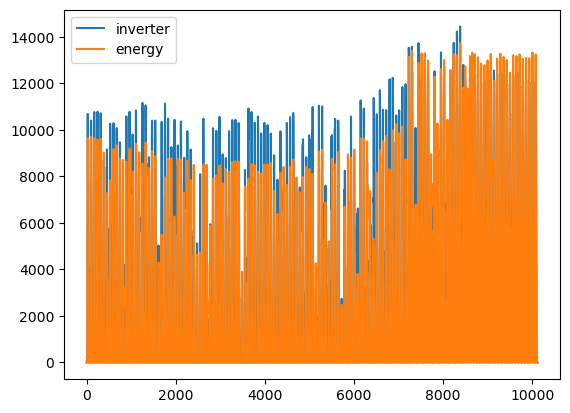

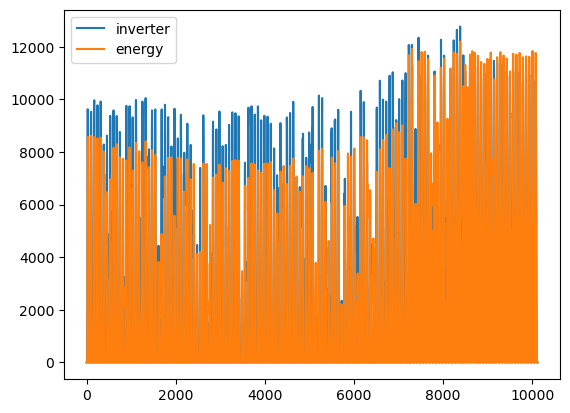

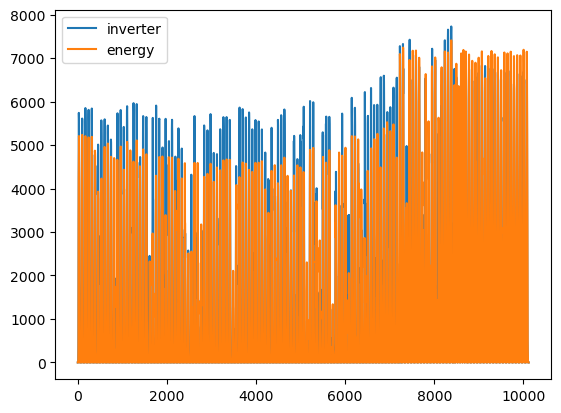

In [30]:
p = df.copy()
p1 = df[df['id']=='inverter1']
p2 = df[df['id']=='inverter2']
p3 = df[df['id']=='inverter3']

print('GENERAL')
metric(p['inverter'],p['energy'])
print('\n')
print('INVERTER1')
metric(p1['inverter'],p1['energy'])
print('\n')
print('INVERTER2')
metric(p2['inverter'],p2['energy'])
print('\n')
print('INVERTER3')
metric(p3['inverter'],p3['energy'])

p1[['inverter','energy']].plot()
p2[['inverter','energy']].plot()
p3[['inverter','energy']].plot()

In [31]:
df

,datetime,inverter,id,panel_size,temperature_2m,relative_humidity_2m,apparent_temperature,precipitation,rain,cloud_cover,...,shortwave_radiation_instant,direct_radiation_instant,diffuse_radiation_instant,direct_normal_irradiance_instant,terrestrial_radiation_instant,azimuth,zenith,month,hour,energy
0,2023-11-03 00:00:00,0.0,inverter1,107.1,18.358000,87.850685,19.639536,0.0,0.0,0.9,...,0.0,0.0,0.0,0.0,0.0,68.572855,140.781921,11,0,0.0
1,2023-11-03 00:00:00,0.0,inverter2,95.2,18.358000,87.850685,19.639536,0.0,0.0,0.9,...,0.0,0.0,0.0,0.0,0.0,68.572855,140.781921,11,0,0.0
2,2023-11-03 00:00:00,0.0,inverter3,57.8,18.358000,87.850685,19.639536,0.0,0.0,0.9,...,0.0,0.0,0.0,0.0,0.0,68.572855,140.781921,11,0,0.0
3,2023-11-03 01:00:00,0.0,inverter1,107.1,18.007999,84.240662,18.794279,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,80.521781,128.969584,11,1,0.0
4,2023-11-03 01:00:00,0.0,inverter2,95.2,18.007999,84.240662,18.794279,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,80.521781,128.969584,11,1,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10114,2024-06-30 22:00:00,0.0,inverter2,95.2,27.257999,59.964790,28.525261,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,2.623530,121.698732,6,22,0.0
10115,2024-06-30 22:00:00,0.0,inverter3,57.8,27.257999,59.964790,28.525261,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,2.623530,121.698732,6,22,0.0
10116,2024-06-30 23:00:00,0.0,inverter1,107.1,27.058001,54.521236,27.628948,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,18.442864,119.448533,6,23,0.0
10117,2024-06-30 23:00:00,0.0,inverter2,95.2,27.058001,54.521236,27.628948,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,18.442864,119.448533,6,23,0.0


In [33]:
data = df.copy()
data

,datetime,inverter,id,panel_size,temperature_2m,relative_humidity_2m,apparent_temperature,precipitation,rain,cloud_cover,...,shortwave_radiation_instant,direct_radiation_instant,diffuse_radiation_instant,direct_normal_irradiance_instant,terrestrial_radiation_instant,azimuth,zenith,month,hour,energy
0,2023-11-03 00:00:00,0.0,inverter1,107.1,18.358000,87.850685,19.639536,0.0,0.0,0.9,...,0.0,0.0,0.0,0.0,0.0,68.572855,140.781921,11,0,0.0
1,2023-11-03 00:00:00,0.0,inverter2,95.2,18.358000,87.850685,19.639536,0.0,0.0,0.9,...,0.0,0.0,0.0,0.0,0.0,68.572855,140.781921,11,0,0.0
2,2023-11-03 00:00:00,0.0,inverter3,57.8,18.358000,87.850685,19.639536,0.0,0.0,0.9,...,0.0,0.0,0.0,0.0,0.0,68.572855,140.781921,11,0,0.0
3,2023-11-03 01:00:00,0.0,inverter1,107.1,18.007999,84.240662,18.794279,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,80.521781,128.969584,11,1,0.0
4,2023-11-03 01:00:00,0.0,inverter2,95.2,18.007999,84.240662,18.794279,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,80.521781,128.969584,11,1,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10114,2024-06-30 22:00:00,0.0,inverter2,95.2,27.257999,59.964790,28.525261,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,2.623530,121.698732,6,22,0.0
10115,2024-06-30 22:00:00,0.0,inverter3,57.8,27.257999,59.964790,28.525261,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,2.623530,121.698732,6,22,0.0
10116,2024-06-30 23:00:00,0.0,inverter1,107.1,27.058001,54.521236,27.628948,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,18.442864,119.448533,6,23,0.0
10117,2024-06-30 23:00:00,0.0,inverter2,95.2,27.058001,54.521236,27.628948,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,18.442864,119.448533,6,23,0.0


In [34]:
#data.to_csv('all_data.csv', index=False)

# regression models

In [43]:
end_train = '2024-06-15 00:00:00'

evaluation = df.loc[df['datetime'] >= end_train]

df = df.loc[df['datetime'] < end_train]

In [44]:
data_train, data_test = train_test_split(df, test_size=0.2, random_state=1)
data_test = data_test.sort_values('datetime')

In [45]:
def smape(y_true,y_pred) :
    return 100 * np.mean((np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred))).map(lambda x: 0 if math.isnan(x) else x))

smape_score = make_scorer(smape)

## INVERTER1

In [46]:
data_train_1 = data_train[data_train['id']=='inverter1']
data_test_1 = data_test[data_test['id']=='inverter1']

In [47]:
X_train = data_train_1.drop(['datetime','id','inverter'],axis=1)
y_train = data_train_1['inverter']

X_test = data_test_1.drop(['datetime','id','inverter'],axis=1)
y_test = data_test_1['inverter']

In [50]:
def _(doc):
    return doc

def objective(trial):

    rf_max_depth = trial.suggest_int("max_depth", 3, 30)
    rf_n_estimators = trial.suggest_int("n_estimators", 100, 500)
    rf_min_samples_split = trial.suggest_int("min_samples_split", 2, 10)
    rf_min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 10)

    rf_cl = RandomForestRegressor(max_depth = rf_max_depth,n_estimators = rf_n_estimators,min_samples_split = rf_min_samples_split,min_samples_leaf = rf_min_samples_leaf,random_state = 1,n_jobs = -1)

    cv = KFold(n_splits=5, shuffle=True, random_state=1)

    scores = cross_val_score(rf_cl, X_train, y_train, cv=cv, scoring = smape_score)

    return scores.mean()

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100, n_jobs = -1, show_progress_bar=True)

print("Best trial:")
best_trial = study.best_trial
print("  Value: ", best_trial.value)
print("  Params: ")
for key, value in best_trial.params.items():
    print("    {}: {}".format(key, value))

[I 2024-07-17 10:33:24,498] A new study created in memory with name: no-name-a618a1a5-7945-4c9b-8945-66743cf14014


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2024-07-17 10:34:18,240] Trial 4 finished with value: 9.294409552291077 and parameters: {'max_depth': 15, 'n_estimators': 109, 'min_samples_split': 6, 'min_samples_leaf': 8}. Best is trial 4 with value: 9.294409552291077.
[I 2024-07-17 10:34:30,262] Trial 7 finished with value: 8.957866209042045 and parameters: {'max_depth': 12, 'n_estimators': 121, 'min_samples_split': 3, 'min_samples_leaf': 7}. Best is trial 7 with value: 8.957866209042045.
[I 2024-07-17 10:35:06,670] Trial 8 finished with value: 8.165004419346072 and parameters: {'max_depth': 24, 'n_estimators': 185, 'min_samples_split': 7, 'min_samples_leaf': 2}. Best is trial 8 with value: 8.165004419346072.
[I 2024-07-17 10:35:06,699] Trial 9 finished with value: 8.146167872272054 and parameters: {'max_depth': 12, 'n_estimators': 184, 'min_samples_split': 7, 'min_samples_leaf': 3}. Best is trial 9 with value: 8.146167872272054.
[I 2024-07-17 10:35:06,794] Trial 11 finished with value: 9.513411896333698 and parameters: {'max_de

[I 2024-07-17 10:42:47,092] Trial 37 finished with value: 8.093250687588796 and parameters: {'max_depth': 19, 'n_estimators': 236, 'min_samples_split': 2, 'min_samples_leaf': 2}. Best is trial 37 with value: 8.093250687588796.
[I 2024-07-17 10:42:51,280] Trial 39 finished with value: 8.071163715474459 and parameters: {'max_depth': 18, 'n_estimators': 229, 'min_samples_split': 6, 'min_samples_leaf': 2}. Best is trial 39 with value: 8.071163715474459.
[I 2024-07-17 10:42:53,400] Trial 40 finished with value: 8.065220778967426 and parameters: {'max_depth': 22, 'n_estimators': 237, 'min_samples_split': 6, 'min_samples_leaf': 2}. Best is trial 40 with value: 8.065220778967426.
[I 2024-07-17 10:42:53,518] Trial 42 finished with value: 8.204369036159013 and parameters: {'max_depth': 19, 'n_estimators': 222, 'min_samples_split': 7, 'min_samples_leaf': 2}. Best is trial 40 with value: 8.065220778967426.
[I 2024-07-17 10:42:58,533] Trial 41 finished with value: 8.071633086003226 and parameters: 

[I 2024-07-17 10:55:23,674] Trial 81 finished with value: 8.759128477020822 and parameters: {'max_depth': 27, 'n_estimators': 131, 'min_samples_split': 5, 'min_samples_leaf': 5}. Best is trial 70 with value: 7.807714722032645.
[I 2024-07-17 10:55:43,027] Trial 75 finished with value: 7.930265074038893 and parameters: {'max_depth': 26, 'n_estimators': 314, 'min_samples_split': 4, 'min_samples_leaf': 1}. Best is trial 70 with value: 7.807714722032645.
[I 2024-07-17 10:55:46,706] Trial 69 finished with value: 7.936603567095894 and parameters: {'max_depth': 15, 'n_estimators': 407, 'min_samples_split': 3, 'min_samples_leaf': 1}. Best is trial 70 with value: 7.807714722032645.
[I 2024-07-17 10:55:55,904] Trial 76 finished with value: 7.959317212617028 and parameters: {'max_depth': 26, 'n_estimators': 311, 'min_samples_split': 5, 'min_samples_leaf': 1}. Best is trial 70 with value: 7.807714722032645.
[I 2024-07-17 10:56:13,365] Trial 77 finished with value: 7.959380687629921 and parameters: 

In [51]:
best_trial.params

{'max_depth': 25,
 'n_estimators': 132,
 'min_samples_split': 4,
 'min_samples_leaf': 1}

{'max_depth': 25,
 'n_estimators': 132,
 'min_samples_split': 4,
 'min_samples_leaf': 1}

In [52]:
rf_cl = RandomForestRegressor(**best_trial.params, random_state = 1,n_jobs = -1)

cv = KFold(n_splits=5, shuffle=True, random_state=1)

scores = cross_val_score(rf_cl, X_train, y_train, cv=cv, scoring = smape_score)

scores

array([8.36040872, 6.8651037 , 7.64105948, 7.73615903, 8.43584269])

Adjusted R-squared - training:  0.9865761897018667


R-squared:  0.9141557255756027
Adjusted R-squared:  0.9096376058690553
RMSE:  1091.4714043073523


MAPE ML Model: 22.561764716776377
SMAPE ML Model: 8.380193471817751


<Axes: xlabel='inverter', ylabel='pred'>

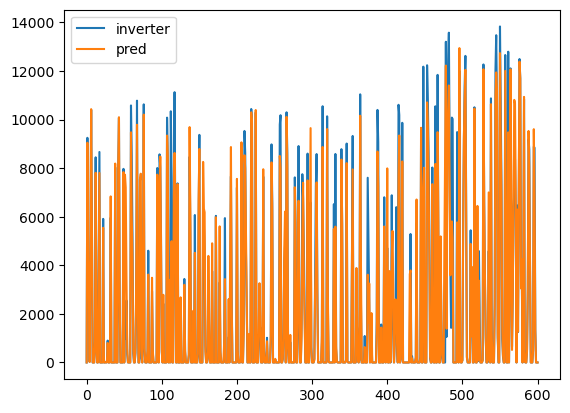

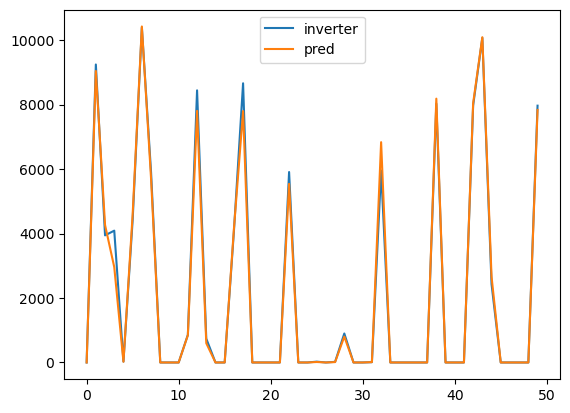

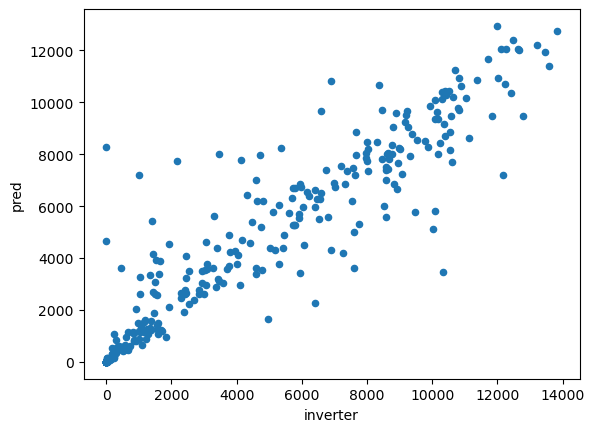

In [64]:
rf_cl = RandomForestRegressor(**best_trial.params, random_state = 1,n_jobs = -1)
rf_cl.fit(X_train,y_train)

y_pred = rf_cl.predict(X_test)
for i in range(len(y_pred)) :
    if y_pred[i] <0 :
        y_pred[i] = 0

print('Adjusted R-squared - training: ',1 - (1-rf_cl.score(X_train, y_train))*(len(y_train)-1)/(len(y_train)-X_train.shape[1]-1))
print('\n')

print('R-squared: ',rf_cl.score(X_test, y_test)) # R-squared
print('Adjusted R-squared: ',1 - (1-rf_cl.score(X_test, y_test))*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1))
print('RMSE: ',root_mean_squared_error(y_test, y_pred)) # RMSE
print('\n')

p = pd.DataFrame()
p['pred'] = y_pred
p['inverter'] = y_test.reset_index()['inverter']
p = p.sort_index()

metric(p['inverter'],p['pred'])

p[['inverter','pred']].plot()
p[['inverter','pred']][0:50].plot()
p[['inverter','pred']].plot.scatter(x='inverter',y='pred')

In [65]:
p['datetime'] = data_test_1.reset_index()['datetime']
p['datetime_utc'] = p['datetime'].dt.tz_localize('UTC')
p['datetime_local'] = p['datetime_utc'].map(lambda x: x.astimezone(pytz.timezone(timezone)))
p

,pred,inverter,datetime,datetime_utc,datetime_local
0,0.000000,0.000000,2023-11-03 02:00:00,2023-11-03 02:00:00+00:00,2023-11-03 04:00:00+02:00
1,9044.446339,9246.350000,2023-11-03 07:00:00,2023-11-03 07:00:00+00:00,2023-11-03 09:00:00+02:00
2,4265.837472,3944.500000,2023-11-03 12:00:00,2023-11-03 12:00:00+00:00,2023-11-03 14:00:00+02:00
3,2959.762559,4090.166667,2023-11-03 13:00:00,2023-11-03 13:00:00+00:00,2023-11-03 15:00:00+02:00
4,23.024129,27.466667,2023-11-03 15:00:00,2023-11-03 15:00:00+00:00,2023-11-03 17:00:00+02:00
...,...,...,...,...,...
596,6868.643886,8836.266667,2024-06-14 12:00:00,2024-06-14 12:00:00+00:00,2024-06-14 15:00:00+03:00
597,1298.374219,1331.583333,2024-06-14 15:00:00,2024-06-14 15:00:00+00:00,2024-06-14 18:00:00+03:00
598,0.000000,0.000000,2024-06-14 18:00:00,2024-06-14 18:00:00+00:00,2024-06-14 21:00:00+03:00
599,0.000000,0.000000,2024-06-14 19:00:00,2024-06-14 19:00:00+00:00,2024-06-14 22:00:00+03:00


## INVERTER2

In [67]:
data_train_2 = data_train[data_train['id']=='inverter2']
data_test_2 = data_test[data_test['id']=='inverter2']

In [68]:
X_train = data_train_2.drop(['datetime','id','inverter'],axis=1)
y_train = data_train_2['inverter']

X_test = data_test_2.drop(['datetime','id','inverter'],axis=1)
y_test = data_test_2['inverter']

In [69]:
def _(doc):
    return doc

def objective(trial):

    rf_max_depth = trial.suggest_int("max_depth", 3, 30)
    rf_n_estimators = trial.suggest_int("n_estimators", 100, 500)
    rf_min_samples_split = trial.suggest_int("min_samples_split", 2, 10)
    rf_min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 10)

    rf_cl = RandomForestRegressor(max_depth = rf_max_depth,n_estimators = rf_n_estimators,min_samples_split = rf_min_samples_split,min_samples_leaf = rf_min_samples_leaf,random_state = 1,n_jobs = -1)

    cv = KFold(n_splits=5, shuffle=True, random_state=1)

    scores = cross_val_score(rf_cl, X_train, y_train, cv=cv, scoring = smape_score)

    return scores.mean()

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100, n_jobs = -1, show_progress_bar=True)

print("Best trial:")
best_trial = study.best_trial
print("  Value: ", best_trial.value)
print("  Params: ")
for key, value in best_trial.params.items():
    print("    {}: {}".format(key, value))

[I 2024-07-17 12:17:21,977] A new study created in memory with name: no-name-1e93104c-c036-4b3d-ad73-ab295043f79b


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2024-07-17 12:18:36,432] Trial 3 finished with value: 9.436614402823059 and parameters: {'max_depth': 13, 'n_estimators': 102, 'min_samples_split': 8, 'min_samples_leaf': 7}. Best is trial 3 with value: 9.436614402823059.
[I 2024-07-17 12:18:40,917] Trial 5 finished with value: 8.985181258596912 and parameters: {'max_depth': 18, 'n_estimators': 116, 'min_samples_split': 3, 'min_samples_leaf': 3}. Best is trial 5 with value: 8.985181258596912.
[I 2024-07-17 12:18:41,909] Trial 8 finished with value: 9.54120111815765 and parameters: {'max_depth': 20, 'n_estimators': 114, 'min_samples_split': 10, 'min_samples_leaf': 8}. Best is trial 5 with value: 8.985181258596912.
[I 2024-07-17 12:19:26,009] Trial 11 finished with value: 62.35604131278834 and parameters: {'max_depth': 3, 'n_estimators': 174, 'min_samples_split': 9, 'min_samples_leaf': 5}. Best is trial 5 with value: 8.985181258596912.
[I 2024-07-17 12:19:39,617] Trial 10 finished with value: 9.423059641023798 and parameters: {'max_de

[I 2024-07-17 12:35:00,967] Trial 37 finished with value: 8.878966718461262 and parameters: {'max_depth': 20, 'n_estimators': 354, 'min_samples_split': 2, 'min_samples_leaf': 1}. Best is trial 24 with value: 8.867010286149636.
[I 2024-07-17 12:35:12,320] Trial 39 finished with value: 9.130410659983449 and parameters: {'max_depth': 15, 'n_estimators': 340, 'min_samples_split': 2, 'min_samples_leaf': 3}. Best is trial 24 with value: 8.867010286149636.
[I 2024-07-17 12:36:15,884] Trial 38 finished with value: 9.15771344749919 and parameters: {'max_depth': 20, 'n_estimators': 419, 'min_samples_split': 2, 'min_samples_leaf': 3}. Best is trial 24 with value: 8.867010286149636.
[I 2024-07-17 12:37:42,224] Trial 40 finished with value: 9.156466307134433 and parameters: {'max_depth': 20, 'n_estimators': 438, 'min_samples_split': 2, 'min_samples_leaf': 3}. Best is trial 24 with value: 8.867010286149636.
[I 2024-07-17 12:38:05,668] Trial 42 finished with value: 9.15959429744816 and parameters: {'

[I 2024-07-17 12:52:38,300] Trial 74 finished with value: 8.88130893756128 and parameters: {'max_depth': 18, 'n_estimators': 374, 'min_samples_split': 2, 'min_samples_leaf': 1}. Best is trial 24 with value: 8.867010286149636.
[I 2024-07-17 12:52:50,398] Trial 75 finished with value: 8.8764675313755 and parameters: {'max_depth': 21, 'n_estimators': 380, 'min_samples_split': 2, 'min_samples_leaf': 1}. Best is trial 24 with value: 8.867010286149636.
[I 2024-07-17 12:55:19,117] Trial 76 finished with value: 8.874138682881107 and parameters: {'max_depth': 23, 'n_estimators': 399, 'min_samples_split': 2, 'min_samples_leaf': 1}. Best is trial 24 with value: 8.867010286149636.
[I 2024-07-17 12:55:44,891] Trial 77 finished with value: 8.873664869512083 and parameters: {'max_depth': 23, 'n_estimators': 403, 'min_samples_split': 2, 'min_samples_leaf': 1}. Best is trial 24 with value: 8.867010286149636.
[I 2024-07-17 12:55:55,821] Trial 78 finished with value: 8.87551867237583 and parameters: {'ma

In [70]:
best_trial.params

{'max_depth': 29,
 'n_estimators': 396,
 'min_samples_split': 4,
 'min_samples_leaf': 1}

{'max_depth': 29,
 'n_estimators': 396,
 'min_samples_split': 4,
 'min_samples_leaf': 1}

In [71]:
rf_cl = RandomForestRegressor(**best_trial.params, random_state = 1,n_jobs = -1)

cv = KFold(n_splits=5, shuffle=True, random_state=1)

scores = cross_val_score(rf_cl, X_train, y_train, cv=cv, scoring = smape_score)

scores

array([9.73963174, 9.28716649, 7.61647575, 9.357967  , 8.33381045])

Adjusted R-squared - training:  0.9854112143462194


R-squared:  0.9358546395103119
Adjusted R-squared:  0.9326040300260372
RMSE:  849.347836051154


MAPE ML Model: 37.97911163320361
SMAPE ML Model: 9.392910418483229


<Axes: xlabel='inverter', ylabel='pred'>

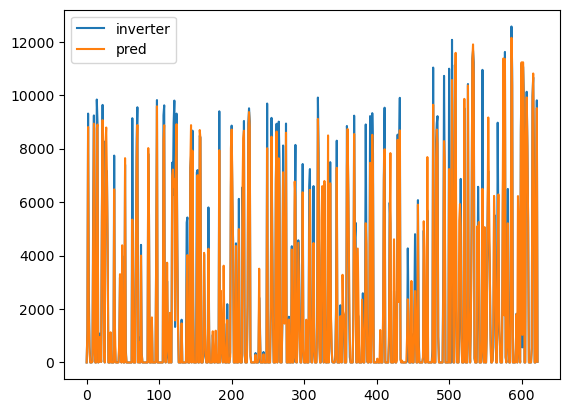

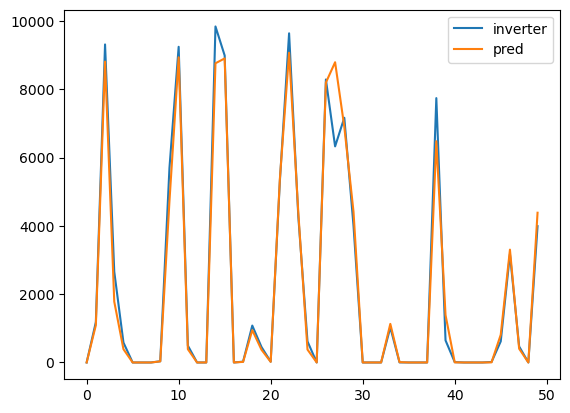

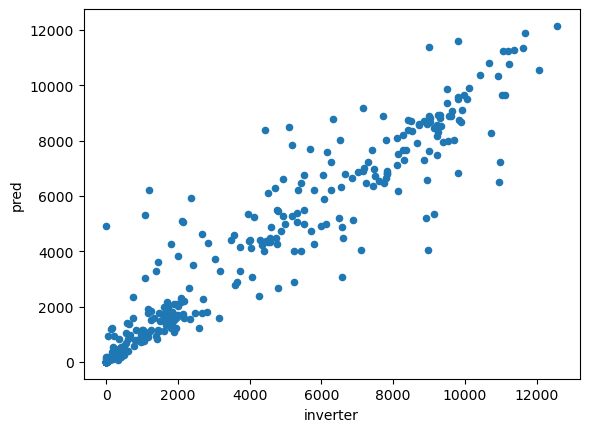

In [72]:
rf_cl = RandomForestRegressor(**best_trial.params, random_state = 1,n_jobs = -1)
rf_cl.fit(X_train,y_train)

y_pred = rf_cl.predict(X_test)
for i in range(len(y_pred)) :
    if y_pred[i] <0 :
        y_pred[i] = 0

print('Adjusted R-squared - training: ',1 - (1-rf_cl.score(X_train, y_train))*(len(y_train)-1)/(len(y_train)-X_train.shape[1]-1))
print('\n')

print('R-squared: ',rf_cl.score(X_test, y_test)) # R-squared
print('Adjusted R-squared: ',1 - (1-rf_cl.score(X_test, y_test))*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1))
print('RMSE: ',root_mean_squared_error(y_test, y_pred)) # RMSE
print('\n')

p = pd.DataFrame()
p['pred'] = y_pred
p['inverter'] = y_test.reset_index()['inverter']
p = p.sort_index()

metric(p['inverter'],p['pred'])

p[['inverter','pred']].plot()
p[['inverter','pred']][0:50].plot()
p[['inverter','pred']].plot.scatter(x='inverter',y='pred')

In [73]:
p['datetime'] = data_test_2.reset_index()['datetime']
p['datetime_utc'] = p['datetime'].dt.tz_localize('UTC')
p['datetime_local'] = p['datetime_utc'].map(lambda x: x.astimezone(pytz.timezone(timezone)))
p

,pred,inverter,datetime,datetime_utc,datetime_local
0,0.000000,0.000000,2023-11-03 02:00:00,2023-11-03 02:00:00+00:00,2023-11-03 04:00:00+02:00
1,1090.104533,1181.133333,2023-11-03 05:00:00,2023-11-03 05:00:00+00:00,2023-11-03 07:00:00+02:00
2,8808.572860,9311.716667,2023-11-03 09:00:00,2023-11-03 09:00:00+00:00,2023-11-03 11:00:00+02:00
3,1782.523932,2660.616667,2023-11-03 13:00:00,2023-11-03 13:00:00+00:00,2023-11-03 15:00:00+02:00
4,389.264700,582.950000,2023-11-03 14:00:00,2023-11-03 14:00:00+00:00,2023-11-03 16:00:00+02:00
...,...,...,...,...,...
618,0.000000,0.000000,2024-06-13 21:00:00,2024-06-13 21:00:00+00:00,2024-06-14 00:00:00+03:00
619,0.000000,0.000000,2024-06-14 00:00:00,2024-06-14 00:00:00+00:00,2024-06-14 03:00:00+03:00
620,6205.706174,5793.283333,2024-06-14 05:00:00,2024-06-14 05:00:00+00:00,2024-06-14 08:00:00+03:00
621,9516.892252,9807.266667,2024-06-14 07:00:00,2024-06-14 07:00:00+00:00,2024-06-14 10:00:00+03:00


## INVERTER3

In [74]:
data_train_3 = data_train[data_train['id']=='inverter3']
data_test_3 = data_test[data_test['id']=='inverter3']

In [75]:
X_train = data_train_3.drop(['datetime','id','inverter'],axis=1)
y_train = data_train_3['inverter']

X_test = data_test_3.drop(['datetime','id','inverter'],axis=1)
y_test = data_test_3['inverter']

In [76]:
def _(doc):
    return doc

def objective(trial):

    rf_max_depth = trial.suggest_int("max_depth", 3, 30)
    rf_n_estimators = trial.suggest_int("n_estimators", 100, 500)
    rf_min_samples_split = trial.suggest_int("min_samples_split", 2, 10)
    rf_min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 10)

    rf_cl = RandomForestRegressor(max_depth = rf_max_depth,n_estimators = rf_n_estimators,min_samples_split = rf_min_samples_split,min_samples_leaf = rf_min_samples_leaf,random_state = 1,n_jobs = -1)

    cv = KFold(n_splits=5, shuffle=True, random_state=1)

    scores = cross_val_score(rf_cl, X_train, y_train, cv=cv, scoring = smape_score)

    return scores.mean()

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100, n_jobs = -1, show_progress_bar=True)

print("Best trial:")
best_trial = study.best_trial
print("  Value: ", best_trial.value)
print("  Params: ")
for key, value in best_trial.params.items():
    print("    {}: {}".format(key, value))

[I 2024-07-17 14:57:32,385] A new study created in memory with name: no-name-6264cf08-8f54-40e5-ac0f-094d4bce7950


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2024-07-17 15:00:46,800] Trial 4 finished with value: 60.815216404491174 and parameters: {'max_depth': 6, 'n_estimators': 133, 'min_samples_split': 10, 'min_samples_leaf': 4}. Best is trial 4 with value: 60.815216404491174.
[I 2024-07-17 15:01:45,039] Trial 7 finished with value: 60.33288429340247 and parameters: {'max_depth': 8, 'n_estimators': 183, 'min_samples_split': 4, 'min_samples_leaf': 1}. Best is trial 7 with value: 60.33288429340247.
[I 2024-07-17 15:02:17,558] Trial 0 finished with value: 9.3566139632071 and parameters: {'max_depth': 25, 'n_estimators': 195, 'min_samples_split': 7, 'min_samples_leaf': 2}. Best is trial 0 with value: 9.3566139632071.
[I 2024-07-17 15:02:17,453] Trial 9 finished with value: 10.326789291950755 and parameters: {'max_depth': 30, 'n_estimators': 194, 'min_samples_split': 2, 'min_samples_leaf': 10}. Best is trial 9 with value: 10.326789291950755.
[I 2024-07-17 15:02:20,805] Trial 11 finished with value: 10.331479316034315 and parameters: {'max_d

[I 2024-07-17 15:17:47,754] Trial 37 finished with value: 9.522295571813945 and parameters: {'max_depth': 23, 'n_estimators': 146, 'min_samples_split': 6, 'min_samples_leaf': 6}. Best is trial 28 with value: 9.257022841937122.
[I 2024-07-17 15:18:19,388] Trial 46 finished with value: 9.361131439051462 and parameters: {'max_depth': 20, 'n_estimators': 102, 'min_samples_split': 7, 'min_samples_leaf': 4}. Best is trial 28 with value: 9.257022841937122.
[I 2024-07-17 15:18:21,148] Trial 45 finished with value: 9.356854400400128 and parameters: {'max_depth': 14, 'n_estimators': 101, 'min_samples_split': 7, 'min_samples_leaf': 4}. Best is trial 28 with value: 9.257022841937122.
[I 2024-07-17 15:18:36,575] Trial 38 finished with value: 9.365406767107164 and parameters: {'max_depth': 24, 'n_estimators': 154, 'min_samples_split': 7, 'min_samples_leaf': 4}. Best is trial 28 with value: 9.257022841937122.
[I 2024-07-17 15:18:46,695] Trial 39 finished with value: 9.365406767107164 and parameters: 

[I 2024-07-17 15:30:26,209] Trial 73 finished with value: 9.34576892111335 and parameters: {'max_depth': 12, 'n_estimators': 221, 'min_samples_split': 3, 'min_samples_leaf': 1}. Best is trial 57 with value: 9.198026185452832.
[I 2024-07-17 15:30:28,378] Trial 75 finished with value: 9.345059788691607 and parameters: {'max_depth': 12, 'n_estimators': 207, 'min_samples_split': 3, 'min_samples_leaf': 1}. Best is trial 57 with value: 9.198026185452832.
[I 2024-07-17 15:30:47,785] Trial 76 finished with value: 29.313071370814647 and parameters: {'max_depth': 11, 'n_estimators': 201, 'min_samples_split': 3, 'min_samples_leaf': 1}. Best is trial 57 with value: 9.198026185452832.
[I 2024-07-17 15:30:47,836] Trial 77 finished with value: 29.306378606498612 and parameters: {'max_depth': 11, 'n_estimators': 209, 'min_samples_split': 3, 'min_samples_leaf': 1}. Best is trial 57 with value: 9.198026185452832.
[I 2024-07-17 15:31:00,708] Trial 78 finished with value: 9.33524296325511 and parameters: 

In [77]:
best_trial.params

{'max_depth': 19,
 'n_estimators': 123,
 'min_samples_split': 4,
 'min_samples_leaf': 2}

{'max_depth': 19,
 'n_estimators': 123,
 'min_samples_split': 4,
 'min_samples_leaf': 2}

In [78]:
rf_cl = RandomForestRegressor(**best_trial.params, random_state = 1,n_jobs = -1)

cv = KFold(n_splits=5, shuffle=True, random_state=1)

scores = cross_val_score(rf_cl, X_train, y_train, cv=cv, scoring = smape_score)

scores

array([ 8.11642012,  9.66469795,  8.63935215,  9.17385956, 10.39580115])

Adjusted R-squared - training:  0.9826083261440568


R-squared:  0.8890233979045037
Adjusted R-squared:  0.8828465925930661
RMSE:  632.3267124238192


MAPE ML Model: 50.11343739780274
SMAPE ML Model: 11.23036034778659


<Axes: xlabel='inverter', ylabel='pred'>

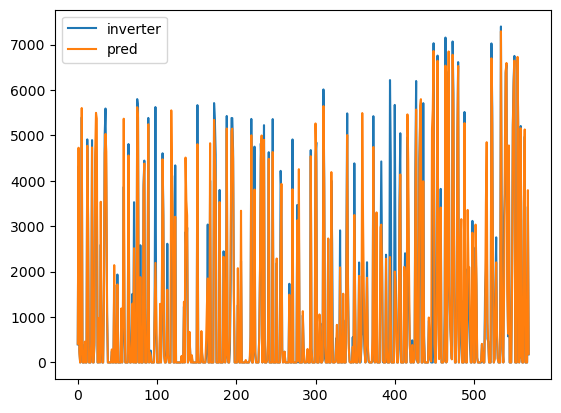

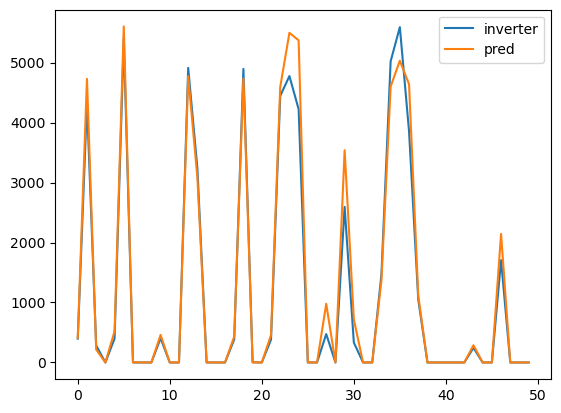

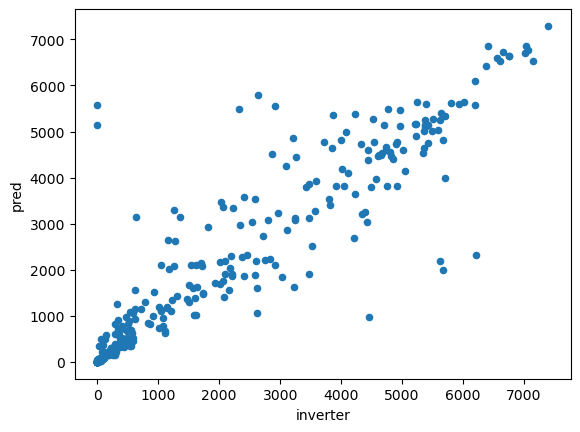

In [79]:
rf_cl = RandomForestRegressor(**best_trial.params, random_state = 1,n_jobs = -1)
rf_cl.fit(X_train,y_train)

y_pred = rf_cl.predict(X_test)
for i in range(len(y_pred)) :
    if y_pred[i] <0 :
        y_pred[i] = 0

print('Adjusted R-squared - training: ',1 - (1-rf_cl.score(X_train, y_train))*(len(y_train)-1)/(len(y_train)-X_train.shape[1]-1))
print('\n')

print('R-squared: ',rf_cl.score(X_test, y_test)) # R-squared
print('Adjusted R-squared: ',1 - (1-rf_cl.score(X_test, y_test))*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1))
print('RMSE: ',root_mean_squared_error(y_test, y_pred)) # RMSE
print('\n')

p = pd.DataFrame()
p['pred'] = y_pred
p['inverter'] = y_test.reset_index()['inverter']
p = p.sort_index()

metric(p['inverter'],p['pred'])

p[['inverter','pred']].plot()
p[['inverter','pred']][0:50].plot()
p[['inverter','pred']].plot.scatter(x='inverter',y='pred')

In [80]:
p['datetime'] = data_test_3.reset_index()['datetime']
p['datetime_utc'] = p['datetime'].dt.tz_localize('UTC')
p['datetime_local'] = p['datetime_utc'].map(lambda x: x.astimezone(pytz.timezone(timezone)))
p

,pred,inverter,datetime,datetime_utc,datetime_local
0,411.377169,397.116667,2023-11-03 05:00:00,2023-11-03 05:00:00+00:00,2023-11-03 07:00:00+02:00
1,4727.518312,4324.183333,2023-11-03 10:00:00,2023-11-03 10:00:00+00:00,2023-11-03 12:00:00+02:00
2,215.326823,283.716667,2023-11-03 14:00:00,2023-11-03 14:00:00+00:00,2023-11-03 16:00:00+02:00
3,0.000000,0.000000,2023-11-04 00:00:00,2023-11-04 00:00:00+00:00,2023-11-04 02:00:00+02:00
4,520.885426,400.033333,2023-11-04 05:00:00,2023-11-04 05:00:00+00:00,2023-11-04 07:00:00+02:00
...,...,...,...,...,...
565,0.000000,0.000000,2024-06-13 19:00:00,2024-06-13 19:00:00+00:00,2024-06-13 22:00:00+03:00
566,0.000000,0.000000,2024-06-14 01:00:00,2024-06-14 01:00:00+00:00,2024-06-14 04:00:00+03:00
567,0.000000,0.000000,2024-06-14 02:00:00,2024-06-14 02:00:00+00:00,2024-06-14 05:00:00+03:00
568,3793.295928,3430.583333,2024-06-14 05:00:00,2024-06-14 05:00:00+00:00,2024-06-14 08:00:00+03:00
